<a href="https://colab.research.google.com/github/dongsikchoi/ML_Time-Series_EDA/blob/master/BG_Prediction_Univariate_Filter_X_01_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 필요 라이브러리 로드

In [510]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import tensorflow as tf
import sys
matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=12
matplotlib.rcParams['ytick.labelsize']=12
matplotlib.rcParams['text.color']='k'

In [511]:
print('Python: %s'%(sys.version))
print('Numpy: %s'%(np.__version__))
print('Pandas: %s'%(pd.__version__))
#print('pmdarima: %s'%(pmdarima.__version__))
#print('seaborn: %s'%(sns.__version__))
#print('statsmodel: %s'%(statsmodels.__version__))
print('matplotlib: %s'%(matplotlib.__version__))
print('tensorflow : %s'%( tf.__version__))

Python: 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]
Numpy: 1.19.5
Pandas: 1.1.5
matplotlib: 3.2.2
tensorflow : 2.4.1


In [512]:
# Colab
#from google.colab import auth
#auth.authenticate_user()

In [513]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [514]:
pd.set_option('display.max_columns',500) 
#출력시 생략 X

### 데이터셋 설정 

In [515]:
#df=pd.read_excel("BG_Dataset/BG_Sample55.xlsx")

In [516]:
# Colab
df = pd.read_excel("/content/drive/MyDrive/BG_Dataset/BG_sample1.xlsx")
#df = pd.read_csv("/content/drive/MyDrive/BG_Dataset/BG_Sample46.csv")


In [517]:
df.shape

(1055, 14)

In [518]:
df.head(13)

색인 타임스탬프(YYYY-MM-DDThh:mm:ss) 이벤트 유형 이벤트 하위 유형                환자 정보  \
0    1                        NaN     이름       NaN                  sch   
1    2                        NaN      성       NaN                    s   
2    3                        NaN   생년월일       NaN  1990-01-01 00:00:00   
3    4                        NaN     장치       NaN                  NaN   
4    5                        NaN     경고        하락                  NaN   
5    6                        NaN     경고        높음                  NaN   
6    7                        NaN     경고        낮음                  NaN   
7    8                        NaN     경고     신호 손실                  NaN   
8    9                        NaN     경고        상승                  NaN   
9   10                        NaN     경고     매우 낮음                  NaN   
10  11        2019-05-07T16:07:41     교정       NaN                  NaN   
11  12        2019-05-07T16:07:54     교정       NaN                  NaN   
12  13        2019-05-07T16:12:56    EGV       NaN                  NaN   

                   장치 정보 소스 장치 ID  포도당 값 (mg/dL)  인슐린 값(u)  탄수화물 값 (그램)  \
0                    NaN      NaN            NaN       NaN          NaN   
1                    NaN      NaN            NaN       NaN          NaN   
2                    NaN      NaN            NaN       NaN          NaN   
3   Dexcom G5 Mobile App  Android            NaN       NaN          NaN   
4                    NaN  Android            NaN       NaN          NaN   
5                    NaN  Android          400.0       NaN          NaN   
6                    NaN  Android           60.0       NaN          NaN   
7                    NaN  Android            NaN       NaN          NaN   
8                    NaN  Android            NaN       NaN          NaN   
9                    NaN  Android           55.0       NaN          NaN   
10                   NaN  Android          120.0       NaN          NaN   
11                   NaN  Android          120.0       NaN          NaN   
12                   NaN  Android          115.0       NaN          NaN   

   기간(hh:mm:ss)  포도당 변화율 (mg/dL/min)  트랜스미터 시간 (배장 정수) 트랜스미터 ID  
0           NaN                  NaN               NaN      NaN  
1           NaN                  NaN               NaN      NaN  
2           NaN                  NaN               NaN      NaN  
3           NaN                  NaN               NaN      NaN  
4           NaN                  3.0               NaN      NaN  
5           NaN                  NaN               NaN      NaN  
6           NaN                  NaN               NaN      NaN  
7      00:30:00                  NaN               NaN      NaN  
8           NaN                  3.0               NaN      NaN  
9           NaN                  NaN               NaN      NaN  
10          NaN                  NaN               NaN   40EPTP  
11          NaN                  NaN               NaN   40EPTP  
12          NaN                  NaN         1836247.0   40EPTP

In [519]:
#필요없는 열 제거
cols = ['색인', '이벤트 하위 유형', '환자 정보', '장치 정보', '소스 장치 ID', '기간(hh:mm:ss)', '포도당 변화율 (mg/dL/min)', '트랜스미터 시간 (배장 정수)', '트랜스미터 ID']
df.drop(cols, axis=1, inplace=True)


In [520]:
df=df.rename({'타임스탬프(YYYY-MM-DDThh:mm:ss)':'Timestamp','포도당 값 (mg/dL)':'Glucose','이벤트 유형':'Event',
             '인슐린 값(u)':'Insulin','탄수화물 값 (그램)':'Meal'},axis='columns')

In [521]:
df['Event'].value_counts()

EGV     1031
교정        14
경고         6
이름         1
성          1
생년월일       1
장치         1
Name: Event, dtype: int64

In [522]:
df['Glucose'].value_counts()

160.0    25
133.0    23
144.0    18
142.0    17
163.0    17
         ..
338.0     1
229.0     1
305.0     1
399.0     1
243.0     1
Name: Glucose, Length: 223, dtype: int64

In [523]:
df.tail()

Timestamp Event  Glucose  Insulin  Meal
1050  2019-05-11T23:42:33   EGV    206.0      NaN   NaN
1051  2019-05-11T23:47:34   EGV    199.0      NaN   NaN
1052  2019-05-11T23:52:33   EGV    190.0      NaN   NaN
1053  2019-05-11T23:57:33   EGV    194.0      NaN   NaN
1054  2019-05-12T00:02:33   EGV    181.0      NaN   NaN

In [524]:
# 인슐린 투여횟수
df['Insulin'].value_counts()

Series([], Name: Insulin, dtype: int64)

In [525]:
# 식사 횟수
df['Meal'].value_counts()

Series([], Name: Meal, dtype: int64)

In [526]:
df.head(15)

Timestamp Event  Glucose  Insulin  Meal
0                   NaN    이름      NaN      NaN   NaN
1                   NaN     성      NaN      NaN   NaN
2                   NaN  생년월일      NaN      NaN   NaN
3                   NaN    장치      NaN      NaN   NaN
4                   NaN    경고      NaN      NaN   NaN
5                   NaN    경고    400.0      NaN   NaN
6                   NaN    경고     60.0      NaN   NaN
7                   NaN    경고      NaN      NaN   NaN
8                   NaN    경고      NaN      NaN   NaN
9                   NaN    경고     55.0      NaN   NaN
10  2019-05-07T16:07:41    교정    120.0      NaN   NaN
11  2019-05-07T16:07:54    교정    120.0      NaN   NaN
12  2019-05-07T16:12:56   EGV    115.0      NaN   NaN
13  2019-05-07T16:17:47   EGV    126.0      NaN   NaN
14  2019-05-07T16:22:47   EGV    135.0      NaN   NaN

In [527]:
# Timestamp != NaN일 때까지 count하고 
# Nan에 해당하는 인스턴스 제거 
df=df.dropna(subset=['Timestamp'])

In [528]:
df.head(20)

Timestamp Event  Glucose  Insulin  Meal
10  2019-05-07T16:07:41    교정    120.0      NaN   NaN
11  2019-05-07T16:07:54    교정    120.0      NaN   NaN
12  2019-05-07T16:12:56   EGV    115.0      NaN   NaN
13  2019-05-07T16:17:47   EGV    126.0      NaN   NaN
14  2019-05-07T16:22:47   EGV    135.0      NaN   NaN
15  2019-05-07T16:27:48   EGV    139.0      NaN   NaN
16  2019-05-07T16:32:48   EGV    143.0      NaN   NaN
17  2019-05-07T16:37:48   EGV    150.0      NaN   NaN
18  2019-05-07T16:42:48   EGV    156.0      NaN   NaN
19  2019-05-07T16:47:47   EGV    150.0      NaN   NaN
20  2019-05-07T16:52:48   EGV    144.0      NaN   NaN
21  2019-05-07T16:57:47   EGV    144.0      NaN   NaN
22  2019-05-07T17:02:47   EGV    134.0      NaN   NaN
23  2019-05-07T17:07:47   EGV    120.0      NaN   NaN
24  2019-05-07T17:12:47   EGV    113.0      NaN   NaN
25  2019-05-07T17:17:47   EGV    106.0      NaN   NaN
26  2019-05-07T17:22:47   EGV    101.0      NaN   NaN
27  2019-05-07T17:27:46   EGV     94.0      NaN   NaN
28  2019-05-07T17:32:47   EGV     90.0      NaN   NaN
29  2019-05-07T17:37:47   EGV     88.0      NaN   NaN

In [529]:
df.shape

(1045, 5)

In [530]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [531]:
df.head(15)

Timestamp Event  Glucose  Insulin  Meal
0   2019-05-07T16:07:41    교정    120.0      NaN   NaN
1   2019-05-07T16:07:54    교정    120.0      NaN   NaN
2   2019-05-07T16:12:56   EGV    115.0      NaN   NaN
3   2019-05-07T16:17:47   EGV    126.0      NaN   NaN
4   2019-05-07T16:22:47   EGV    135.0      NaN   NaN
5   2019-05-07T16:27:48   EGV    139.0      NaN   NaN
6   2019-05-07T16:32:48   EGV    143.0      NaN   NaN
7   2019-05-07T16:37:48   EGV    150.0      NaN   NaN
8   2019-05-07T16:42:48   EGV    156.0      NaN   NaN
9   2019-05-07T16:47:47   EGV    150.0      NaN   NaN
10  2019-05-07T16:52:48   EGV    144.0      NaN   NaN
11  2019-05-07T16:57:47   EGV    144.0      NaN   NaN
12  2019-05-07T17:02:47   EGV    134.0      NaN   NaN
13  2019-05-07T17:07:47   EGV    120.0      NaN   NaN
14  2019-05-07T17:12:47   EGV    113.0      NaN   NaN

In [532]:
df.shape

(1045, 5)

In [533]:
# 높음, 낮음, 교정 인덱스 저장 
high_list=[]
low_list=[]
calib_list=[]
insulin_list=[]
meal_list=[]

In [534]:
def isNaN(num):
    return num==num

In [535]:
# 혈당 '높음' 빈도 카운트
def glucose_count_high(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='높음':
            count=count+1
            high_list.append(i)
    print('높음 : ',count)
    

In [536]:
# 혈당 '낮음' 빈도 카운트
def glucose_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='낮음':
            count=count+1
            low_list.append(i)
    print('낮음 : ',count)

In [537]:
# 혈당 '교정' 빈도 카운트
def calibration_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='교정':
            count=count+1
            calib_list.append(i)
    print('교정 : ',count)

In [538]:
# 인슐린 카운트 
#def insul_count(df,col):
#    count=0
#    for i, row in df.iterrows():
#         val = row[col]
#         if val==0:
#            count=count+1
#            insulin_list.append(i)
#    print('인슐린 : ',count)

In [539]:
# 인슐린 카운트 
def insul_count(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if isNaN(val)==True:
            count=count+1
            insulin_list.append(i)
    print('인슐린 : ',count)

In [540]:
# 식사 횟수 카운트 
#def meal_count(df,col):
#    count=0
#    for i, row in df.iterrows():
#         val = row[col]
#         if val==0:
#            count=count+1
#            meal_list.append(i)
#    print('식사 횟수 : ',count)

In [541]:
# 식사 횟수 카운트 
def meal_count(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if isNaN(val)==True:
            count=count+1
            meal_list.append(i)
    print('식사 횟수 : ',count)

In [542]:
glucose_count_high(df,'Glucose')

높음 :  0


In [543]:
print('높음 개수 :',len(high_list))

높음 개수 : 0


In [544]:
print('낮음 개수 :',len(low_list))

낮음 개수 : 0


In [545]:
print('교정 개수 :',len(calib_list))

교정 개수 : 0


In [546]:
glucose_count_low(df,'Glucose')

낮음 :  0


In [547]:
low_list

[]

In [548]:
calibration_count_low(df,'Event')

교정 :  14


In [549]:
calib_list

[0, 1, 58, 173, 287, 349, 470, 579, 639, 751, 874, 950, 952, 1015]

In [550]:
insul_count(df,'Insulin')

인슐린 :  0


In [551]:
insulin_list

[]

In [552]:
meal_count(df,'Meal')

식사 횟수 :  0


In [553]:
meal_list

[]

In [554]:
df['Insulin'].value_counts()

Series([], Name: Insulin, dtype: int64)

In [555]:
df['Meal'].value_counts()

Series([], Name: Meal, dtype: int64)

In [556]:
isNaN(df['Glucose'][14])

True

In [557]:
import math
for i in insulin_list:
    
    if isNaN(df['Glucose'][i+1]):
        df['Insulin'][i+1]=0
        continue
    if isNaN(df['Glucose'][i+2]):
        df['Insulin'][i+2]=0
        continue
    if isNaN(df['Glucose'][i+3]):
        df['Insulin'][i+3]=0
        continue
    if isNaN(df['Glucose'][i+4]):
        df['Insulin'][i+4]=0
        continue

In [558]:
for i in meal_list:
    
    if isNaN(df['Glucose'][i+1]):
        df['Meal'][i+1]=0
        continue
    if isNaN(df['Glucose'][i+2]):
        df['Meal'][i+2]=0
        continue
    if isNaN(df['Glucose'][i+3]):
        df['Meal'][i+3]=0
        continue
    if isNaN(df['Glucose'][i+4]):
        df['Meal'][i+4]=0
        continue

In [559]:
import math
math.isnan(df['Glucose'][14])

False

In [560]:
insulin_list

[]

In [561]:
SetList1 = set(insulin_list)
SetList2 = set(meal_list)

C = list((SetList2.difference(SetList1)))

insulin_list.extend(C)

In [562]:
insulin_list

[]

In [563]:
df=df.drop(insulin_list)

In [564]:
df[10:20]

Timestamp Event  Glucose  Insulin  Meal
10  2019-05-07T16:52:48   EGV    144.0      NaN   NaN
11  2019-05-07T16:57:47   EGV    144.0      NaN   NaN
12  2019-05-07T17:02:47   EGV    134.0      NaN   NaN
13  2019-05-07T17:07:47   EGV    120.0      NaN   NaN
14  2019-05-07T17:12:47   EGV    113.0      NaN   NaN
15  2019-05-07T17:17:47   EGV    106.0      NaN   NaN
16  2019-05-07T17:22:47   EGV    101.0      NaN   NaN
17  2019-05-07T17:27:46   EGV     94.0      NaN   NaN
18  2019-05-07T17:32:47   EGV     90.0      NaN   NaN
19  2019-05-07T17:37:47   EGV     88.0      NaN   NaN

In [565]:
df['Glucose'].unique()

array([120., 115., 126., 135., 139., 143., 150., 156., 144., 134., 113.,
       106., 101.,  94.,  90.,  88.,  81.,  83.,  91.,  97.,  99.,  98.,
       103., 109., 117., 123., 124., 122., 121., 111., 105., 104., 108.,
       130., 119., 133., 152., 155., 160., 163., 164., 165., 166., 167.,
       168., 170., 175., 172., 173., 171., 174., 177., 178., 184., 187.,
       186., 188., 182., 176., 169., 159., 158., 157., 161., 162., 154.,
       149., 148., 147., 146., 151., 180., 181., 183., 142., 141., 140.,
       138., 145., 195., 204., 206., 203., 201., 199., 197., 194., 191.,
       185., 137., 136., 132., 131., 129., 125., 128., 127., 153., 208.,
       224., 211., 210., 200., 193., 190., 112., 107., 100., 198., 228.,
       239., 248., 253., 251., 247., 240., 245., 244., 242., 235., 231.,
       212., 202., 218., 220., 219., 214., 223., 241., 243., 238., 234.,
       236., 246., 233., 295., 275., 232., 222., 215., 226., 216., 207.,
       209., 179., 118., 114., 110., 102.,  95.,  9

In [566]:
df.isnull().sum()

Timestamp       0
Event           0
Glucose         0
Insulin      1045
Meal         1045
dtype: int64

In [567]:
df['Event'].value_counts()

EGV    1031
교정       14
Name: Event, dtype: int64

### 높음 낮음 고정 (추후 전처리 과정에서 400,408,416,408,400 이런 식으로 선형으로 변환해줄 것)

In [568]:
def fix_glucose_low(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='낮음':
            df.loc[i,col] = 60

In [569]:
def fix_glucose(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='높음':
            df.loc[i,col] = 400
        elif val > 400:
            df.loc[i,col]=400

In [570]:
fix_glucose_low(df,'Glucose')

In [571]:
fix_glucose(df,'Glucose')

In [572]:
df['Glucose'].value_counts()

160.0    25
133.0    23
144.0    18
163.0    17
142.0    17
         ..
229.0     1
338.0     1
302.0     1
96.0      1
367.0     1
Name: Glucose, Length: 221, dtype: int64

In [573]:
df.isnull().sum()

Timestamp       0
Event           0
Glucose         0
Insulin      1045
Meal         1045
dtype: int64

In [574]:
df['Event'].unique()

array(['교정', 'EGV'], dtype=object)

In [575]:
## 이벤트에 '운동' 있어서 혈당값 비어있음 
# 모델 안돌아감 
df=df.dropna(subset=['Glucose'])

In [576]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [577]:
new_insul_list =[]
new_meal_list =[]
new_insul_and_meal_list=[]

for i in range(len(df)):
    if (df['Insulin'][i] ==0 and df['Meal'][i]==0):
        new_insul_and_meal_list.append(i)
    if (df['Insulin'][i]==0 and df['Meal'][i]!=0):
        new_insul_list.append(i)
    if (df['Insulin'][i]!=0 and df['Meal'][i]==0):
        new_meal_list.append(i)

In [578]:
new_meal_list

[]

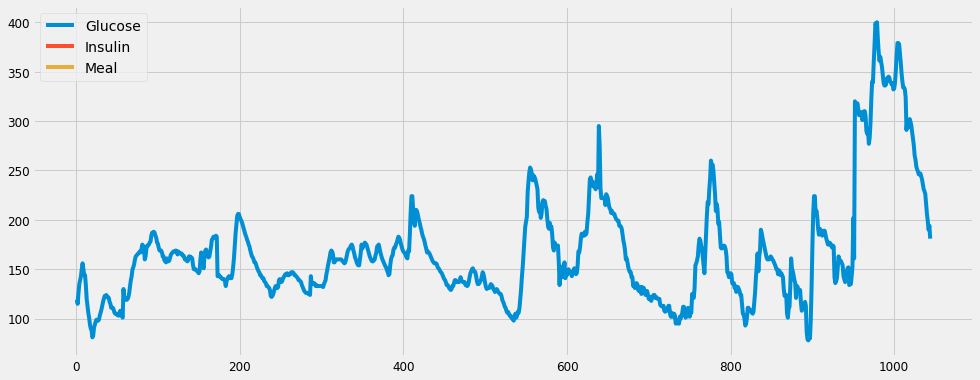

In [579]:
df.plot(figsize=(15,6))
plt.show()

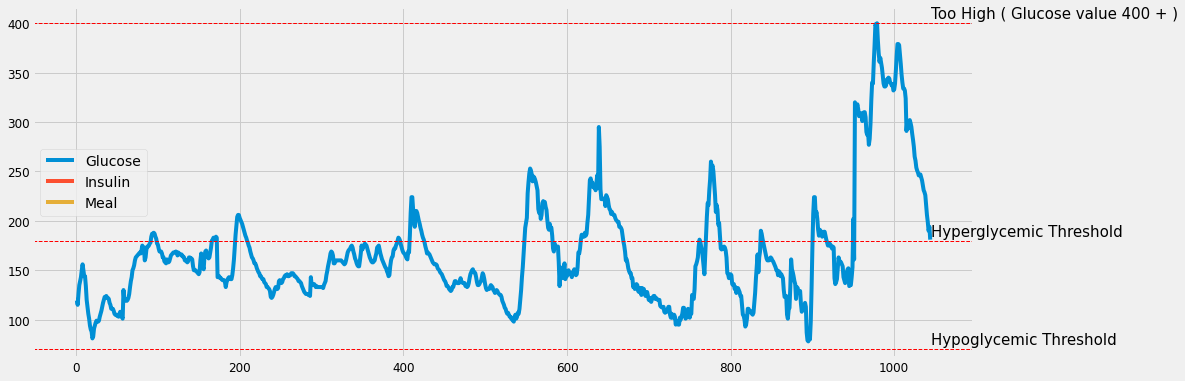

In [580]:
df.plot(figsize=(15,6))
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.annotate(df['Timestamp'][13],xy=(-50,40),xytext=(-50,0),fontsize=20,bbox=dict(boxstyle='square',
#                                                               color='white'),arrowprops=dict(facecolor='black'))
#plt.annotate(df['Timestamp'][len(df['Timestamp'])],xytext=(-,0),fontsize=20,bbox=dict(boxstyle='square',
 #                                                              color='white'))
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [581]:
#df.drop(0,inplace=True)

In [582]:
# drop한 인스턴스가 있어서 인덱스 리셋
#df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
#df=df.reset_index(drop=True)
#df.head(21)

In [583]:
# 인슐린, 탄수화물 투여시 혈당값 NULL
# 그래서 t시점에 t-2 , t-1 크기비교해서 upper면 이렇게 lower면 이렇게 해서 interpolation ( 보간)
# 이거 위에 참고사항 drop하고 나서 적용 해줘야됨
#insul=list()
#import math
#def interpolate_glucose(df,col):
#    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
#        if math.isnan(val):
#            if df['Glucose'][i-2] >= df['Glucose'][i-1]:
#                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
#                df.loc[i,col]= df['Glucose'][i-1] - c
#                insul.append(i)
#                print(insul)
                
#            if df['Glucose'][i-2] < df['Glucose'][i-1]:
#                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
#                df.loc[i,col]= df['Glucose'][i-1] - c
#                insul.append(i)
#                print(insul)
        
           

In [584]:
# 인슐린 탄수화물 인덱스 문제 해결 파트 
#insul=list()
#meal=list()
#import math
#def interpolate_glucose(df,col):
    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
        #df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
        #df=df.reset_index(drop=True)
#        if math.isnan(val):
 #           if df['Event'][i]=='인슐린':
  #              if df['Glucose'][i-1] is None:
   #                 insul.append(i-2)
                    
                    
    #            else:
     #               insul.append(i-1)
                    
      #      if df['Event'][i]=='탄수화물':
       #         if df['Glucose'][i-1] is None:
        #            meal.append(i-2)
                    
         #       else:
          #          meal.append(i-1)
                    

In [585]:
#interpolate_glucose(df,'Glucose')

In [586]:
#meal

In [587]:
#insul

In [588]:
df['Glucose'].isnull().sum()

0

In [589]:
insul_glucose_value=list()
for i in new_insul_list:
    insul_glucose_value.append(df['Glucose'][i])

In [590]:
meal_glucose_value=list()
for i in new_meal_list:
    meal_glucose_value.append(df['Glucose'][i])

In [591]:
insul_and_meal_glucose_value = list()
for i in new_insul_and_meal_list:
    insul_and_meal_glucose_value.append(df['Glucose'][i])

In [592]:
#len = len(df['Timestamp'])
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)

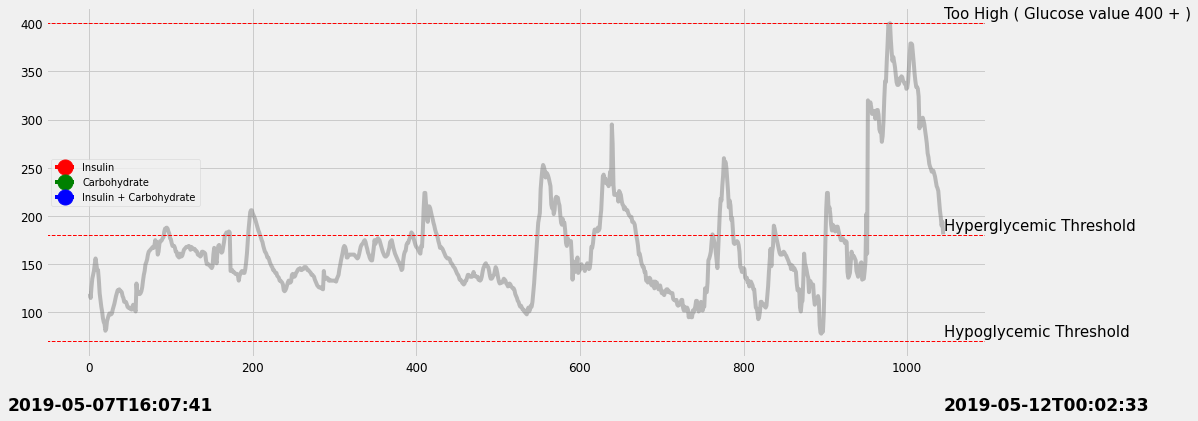

In [593]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

df.plot(figsize=(15,6),color='gray',alpha=0.5)
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.axhline(y=60,c='black',linestyle='--',linewidth=1)
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)

plt.scatter(new_insul_list,insul_glucose_value,edgecolor='black',s=50,label='Insulin',marker='o',c='red')
plt.scatter(new_meal_list,meal_glucose_value,edgecolor='black',s=50,label='Carbohydrate',marker='o',c='green')
plt.scatter(new_insul_and_meal_list,insul_and_meal_glucose_value,edgecolor='black',s=50,label='Insulin + Carbohydrate',marker='o',c='blue')

red_patch = mpatches.Patch(color='red',label='Insulin')

red_line = mlines.Line2D([],[],color='red',marker='o',markersize=15,label='Insulin')
green_line = mlines.Line2D([],[],color='green',marker='o',markersize=15,label='Carbohydrate')
blue_line = mlines.Line2D([],[],color='blue',marker='o',markersize=15,label='Insulin + Carbohydrate')
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),60,'',family='Times New Roman',size=15)
#plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])],family='Times New Roman',
#         fontweight='bold',size=20)
plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.legend(['Insulin','Carbohydrate','Insulin + Carbohydrate'],loc='best',fontsize='x-small',handles=[red_line,green_line,blue_line])
#plt.text(-100,-1,df['Timestamp'][14],family='Times New Roman',

#         fontweight='bold',size=20)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [594]:
for i in range(len(df)):
    if isNaN(df['Insulin'][i]):
        df['Insulin'][i]=1
    else:
        df['Insulin'][i]=0
        
     

In [595]:
for i in range(len(df)):
    if isNaN(df['Meal'][i]):
        df['Meal'][i]=1
    else:
        df['Meal'][i]=0
        

In [596]:
df[1900:1950]

Empty DataFrame
Columns: [Timestamp, Event, Glucose, Insulin, Meal]
Index: []

In [597]:
def fix_glucose_value(df,col):
    for i, row in df.iterrows():
        val = row[col]
        
        df.loc[i,col] = math.floor(val)

In [598]:
fix_glucose_value(df,'Glucose')

## 이제 여기부터 DL 모델 돌려볼 것 
+ 일단 모델부터 간단하게 돌려보고 성능 측정
+ 그리고 전처리 해가면서 성능 비교

In [599]:
import numpy as np
import tensorflow as tf
import random as rn

In [600]:
# 재현 가능한 결과를 만들기 위해 시드값 설정 
import os 
import random
seed_num = 42
os.environ['PYTHONHASHSEED']=str(seed_num)

random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

In [601]:
from tensorflow.compat.v1.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [602]:
#from keras import backend as K
#session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#tf.compat.v1.keras.backend.set_session(sess)


In [603]:
from sklearn.metrics import mean_squared_error
def RMSE(y_test,y_predict):
    return np.sqrt(mean_squared_error(y_test,y_predict))

In [604]:
leaky_relu = tf.nn.leaky_relu

In [605]:
def clarke_error_grid(ref_values, pred_values, title_string):

    #Checking to see if the lengths of the reference and prediction arrays are the same
    assert (len(ref_values) == len(pred_values)), "Unequal number of values (reference : {}) (prediction : {}).".format(len(ref_values), len(pred_values))

    #Checks to see if the values are within the normal physiological range, otherwise it gives a warning
    if max(ref_values) > 400 or max(pred_values) > 400:
        print ("Input Warning: the maximum reference value {} or the maximum prediction value {} exceeds the normal physiological range of glucose (<400 mg/dl).".format(max(ref_values), max(pred_values)))
    if min(ref_values) < 0 or min(pred_values) < 0:
        print ("Input Warning: the minimum reference value {} or the minimum prediction value {} is less than 0 mg/dl.".format(min(ref_values),  min(pred_values)))

    #Clear plot
    plt.clf()

    #Set up plot
    plt.scatter(ref_values, pred_values, marker='o', color='black', s=8)
    plt.title(title_string + " Clarke Error Grid")
    plt.xlabel("Reference Concentration (mg/dl)")
    plt.ylabel("Prediction Concentration (mg/dl)")
    plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.gca().set_facecolor('white')

    #Set axes lengths
    plt.gca().set_xlim([0, 400])
    plt.gca().set_ylim([0, 400])
    plt.gca().set_aspect((400)/(400))

    #Plot zone lines
    plt.plot([0,400], [0,400], ':', c='black')                      #Theoretical 45 regression line
    plt.plot([0, 175/3], [70, 70], '-', c='black')
    #plt.plot([175/3, 320], [70, 400], '-', c='black')
    plt.plot([175/3, 400/1.2], [70, 400], '-', c='black')           #Replace 320 with 400/1.2 because 100*(400 - 400/1.2)/(400/1.2) =  20% error
    plt.plot([70, 70], [84, 400],'-', c='black')
    plt.plot([0, 70], [180, 180], '-', c='black')
    plt.plot([70, 290],[180, 400],'-', c='black')
    # plt.plot([70, 70], [0, 175/3], '-', c='black')
    plt.plot([70, 70], [0, 56], '-', c='black')                     #Replace 175.3 with 56 because 100*abs(56-70)/70) = 20% error
    # plt.plot([70, 400],[175/3, 320],'-', c='black')
    plt.plot([70, 400], [56, 320],'-', c='black')
    plt.plot([180, 180], [0, 70], '-', c='black')
    plt.plot([180, 400], [70, 70], '-', c='black')
    plt.plot([240, 240], [70, 180],'-', c='black')
    plt.plot([240, 400], [180, 180], '-', c='black')
    plt.plot([130, 180], [0, 70], '-', c='black')

    #Add zone titles
    plt.text(30, 15, "A", fontsize=15)
    plt.text(370, 260, "B", fontsize=15)
    plt.text(280, 370, "B", fontsize=15)
    plt.text(160, 370, "C", fontsize=15)
    plt.text(160, 15, "C", fontsize=15)
    plt.text(30, 140, "D", fontsize=15)
    plt.text(370, 120, "D", fontsize=15)
    plt.text(30, 370, "E", fontsize=15)
    plt.text(370, 15, "E", fontsize=15)

    #Statistics from the data
    zone = [0] * 5
    for i in range(len(ref_values)):
        if (ref_values[i] <= 70 and pred_values[i] <= 70) or (pred_values[i] <= 1.2*ref_values[i] and pred_values[i] >= 0.8*ref_values[i]):
            zone[0] += 1    #Zone A

        elif (ref_values[i] >= 180 and pred_values[i] <= 70) or (ref_values[i] <= 70 and pred_values[i] >= 180):
            zone[4] += 1    #Zone E

        elif ((ref_values[i] >= 70 and ref_values[i] <= 290) and pred_values[i] >= ref_values[i] + 110) or ((ref_values[i] >= 130 and ref_values[i] <= 180) and (pred_values[i] <= (7/5)*ref_values[i] - 182)):
            zone[2] += 1    #Zone C
        elif (ref_values[i] >= 240 and (pred_values[i] >= 70 and pred_values[i] <= 180)) or (ref_values[i] <= 175/3 and pred_values[i] <= 180 and pred_values[i] >= 70) or ((ref_values[i] >= 175/3 and ref_values[i] <= 70) and pred_values[i] >= (6/5)*ref_values[i]):
            zone[3] += 1    #Zone D
        else:
            zone[1] += 1    #Zone B

    return plt, zone

## 15분

In [606]:
def uni_data(dataset,start_index,end_index, history_size, target_size):
    data=[]
    labels=[]
    
    start_index= start_index+history_size
    if end_index is None:
    #if end_index > len(dataset)-1:
        end_index = len(dataset)-target_size
        
    for i in range(start_index,end_index):
        indices = range(i-history_size,i)
        
        data.append(np.reshape(dataset[indices],(history_size,1)))
        #data.append(np.reshape(dataset[indices],(history_size)))
        labels.append(dataset[i+target_size])
    return np.array(data),np.array(labels)

In [607]:
raw_seq = df['Glucose']
raw_seq=raw_seq.to_numpy(dtype='int64')

In [608]:
len(raw_seq) * 0.7

731.5

In [609]:
# SG필터 테스트 
#import scipy.signal 

#yhat = scipy.signal.savgol_filter(raw_seq,15,5)
#plt.plot(raw_seq)
#plt.plot(yhat,color='red')
#plt.show()

In [610]:
# SG필터 적용하는 부분 
# x_train_uni_origin 이런 식이었음 
#TRAIN_SPLIT=int(len(raw_seq)*0.7)
#uni_past_history=6
#uni_future_target=2 # 이거 -1이면 naive method 
#x_train_uni,y_train_uni = uni_data(,0,TRAIN_SPLIT,
#                                  uni_past_history,
#                                  uni_future_target)
#x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
#                            uni_past_history,
#                            uni_future_target)

In [611]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=2 # 이거 -1이면 naive method 
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [612]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=2 # 이거 -1이면 naive method 
x_train_uni,y_train_uni = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [613]:
y_val_uni.shape

(306,)

In [614]:
y_train_uni.shape

(725,)

In [615]:
#y_train_uni_origin[:10]

In [616]:
#y_train_uni.shape
df[:15]

Timestamp Event  Glucose  Insulin  Meal
0   2019-05-07T16:07:41    교정    120.0      0.0   0.0
1   2019-05-07T16:07:54    교정    120.0      0.0   0.0
2   2019-05-07T16:12:56   EGV    115.0      0.0   0.0
3   2019-05-07T16:17:47   EGV    126.0      0.0   0.0
4   2019-05-07T16:22:47   EGV    135.0      0.0   0.0
5   2019-05-07T16:27:48   EGV    139.0      0.0   0.0
6   2019-05-07T16:32:48   EGV    143.0      0.0   0.0
7   2019-05-07T16:37:48   EGV    150.0      0.0   0.0
8   2019-05-07T16:42:48   EGV    156.0      0.0   0.0
9   2019-05-07T16:47:47   EGV    150.0      0.0   0.0
10  2019-05-07T16:52:48   EGV    144.0      0.0   0.0
11  2019-05-07T16:57:47   EGV    144.0      0.0   0.0
12  2019-05-07T17:02:47   EGV    134.0      0.0   0.0
13  2019-05-07T17:07:47   EGV    120.0      0.0   0.0
14  2019-05-07T17:12:47   EGV    113.0      0.0   0.0

In [617]:
x_train_uni[5:10]

array([[[139],
        [143],
        [150],
        [156],
        [150],
        [144]],

       [[143],
        [150],
        [156],
        [150],
        [144],
        [144]],

       [[150],
        [156],
        [150],
        [144],
        [144],
        [134]],

       [[156],
        [150],
        [144],
        [144],
        [134],
        [120]],

       [[150],
        [144],
        [144],
        [134],
        [120],
        [113]]])

In [618]:
y_train_uni[5:10]

array([120, 113, 106, 101,  94])

In [619]:
#df['Glucose'].head(10)

In [620]:
x_train_uni.shape[-2:]

(6, 1)

### RNN - 15분

In [621]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [622]:
from keras.layers import SimpleRNN

In [623]:
#n_steps = 3
#delay=3
#n_features=1

In [624]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [625]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_uni.shape[-2:],return_sequences=False)) #recurrent_dropout=0.2
model.add(Dense(1))

In [626]:
model.compile(optimizer='adam',loss='mse')
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)
K.clear_session()


In [627]:
val_rnn_15_predict_result = model.predict(x_val_uni,verbose=0)

In [628]:
# 예측값 상한선 = 400 
for i in range(len(val_rnn_15_predict_result)):
    if val_rnn_15_predict_result[i] >= 400: 
        val_rnn_15_predict_result[i]=400
    elif val_rnn_15_predict_result[i] <=60:
      val_rnn_15_predict_result[i] = 60
# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,val_rnn_15_predict_result))
val_rnn_15 = RMSE(y_val_uni_origin,val_rnn_15_predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  27.35696944952124


In [629]:
get_x_train_origin_15 = np.array(y_train_uni_origin)

In [630]:
get_x_train_origin_15 = get_x_train_origin_15.reshape(1,len(y_train_uni_origin))

In [631]:
get_x_train_origin_15.shape

(1, 725)

In [632]:
get_y_val_origin_15 = np.array(y_val_uni_origin)

In [633]:
get_y_val_origin_15 = get_y_val_origin_15.reshape(1,len(get_y_val_origin_15))

In [634]:
get_y_val_origin_15.shape

(1, 306)

In [635]:
#get_y_val_origin

In [636]:
get_val_rnn_15_predict_result = np.array(val_rnn_15_predict_result)

In [637]:
get_val_rnn_15_predict_result = get_val_rnn_15_predict_result.T

In [638]:
get_val_rnn_15_predict_result.shape

(1, 306)

In [639]:
#ar_15=np.concatenate((get_y_val_origin, get_val_rnn_15_predict_result), axis = 0)


In [640]:
#y=pd.DataFrame(ar,index=['15_val_origin','15_rnn'])
#y
#y.append(get_val_rnn_15_predict_result,ignore_index=True)

In [641]:
#get_val_rnn_15_pedict_result =get_val_rnn_15_pedict_result.reshape(1,len(get_val_rnn_15_pedict_result))

In [642]:
get_val_rnn_15_predict_result.shape

(1, 306)

#### Validation

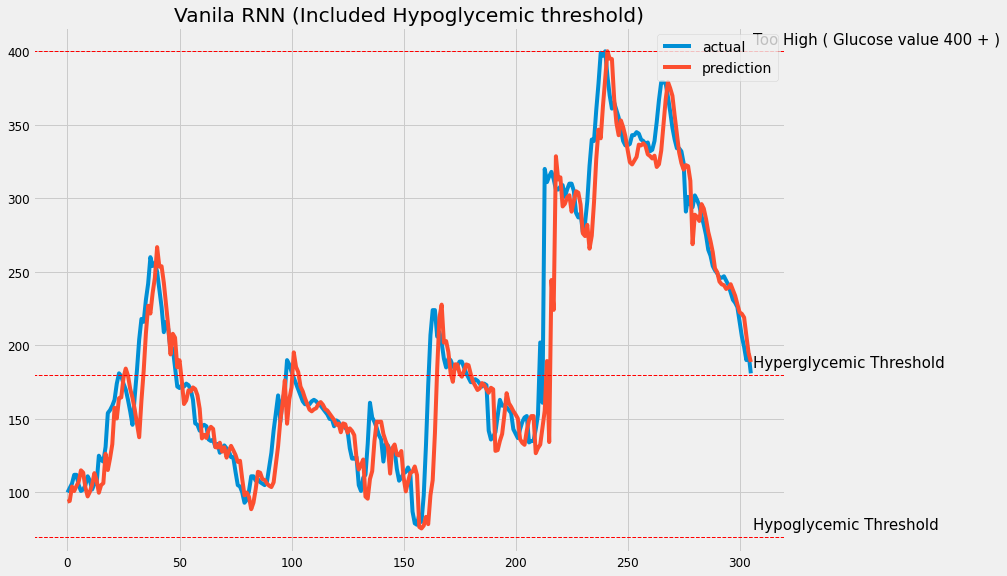

In [643]:
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_rnn_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_rnn_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_rnn_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_rnn_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Vanila RNN (Included Hypoglycemic threshold)',family='Times New Roman')
plt.legend()
plt.show()

In [644]:
val_rnn_15_predict_result

array([[ 93.75557 ],
       [ 94.22483 ],
       [104.014435],
       [100.95176 ],
       [104.39825 ],
       [107.40211 ],
       [115.03252 ],
       [113.527916],
       [103.30709 ],
       [ 97.313354],
       [100.47952 ],
       [105.5155  ],
       [113.151985],
       [108.25519 ],
       [ 99.79448 ],
       [104.9788  ],
       [106.33968 ],
       [126.2891  ],
       [115.274   ],
       [123.29109 ],
       [132.816   ],
       [157.59883 ],
       [150.29764 ],
       [164.17126 ],
       [164.59586 ],
       [177.99095 ],
       [184.25215 ],
       [179.50255 ],
       [170.34932 ],
       [164.53935 ],
       [156.47057 ],
       [147.20927 ],
       [137.5465  ],
       [162.33232 ],
       [182.54158 ],
       [208.26492 ],
       [226.94992 ],
       [221.66206 ],
       [235.559   ],
       [246.00362 ],
       [266.83566 ],
       [253.55917 ],
       [253.80556 ],
       [242.56427 ],
       [227.2038  ],
       [212.60818 ],
       [193.86023 ],
       [207.8

In [645]:
len(val_rnn_15_predict_result)

306

In [646]:
y_val_uni_origin

array([100, 103, 106, 112, 112, 105, 101, 102, 105, 111, 108, 102, 106,
       106, 125, 122, 121, 131, 154, 156, 159, 163, 174, 181, 179, 174,
       170, 163, 155, 146, 165, 183, 204, 218, 216, 231, 242, 260, 254,
       256, 250, 238, 226, 209, 216, 211, 196, 198, 185, 172, 171, 173,
       172, 174, 173, 170, 163, 147, 146, 142, 145, 146, 145, 136, 135,
       136, 131, 133, 127, 130, 132, 130, 128, 124, 124, 114, 105, 104,
       100,  93,  95, 101, 111, 111, 108, 109, 107, 106, 105, 107, 117,
       127, 142, 154, 166, 148, 163, 169, 190, 187, 182, 178, 174, 170,
       166, 162, 160, 160, 160, 162, 163, 162, 160, 159, 157, 155, 153,
       150, 150, 145, 149, 148, 144, 146, 144, 142, 130, 123, 123, 124,
       105, 101, 110, 112, 133, 161, 151, 148, 144, 139, 136, 121, 133,
       132, 128, 128, 129, 116, 108, 110, 113, 114, 117, 113,  87,  79,
        78,  85,  80,  98, 132, 173, 207, 224, 224, 206, 209, 202, 191,
       185, 191, 190, 186, 184, 186, 189, 189, 185, 181, 178, 17

In [647]:
## test 


In [648]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

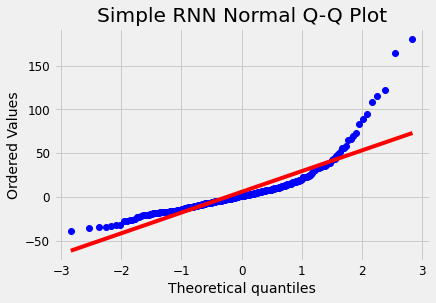

In [649]:
residuals = [y_val_uni_origin[i]-val_rnn_15_predict_result[i] for i in range(len(val_rnn_15_predict_result))]
residuals = y_val_uni_origin - val_rnn_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

#### 잔차

Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

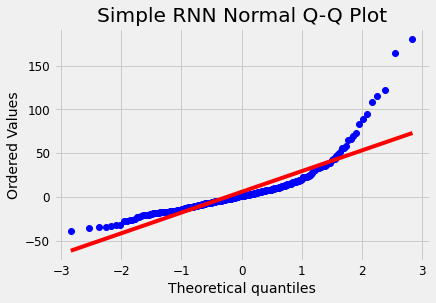

In [650]:
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

In [651]:
residuals=DataFrame(residuals)

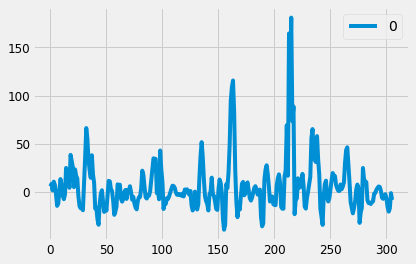

In [652]:
residuals.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f91a847d450>]],
      dtype=object)

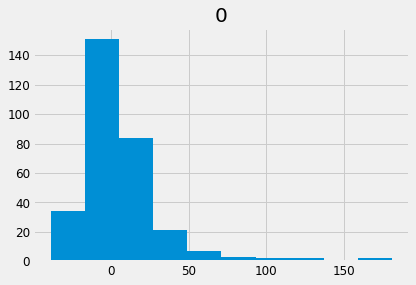

In [653]:

residuals.hist()

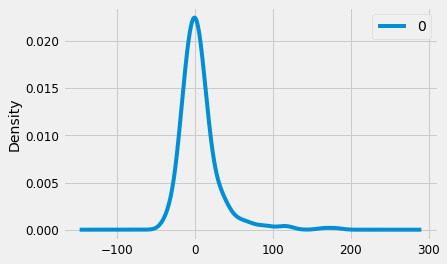

In [654]:
residuals.plot(kind='kde')

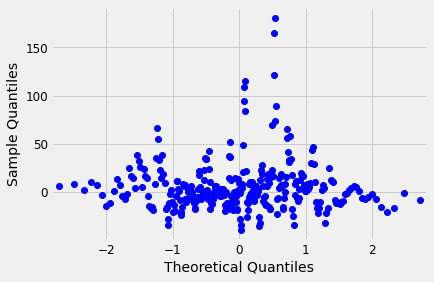

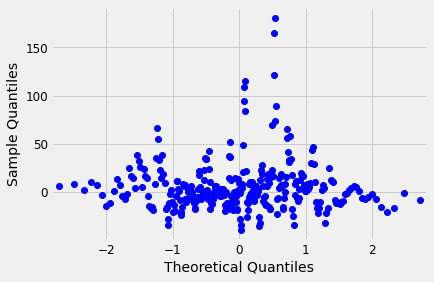

In [655]:
from statsmodels.graphics.gofplots import qqplot
residuals=np.array(residuals)
qqplot(residuals)

In [656]:
# 트레이닝셋 rmse 구하는 부분 
train_rnn_15_predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(train_rnn_15_predict_result)):
    if train_rnn_15_predict_result[i] >= 400: 
        train_rnn_15_predict_result[i]=400  
    elif train_rnn_15_predict_result[i] <= 60: 
        train_rnn_15_predict_result[i]=60             
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,train_rnn_15_predict_result))
train_rnn_15=RMSE(y_train_uni_origin,train_rnn_15_predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  10.585691579585541


In [657]:
get_train_rnn_15_predict_result = np.array(train_rnn_15_predict_result)

In [658]:
get_train_rnn_15_predict_result = get_train_rnn_15_predict_result.T

In [659]:
get_train_rnn_15_predict_result.shape

(1, 725)

#### Train

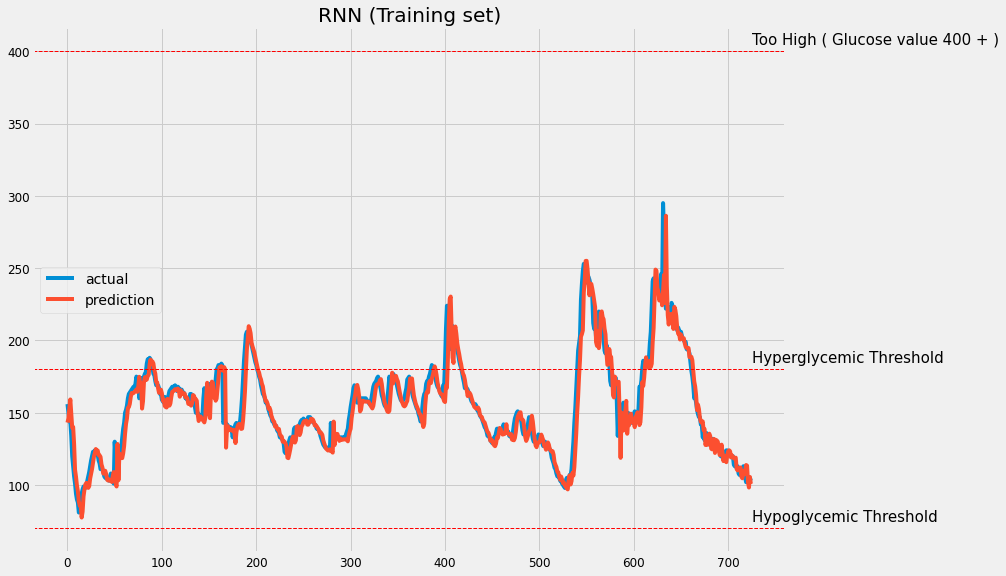

In [660]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(train_rnn_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_rnn_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

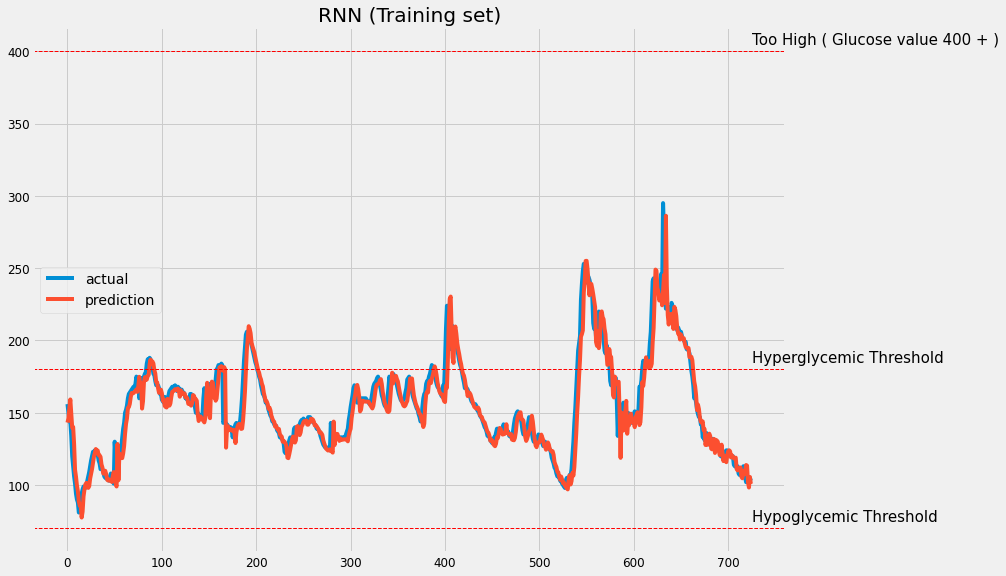

In [661]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(train_rnn_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_rnn_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

### LSTM - 15분

In [662]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [663]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_uni.shape[-2:])) #recurrent_dropout=0.2, unit_forget_bias=False
model.add(Dense(1))


In [664]:
model.compile(optimizer='adam',loss='mse')
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)
K.clear_session()
val_lstm_15_predict_result = model.predict(x_val_uni,verbose=0)

In [665]:
# 예측값 상한선 = 400 
for i in range(len(val_lstm_15_predict_result)):
    if val_lstm_15_predict_result[i] >= 400: 
        val_lstm_15_predict_result[i]=400
    if val_lstm_15_predict_result[i] <= 60: 
        val_lstm_15_predict_result[i]=60
print(' LSTM - RMSE (15min) : ',RMSE(y_val_uni_origin,val_lstm_15_predict_result))
val_lstm_15=RMSE(y_val_uni_origin,val_lstm_15_predict_result)

 LSTM - RMSE (15min) :  27.25268189249051


In [666]:
get_val_lstm_15_predict_result = np.array(val_lstm_15_predict_result)

In [667]:
get_val_lstm_15_predict_result = get_val_lstm_15_predict_result.T

In [668]:
get_val_lstm_15_predict_result.shape

(1, 306)

In [669]:
val_lstm_15_predict_result

array([[ 92.68593 ],
       [ 94.26187 ],
       [106.524376],
       [100.43443 ],
       [103.12489 ],
       [107.5062  ],
       [116.11124 ],
       [114.97447 ],
       [105.90272 ],
       [ 95.03731 ],
       [102.5022  ],
       [ 99.46292 ],
       [110.34523 ],
       [110.038345],
       [100.097206],
       [105.797775],
       [102.21241 ],
       [133.64719 ],
       [127.21777 ],
       [123.238495],
       [134.43434 ],
       [172.83557 ],
       [163.36206 ],
       [162.08992 ],
       [165.26042 ],
       [178.28056 ],
       [181.60565 ],
       [176.16933 ],
       [172.61511 ],
       [168.13445 ],
       [160.81738 ],
       [152.06944 ],
       [143.09888 ],
       [158.12547 ],
       [186.50795 ],
       [207.84596 ],
       [221.54631 ],
       [212.92145 ],
       [231.9075  ],
       [241.30777 ],
       [258.66077 ],
       [235.32791 ],
       [235.40216 ],
       [233.01535 ],
       [233.83218 ],
       [229.1817  ],
       [219.5481  ],
       [217.1

In [670]:
TRAIN_SPLIT

731

#### 잔차

Text(0.5, 1.0, 'LSTM Normal Q-Q Plot')

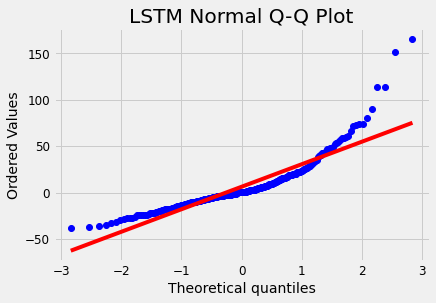

In [671]:
residuals = [y_val_uni_origin[i]-val_lstm_15_predict_result[i] for i in range(len(val_lstm_15_predict_result))]
residuals = y_val_uni_origin - val_lstm_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Normal Q-Q Plot")

#### Validation

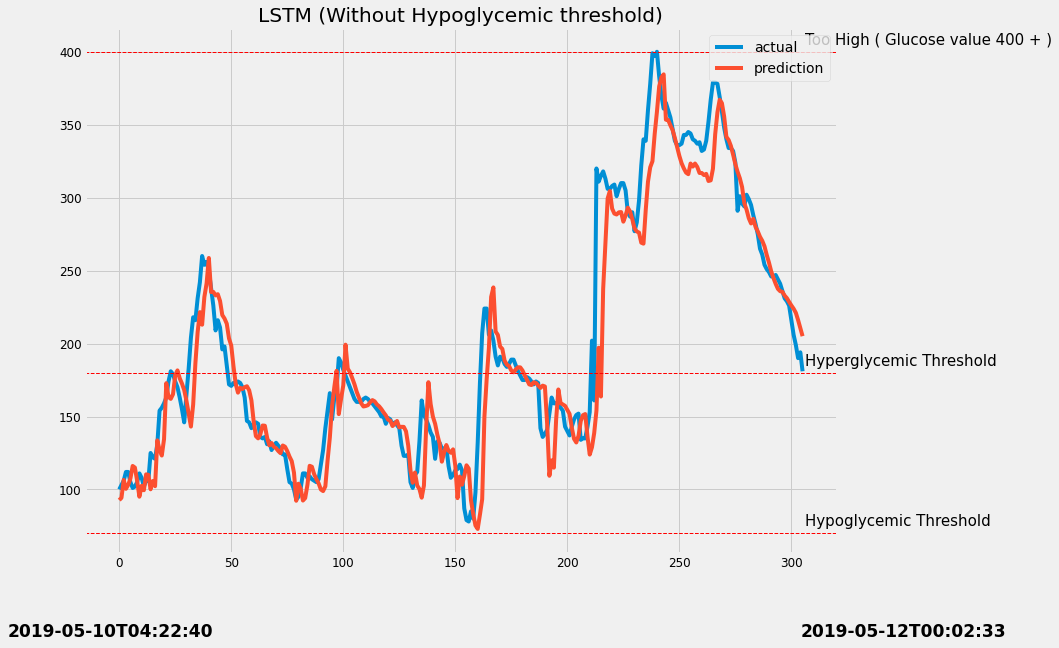

In [672]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_lstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_lstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_lstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_lstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Without Hypoglycemic threshold)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [673]:
# 트레이닝셋 RMSE 계산 
train_lstm_15_predict_result = model.predict(x_train_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(train_lstm_15_predict_result)):
    if train_lstm_15_predict_result[i] >= 400: 
        train_lstm_15_predict_result[i]=400
    elif train_lstm_15_predict_result[i] <= 60: 
        train_lstm_15_predict_result[i]=60
print(' LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,train_lstm_15_predict_result))
train_lstm_15 =RMSE(y_train_uni_origin,train_lstm_15_predict_result)

 LSTM - RMSE (15min) Training set :  10.846088896707613


In [674]:
get_train_lstm_15_predict_result = np.array(train_lstm_15_predict_result)

In [675]:
get_train_lstm_15_predict_result = get_train_lstm_15_predict_result.T

In [676]:
get_train_lstm_15_predict_result.shape

(1, 725)

#### Train

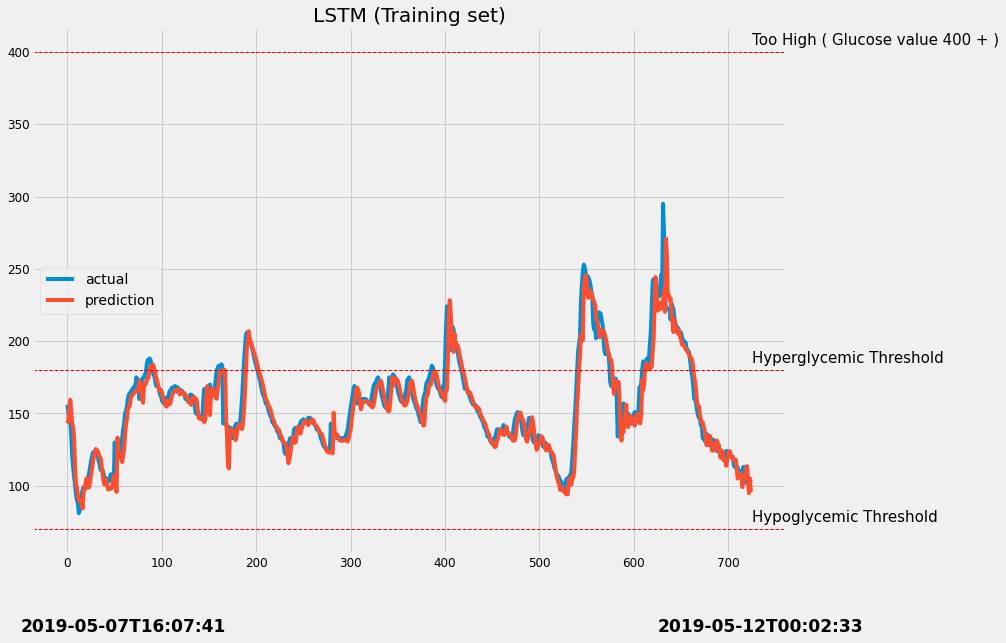

In [677]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(train_lstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_lstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_lstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_lstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Training set)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(train_lstm_15_predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 15분

In [678]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [679]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_uni.shape[-2:]))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [680]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [681]:
K.clear_session()

In [682]:
val_slstm_15_predict_result = model.predict(x_val_uni,verbose=0)


In [683]:
for i in range(len(val_slstm_15_predict_result)):
    if val_slstm_15_predict_result[i] >= 400: 
        val_slstm_15_predict_result[i]=400
    elif val_slstm_15_predict_result[i] <= 60: 
        val_slstm_15_predict_result[i]=60

In [684]:
get_val_slstm_15_predict_result = np.array(val_slstm_15_predict_result)

In [685]:
get_val_slstm_15_predict_result = get_val_slstm_15_predict_result.T

In [686]:
get_val_slstm_15_predict_result.shape

(1, 306)

In [687]:
val_slstm_15_predict_result

array([[ 94.48503 ],
       [ 95.33442 ],
       [105.57557 ],
       [100.32656 ],
       [104.41223 ],
       [107.97164 ],
       [118.59842 ],
       [113.25596 ],
       [105.00709 ],
       [ 96.440285],
       [101.93323 ],
       [100.394485],
       [113.101974],
       [108.93369 ],
       [ 99.810265],
       [109.05466 ],
       [105.39498 ],
       [133.32332 ],
       [127.72782 ],
       [121.553795],
       [146.41655 ],
       [189.26958 ],
       [168.29433 ],
       [158.72244 ],
       [160.69229 ],
       [188.7169  ],
       [186.48291 ],
       [169.77708 ],
       [165.70538 ],
       [162.10402 ],
       [154.24916 ],
       [144.66035 ],
       [135.2175  ],
       [154.06464 ],
       [192.2244  ],
       [208.06479 ],
       [223.14774 ],
       [201.33237 ],
       [244.99965 ],
       [251.70213 ],
       [264.8717  ],
       [222.13718 ],
       [269.11002 ],
       [230.6437  ],
       [225.12276 ],
       [212.46495 ],
       [201.12912 ],
       [213.1

In [688]:
print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,val_slstm_15_predict_result))
val_stacklstm_15 =RMSE(y_val_uni_origin,val_slstm_15_predict_result)

 Stacked LSTM - RMSE(15min) :  28.97227456765468


#### Validation

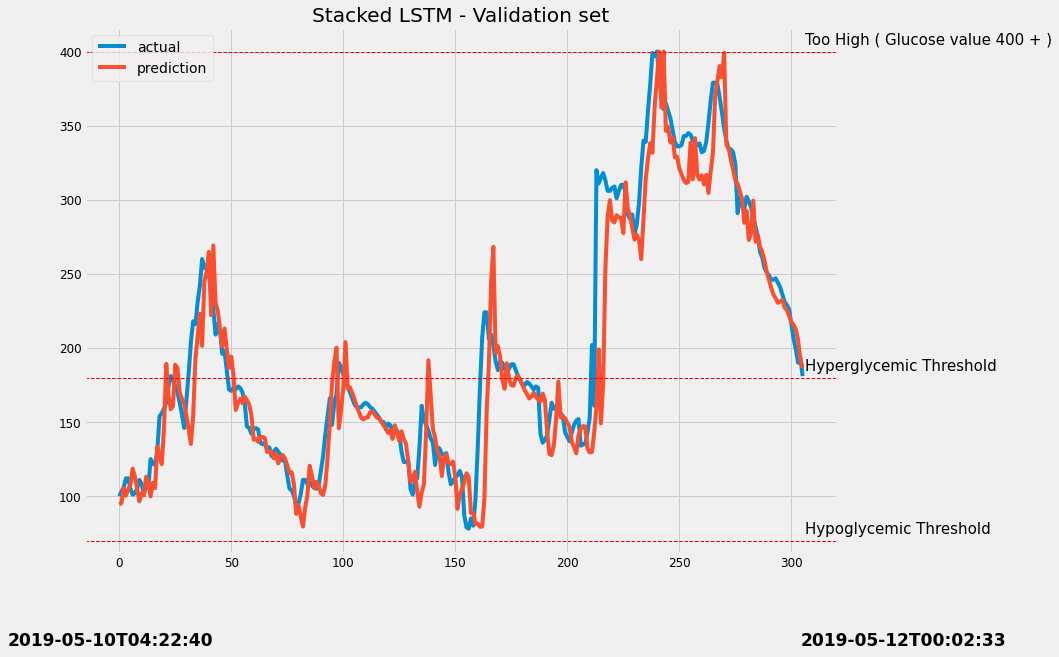

In [689]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_slstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_slstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_slstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(val_slstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_slstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Normal Q-Q Plot')

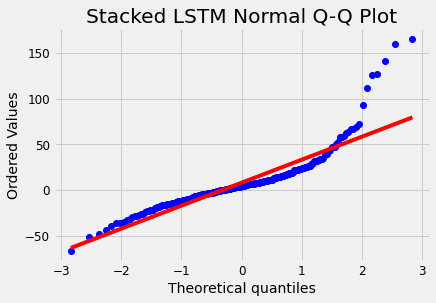

In [690]:
residuals = [y_val_uni[i]-val_slstm_15_predict_result[i] for i in range(len(val_slstm_15_predict_result))]
residuals = y_val_uni - val_slstm_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Normal Q-Q Plot")

In [691]:
# 트레이닝셋 RMSE 계산 
train_slstm_15_predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(train_slstm_15_predict_result)):
    if train_slstm_15_predict_result[i] >= 400: 
        train_slstm_15_predict_result[i]=400
    elif train_slstm_15_predict_result[i] <= 60: 
        train_slstm_15_predict_result[i]=60
print(' Training set / STACKED LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,train_slstm_15_predict_result))
train_stacklstm_15 = RMSE(y_train_uni_origin,train_slstm_15_predict_result)

 Training set / STACKED LSTM - RMSE (15min) Training set :  10.614771994835575


In [692]:
get_train_slstm_15_predict_result = np.array(train_slstm_15_predict_result)

In [693]:
get_train_slstm_15_predict_result = get_train_slstm_15_predict_result.T

In [694]:
get_train_slstm_15_predict_result.shape

(1, 725)

#### Train

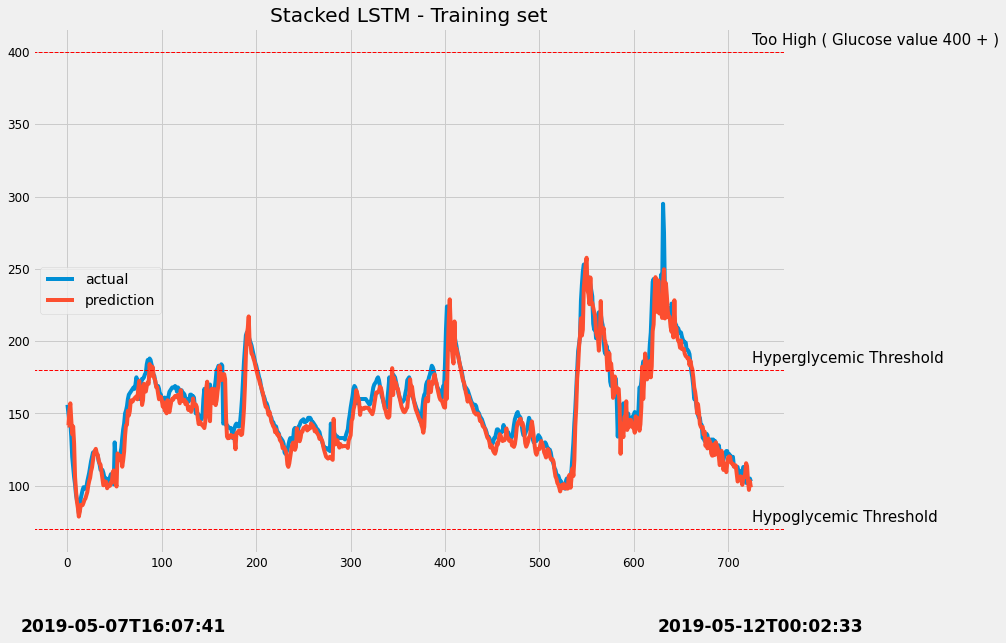

In [695]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(train_slstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_slstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_slstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_slstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(train_slstm_15_predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 15분

In [696]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [697]:
from keras.layers import Bidirectional

model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [698]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [699]:
K.clear_session()

In [700]:
val_bilstm_15_predict_result = model.predict(x_val_uni,verbose=0)

In [701]:
for i in range(len(val_bilstm_15_predict_result)):
    if val_bilstm_15_predict_result[i] >= 400: 
        val_bilstm_15_predict_result[i]=400
    elif val_bilstm_15_predict_result[i] <= 60: 
        val_bilstm_15_predict_result[i]=60

In [702]:
get_val_bilstm_15_predict_result = np.array(val_bilstm_15_predict_result)

In [703]:
get_val_bilstm_15_predict_result = get_val_bilstm_15_predict_result.T

In [704]:
get_val_bilstm_15_predict_result.shape

(1, 306)

In [705]:
val_bilstm_15_predict_result

array([[ 98.36682 ],
       [ 98.626335],
       [108.03423 ],
       [104.67399 ],
       [109.31557 ],
       [112.200966],
       [120.2686  ],
       [116.999985],
       [110.56222 ],
       [104.509224],
       [103.48015 ],
       [106.87462 ],
       [115.615715],
       [111.835915],
       [106.9654  ],
       [108.97856 ],
       [108.08684 ],
       [130.24306 ],
       [126.14754 ],
       [129.83334 ],
       [140.11739 ],
       [168.69934 ],
       [163.60349 ],
       [170.09271 ],
       [180.08803 ],
       [186.7588  ],
       [182.75227 ],
       [175.34744 ],
       [169.6997  ],
       [165.02855 ],
       [159.81497 ],
       [153.73227 ],
       [145.6183  ],
       [167.79784 ],
       [189.03125 ],
       [210.02205 ],
       [231.80185 ],
       [259.54916 ],
       [255.40831 ],
       [245.62416 ],
       [269.4944  ],
       [241.99538 ],
       [246.78816 ],
       [237.59962 ],
       [229.26643 ],
       [222.8991  ],
       [210.83504 ],
       [202.2

In [706]:
print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,val_bilstm_15_predict_result))
val_bilstm_15 = RMSE(y_val_uni_origin,val_bilstm_15_predict_result)

Bidirectional LSTM - RMSE :  28.63567261653044


#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Normal Q-Q Plot')

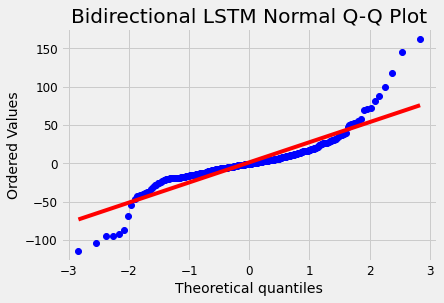

In [707]:
residuals = [y_val_uni[i]-val_bilstm_15_predict_result[i] for i in range(len(val_bilstm_15_predict_result))]
residuals = y_val_uni - val_bilstm_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Normal Q-Q Plot")

#### Validation

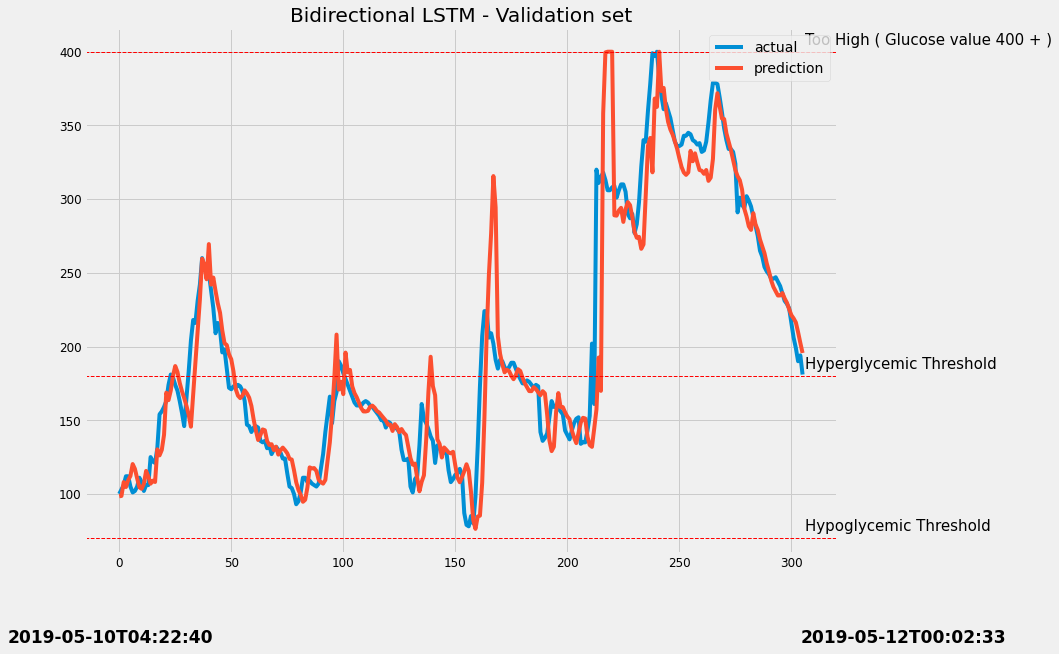

In [708]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_bilstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_bilstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_bilstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_bilstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [709]:
# 트레이닝셋 RMSE 계산 
train_bilstm_15_predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(train_bilstm_15_predict_result)):
    if train_bilstm_15_predict_result[i] >= 400: 
        train_bilstm_15_predict_result[i]=400
    elif train_bilstm_15_predict_result[i] <= 60: 
        train_bilstm_15_predict_result[i]=60
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,train_bilstm_15_predict_result))
train_bilstm_15 = RMSE(y_train_uni_origin,train_bilstm_15_predict_result)

 Training set / Bidirectional LSTM - RMSE (60min) Training set :  10.27171496874602


In [710]:
get_train_bilstm_15_predict_result = np.array(train_bilstm_15_predict_result)

In [711]:
get_train_bilstm_15_predict_result = get_train_bilstm_15_predict_result.T

In [712]:
get_train_bilstm_15_predict_result.shape

(1, 725)

#### Train

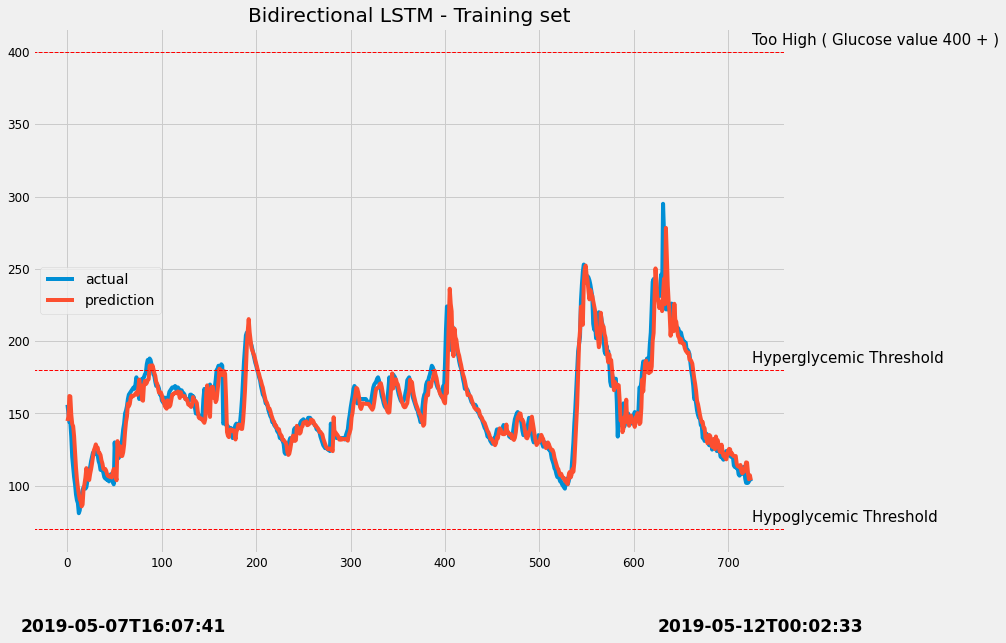

In [713]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(train_bilstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_bilstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_bilstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_bilstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(train_bilstm_15_predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 15분

In [714]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [715]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [716]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [717]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [718]:
K.clear_session()

In [719]:
val_gru_15_predict_result = model.predict(x_val_uni,verbose=0)

In [720]:
for i in range(len(val_gru_15_predict_result)):
    if val_gru_15_predict_result[i] >= 400: 
        val_gru_15_predict_result[i]=400
    if val_gru_15_predict_result[i] <= 60: 
        val_gru_15_predict_result[i]=60

In [721]:
get_val_gru_15_predict_result = np.array(val_gru_15_predict_result)

In [722]:
get_val_gru_15_predict_result = get_val_gru_15_predict_result.T

In [723]:
get_val_gru_15_predict_result.shape

(1, 306)

In [724]:
val_gru_15_predict_result

array([[ 98.60689 ],
       [ 99.72646 ],
       [109.433685],
       [107.92088 ],
       [110.733986],
       [114.02197 ],
       [120.82809 ],
       [120.493774],
       [112.71771 ],
       [104.59786 ],
       [104.37956 ],
       [107.570526],
       [115.74847 ],
       [114.89068 ],
       [108.33002 ],
       [110.626   ],
       [110.78468 ],
       [131.12189 ],
       [131.97575 ],
       [130.8021  ],
       [138.55217 ],
       [165.00598 ],
       [167.00444 ],
       [167.64052 ],
       [170.13474 ],
       [178.83301 ],
       [184.85966 ],
       [181.04256 ],
       [172.60216 ],
       [165.99413 ],
       [157.49973 ],
       [148.48857 ],
       [138.61714 ],
       [160.65033 ],
       [187.6658  ],
       [212.62994 ],
       [230.20403 ],
       [225.98312 ],
       [235.14928 ],
       [240.90569 ],
       [256.584   ],
       [248.2587  ],
       [247.21115 ],
       [241.4179  ],
       [229.80222 ],
       [216.06567 ],
       [199.91595 ],
       [207.8

In [725]:
#predict_result

In [726]:
#predict_result

In [727]:

print('GRU - RMSE 15min : ',RMSE(y_val_uni_origin,val_gru_15_predict_result))
val_gru_15 = RMSE(y_val_uni_origin,val_gru_15_predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  25.27280569637824


#### 잔차

Text(0.5, 1.0, 'GRU Normal Q-Q Plot')

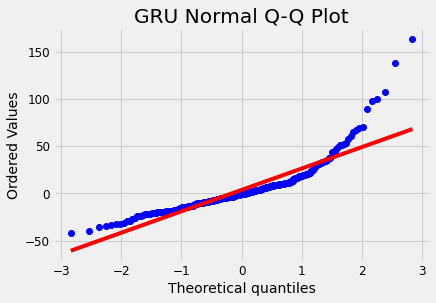

In [728]:
residuals = [y_val_uni[i]-val_gru_15_predict_result[i] for i in range(len(val_gru_15_predict_result))]
residuals = y_val_uni - val_gru_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Normal Q-Q Plot")

#### Validation

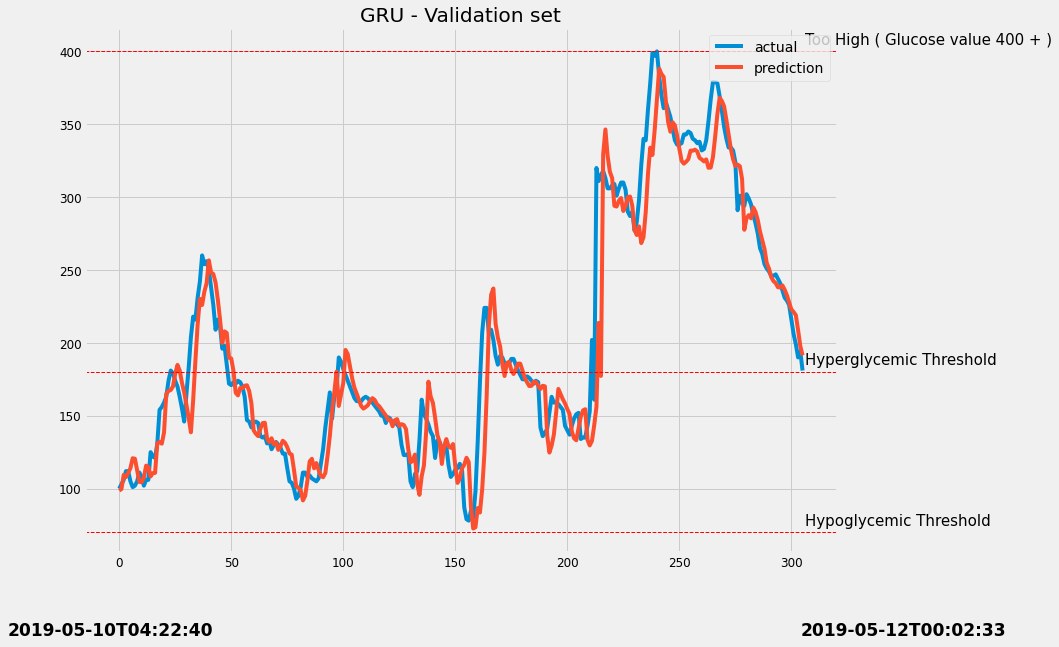

In [729]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_gru_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_gru_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_gru_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_gru_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [730]:
# 트레이닝셋 RMSE 계산 

train_gru_15_predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(train_gru_15_predict_result)):
    if train_gru_15_predict_result[i] >= 400: 
        train_gru_15_predict_result[i]=400
print(' Training set / GRU - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,train_gru_15_predict_result))
train_gru_15 =RMSE(y_train_uni_origin,train_gru_15_predict_result)

 Training set / GRU - RMSE (15min) Training set :  10.584746009711202


In [731]:
get_train_gru_15_predict_result = np.array(train_gru_15_predict_result)

In [732]:
get_train_gru_15_predict_result = get_train_gru_15_predict_result.T

In [733]:
get_train_gru_15_predict_result.shape

(1, 725)

#### Train

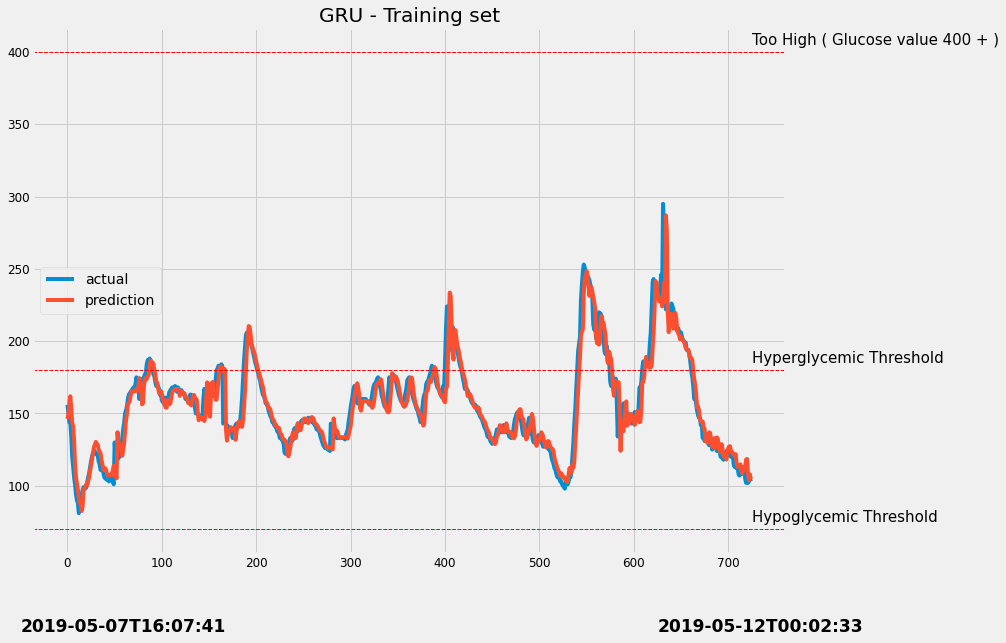

In [734]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(train_gru_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_gru_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_gru_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_gru_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(train_gru_15_predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

In [735]:
#from pandas import DataFrame
#residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
#residuals=DataFrame(residuals)
#residuals.hist()

In [736]:
#residuals.plot(kind='kde')

In [737]:
#residuals.plot()

In [738]:
#from statsmodels.graphics.gofplots import qqplot
#residuals=np.array(residuals)
#qqplot(residuals)

### Genetic Algorithm - 15Min

In [739]:
pip install geneticalgorithm2

     |████████████████████████████████| 51kB 6.4MB/s 
  Created wheel for func-timeout: filename=func_timeout-4.3.5-cp37-none-any.whl size=15079 sha256=3ca10061e77147615d1b5356acdc1c2dd5679830e6b9cab62d706f9b856e31c2
  Stored in directory: /root/.cache/pip/wheels/46/7c/4f/24f1d2d5bbff92219debe7ea19af84f76ddeb90dd4ec544f26
Successfully built func-timeout


In [740]:
from geneticalgorithm2 import geneticalgorithm2 as ga # for creating and running optimization model

from geneticalgorithm2 import Crossover, Mutations, Selection # classes for specific mutation and crossover behavior

from geneticalgorithm2 import Population_initializer # for creating better start population

from geneticalgorithm2 import np_lru_cache # for cache function (if u want)

from geneticalgorithm2 import plot_pop_scores # for plotting population scores, if u want

from geneticalgorithm2 import Callbacks # simple callbacks

from geneticalgorithm2 import Actions, ActionConditions, MiddleCallbacks # middle callbacks

In [741]:
val_rnn_15 = round(val_rnn_15,2)
val_lstm_15 = round(val_lstm_15,2)
val_stacklstm_15 = round(val_stacklstm_15,2)
val_bilstm_15 = round(val_bilstm_15,2)
val_gru_15 = round(val_gru_15,2)


In [742]:
train_rnn_15 = round(train_rnn_15,2)
train_lstm_15 = round(train_lstm_15,2)
train_stacklstm_15 = round(train_stacklstm_15,2)
train_bilstm_15 = round(train_bilstm_15,2)
train_gru_15 = round(train_gru_15,2)


In [743]:
#val_rnn_15_predict_result[:5]

In [744]:
#ex = val_rnn_15_predict_result * 0.2 + val_lstm_15_predict_result * 0.2 + val_slstm_15_predict_result * 0.2 + val_bilstm_15_predict_result * 0.2 + val_gru_15_predict_result * 0.2

In [745]:
#ex = val_rnn_15_predict_result * 0.3 + val_lstm_15_predict_result * 0.1 + val_slstm_15_predict_result * 0.14 + val_bilstm_15_predict_result * 0.11 + val_gru_15_predict_result * 0.35

In [746]:
# Baseline
#test_result = RMSE(y_val_uni_origin,ex)
#test_result

In [747]:
#test_result = 200 - RMSE(y_val_uni_origin,ex)
#test_result = 200 - RMSE(val_rnn_15_predict_result * 0.2 + val_lstm_15_predict_result * 0.2 + val_slstm_15_predict_result * 0.2 + val_bilstm_15_predict_result * 0.2 + val_gru_15_predict_result * 0.2,ex)


In [748]:
train_rnn_15_predict_result = np.asarray(train_rnn_15_predict_result)
train_lstm_15_predict_result = np.asarray(train_lstm_15_predict_result)
train_slstm_15_predict_result = np.asarray(train_slstm_15_predict_result)
train_bilstm_15_predict_result = np.asarray(train_bilstm_15_predict_result)
train_gru_15_predict_result = np.asarray(train_gru_15_predict_result)

In [749]:
val_rnn_15_predict_result = np.asarray(val_rnn_15_predict_result)
val_lstm_15_predict_result = np.asarray(val_lstm_15_predict_result)
val_slstm_15_predict_result = np.asarray(val_slstm_15_predict_result)
val_bilstm_15_predict_result = np.asarray(val_bilstm_15_predict_result)
val_gru_15_predict_result = np.asarray(val_gru_15_predict_result)

In [750]:
def evaluate2(X):
  pen = 0 
  #coef = [0,0,0,0,0]
  ab=0
  result =0
  #result2 = 0
  #print(X)
  if sum(X) > 0.99 and sum(X) < 1:
    #print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    #result = mean_squared_error((y_val_uni_origin,(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +
    #             val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] +
    #             val_gru_30_predict_result * X[4]))**0.5)
   # ab = val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4]
   # print("\n ** A ** \n")
   # print(ab.shape)
    result = 30 - np.sqrt(mean_squared_error(train_rnn_15_predict_result * X[0] + train_lstm_15_predict_result * X[1] +train_slstm_15_predict_result * X[2] + 
                                train_bilstm_15_predict_result * X[3] + train_gru_15_predict_result * X[4],y_train_uni_origin))
    
    #result = 10 - mean_squared_error(y_val_uni_origin,abc) / test_result 
    #result2=(test_result*5) - np.sqrt(result)
    #test_result =  mean_squared_error(y_val_uni_origin,ex)
    #test_result

    #pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
    print("\n ** B ** \n")
    print(X)
    #print()
    print("\n ** C ** \n")
    print(result)
  #return np.sum(X) + pen
    #count += 1 
  return -result
    
    

In [751]:
varbound2 = np.array([[0.05, 0.5]]*5)

In [752]:
algorithm_param = {'max_num_iteration': 10000,
                   'population_size':100,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'selection_type': 'roulette',
                   'max_iteration_without_improv':None}

In [753]:
model1 = ga(function = evaluate2, dimension = 5, variable_type='real',variable_boundaries=varbound2,algorithm_parameters = algorithm_param)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 ** B ** 

[0.09612818 0.0515553  0.31141292 0.35805003 0.18131759]

 ** C ** 

19.883337612791237

 ** B ** 

[0.09612818 0.0515553  0.31141292 0.35957725 0.18131759]

 ** C ** 

19.9451934016285

 ** B ** 

[0.09612818 0.0515553  0.31141292 0.35957725 0.18131759]

 ** C ** 

19.9451934016285

 ** B ** 

[0.09612818 0.0515553  0.31141292 0.35805003 0.18131759]

 ** C ** 

19.883337612791237

 ** B ** 

[0.09612818 0.0515553  0.31141292 0.35957725 0.18131759]

 ** C ** 

19.9451934016285

 ** B ** 

[0.09612818 0.0515553  0.31141292 0.35957725 0.18131759]

 ** C ** 

19.9451934016285

 ** B ** 

[0.09612818 0.0515553  0.31141292 0.35805003 0.18131759]

 ** C ** 

19.883337612791237

 ** B ** 

[0.09612818 0.0515553  0.31141292 0.35805003 0.18131759]

 ** C ** 

19.883337612791237

 ** B ** 

[0.09612818 0.0515553  0.31141292 0.35805003 0.17352373]

 ** C ** 

19.48737000850801

 ** B ** 

[0.09612818 0.0515553  0.31141292 0.35957725 0.18131759]

 ** 

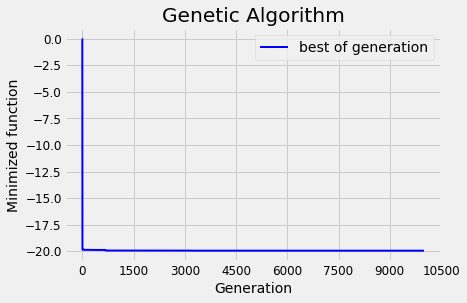

In [754]:
model1.run()

In [755]:
# RMSE 
optimized = val_rnn_15_predict_result * model1.output_dict['variable'][0] + val_lstm_15_predict_result *model1.output_dict['variable'][1] + val_slstm_15_predict_result * model1.output_dict['variable'][2] + val_bilstm_15_predict_result * model1.output_dict['variable'][3] + val_gru_15_predict_result * model1.output_dict['variable'][4]
for i in range(len(optimized)):
    if optimized[i] >= 400: 
        optimized[i]=400
    if optimized[i] <= 60: 
        optimized[i]=60
optimized_rmse_15 =  RMSE(y_val_uni_origin,optimized)
optimized_rmse_15

26.09818970421842

In [756]:
optimized

array([[ 96.46449 ],
       [ 97.15168 ],
       [107.05711 ],
       [103.331566],
       [107.252975],
       [110.50974 ],
       [119.1312  ],
       [116.02832 ],
       [108.28449 ],
       [100.83155 ],
       [102.821724],
       [104.4691  ],
       [114.3474  ],
       [111.04814 ],
       [103.94026 ],
       [108.75154 ],
       [107.26597 ],
       [131.15591 ],
       [126.70524 ],
       [126.4606  ],
       [140.79915 ],
       [173.5802  ],
       [164.38799 ],
       [165.12395 ],
       [169.98798 ],
       [184.64992 ],
       [184.37961 ],
       [175.08565 ],
       [169.19336 ],
       [164.40456 ],
       [157.39069 ],
       [149.24226 ],
       [140.20284 ],
       [161.19965 ],
       [189.02248 ],
       [209.60245 ],
       [227.81996 ],
       [229.28539 ],
       [245.37169 ],
       [246.47316 ],
       [264.89746 ],
       [237.71268 ],
       [253.90157 ],
       [236.3646  ],
       [228.10828 ],
       [217.74344 ],
       [204.64827 ],
       [207.9

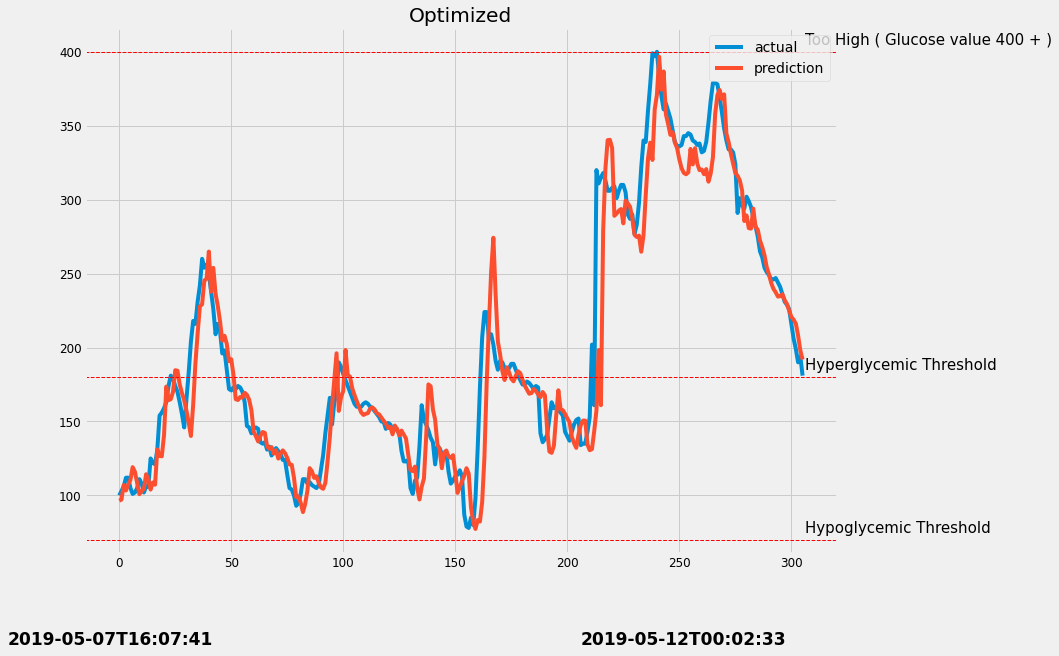

In [757]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(optimized,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(y_val_uni_origin),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(y_val_uni_origin)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

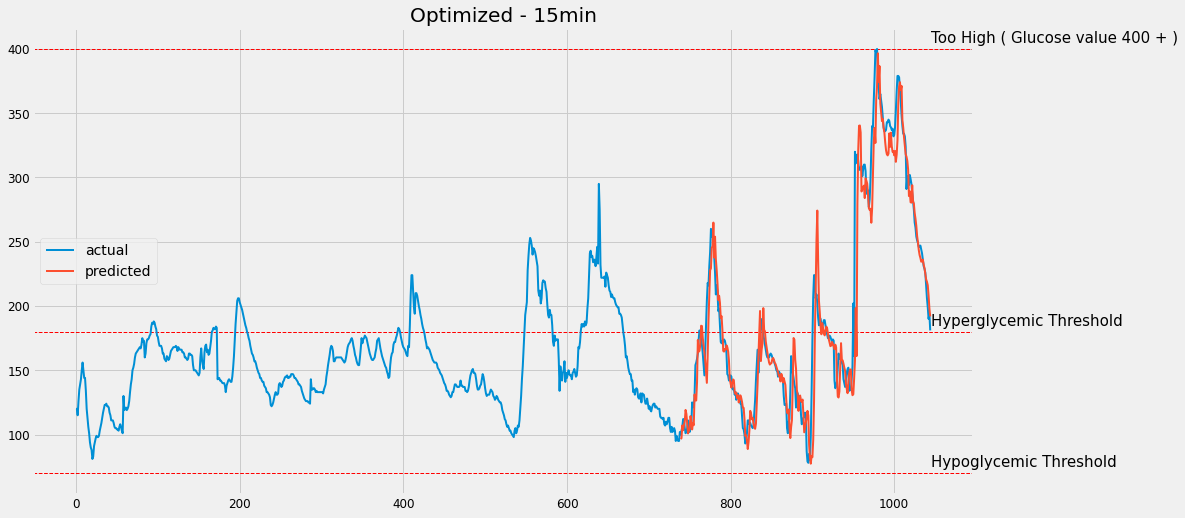

In [758]:
# Make a new dataframe of your prediction values
df_new = pd.DataFrame(df['Glucose'])
df_new.columns = ['rawseq']

# Retrieve index values
new_index = df_new['rawseq'].tail(len(optimized)).index

# Make a dataframe with your prediction values and your index
new_series = pd.DataFrame(index = new_index, data = optimized)

# Merge the dataframes
df_new = pd.merge(df_new, new_series, how = 'left', left_index=True, right_index=True)
df_new.columns = ['rawseq', 'optimized']

# And plot it
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))

plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)

plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(raw_seq),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(raw_seq),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(raw_seq),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized - 15min',family='Times New Roman')
plt.plot(df_new['rawseq'],label='actual',linewidth=2)
plt.plot(df_new['optimized'], label='predicted',linewidth=2)
plt.legend(loc='best')
plt.show()

In [760]:
get_optimized = np.array(optimized)

In [761]:
get_optimized = get_optimized.T

In [762]:
get_optimized.shape

(1, 306)

In [768]:
ar_val_15=np.concatenate((get_y_val_origin, get_val_rnn_15_predict_result,get_val_lstm_15_predict_result,get_val_slstm_15_predict_result,get_val_bilstm_15_predict_result,get_val_gru_15_predict_result,get_optimized), axis = 0)


In [769]:
ar_train_15 = np.concatenate((get_x_train_origin_15, get_train_rnn_15_predict_result ,get_train_lstm_15_predict_result ,get_train_slstm_15_predict_result,get_train_bilstm_15_predict_result,get_train_gru_15_predict_result),axis=0)

In [765]:
#ar_val_15=np.concatenate((get_y_val_origin, get_val_rnn_15_predict_result,get_val_lstm_15_predict_result,get_val_slstm_15_predict_result,get_val_bilstm_15_predict_result,get_val_gru_15_predict_result), axis = 0)


In [766]:
#ar_train_15 = np.concatenate((get_x_train_origin_15, get_train_rnn_15_predict_result ,get_train_lstm_15_predict_result ,get_train_slstm_15_predict_result,get_train_bilstm_15_predict_result,get_train_gru_15_predict_result),axis=0)

In [770]:
y1=pd.DataFrame(ar_val_15,index=['15_val_origin','15_val_rnn','15_val_lstm','15_val_slstm','15_val_bilstm','15_val_gru','15_optimized'])
y1

0           1           2           3           4    \
15_val_origin  100.000000  103.000000  106.000000  112.000000  112.000000   
15_val_rnn      93.755569   94.224831  104.014435  100.951759  104.398247   
15_val_lstm     92.685928   94.261871  106.524376  100.434433  103.124893   
15_val_slstm    94.485031   95.334419  105.575569  100.326561  104.412231   
15_val_bilstm   98.366821   98.626335  108.034233  104.673988  109.315567   
15_val_gru      98.606888   99.726463  109.433685  107.920883  110.733986   
15_optimized    96.464493   97.151680  107.057114  103.331566  107.252975   

                      5           6           7           8           9    \
15_val_origin  105.000000  101.000000  102.000000  105.000000  111.000000   
15_val_rnn     107.402107  115.032516  113.527916  103.307091   97.313354   
15_val_lstm    107.506203  116.111237  114.974472  105.902718   95.037308   
15_val_slstm   107.971642  118.598419  113.255959  105.007088   96.440285   
15_val_bilstm  112.200966  120.268600  116.999985  110.562218  104.509224   
15_val_gru     114.021973  120.828087  120.493774  112.717712  104.597862   
15_optimized   110.509743  119.131203  116.028320  108.284492  100.831551   

                      10          11          12          13          14   \
15_val_origin  108.000000  102.000000  106.000000  106.000000  125.000000   
15_val_rnn     100.479523  105.515503  113.151985  108.255188   99.794479   
15_val_lstm    102.502197   99.462921  110.345230  110.038345  100.097206   
15_val_slstm   101.933228  100.394485  113.101974  108.933693   99.810265   
15_val_bilstm  103.480148  106.874619  115.615715  111.835915  106.965401   
15_val_gru     104.379562  107.570526  115.748466  114.890678  108.330017   
15_optimized   102.821724  104.469101  114.347397  111.048141  103.940262   

                      15          16          17          18          19   \
15_val_origin  122.000000  121.000000  131.000000  154.000000  156.000000   
15_val_rnn     104.978798  106.339684  126.289101  115.274002  123.291092   
15_val_lstm    105.797775  102.212410  133.647186  127.217773  123.238495   
15_val_slstm   109.054657  105.394981  133.323318  127.727821  121.553795   
15_val_bilstm  108.978561  108.086838  130.243057  126.147537  129.833344   
15_val_gru     110.625999  110.784683  131.121887  131.975754  130.802094   
15_optimized   108.751541  107.265968  131.155914  126.705238  126.460602   

                      20          21          22          23          24   \
15_val_origin  159.000000  163.000000  174.000000  181.000000  179.000000   
15_val_rnn     132.815994  157.598831  150.297638  164.171265  164.595856   
15_val_lstm    134.434341  172.835571  163.362061  162.089920  165.260422   
15_val_slstm   146.416550  189.269577  168.294327  158.722443  160.692291   
15_val_bilstm  140.117386  168.699341  163.603485  170.092712  180.088028   
15_val_gru     138.552170  165.005981  167.004440  167.640518  170.134735   
15_optimized   140.799149  173.580200  164.387985  165.123947  169.987976   

                      25          26          27          28          29   \
15_val_origin  174.000000  170.000000  163.000000  155.000000  146.000000   
15_val_rnn     177.990952  184.252151  179.502548  170.349319  164.539352   
15_val_lstm    178.280563  181.605652  176.169327  172.615112  168.134445   
15_val_slstm   188.716904  186.482910  169.777084  165.705383  162.104019   
15_val_bilstm  186.758804  182.752274  175.347443  169.699707  165.028549   
15_val_gru     178.833008  184.859665  181.042557  172.602158  165.994125   
15_optimized   184.649918  184.379608  175.085648  169.193359  164.404556   

                      30          31          32          33          34   \
15_val_origin  165.000000  183.000000  204.000000  218.000000  216.000000   
15_val_rnn     156.470566  147.209274  137.546494  162.332321  182.541580   
15_val_lstm    160.817383  152.069443  143.098877  158.125473  186.507950   
15_val_slstm

In [772]:
y2=pd.DataFrame(ar_train_15,index=['15_train_origin','15_train_rnn','15_train_lstm','15_train_slstm','15_train_bilstm','15_train_gru'])
y2
#y.append(get_val_rnn_15_predict_result,ignore_index=True)

0           1           2           3           4    \
15_train_origin  156.000000  150.000000  144.000000  144.000000  134.000000   
15_train_rnn     143.196136  146.174942  153.451324  159.205887  148.927582   
15_train_lstm    143.165512  145.892532  154.433044  159.443558  150.521606   
15_train_slstm   141.571793  141.582397  152.174454  157.004578  145.459808   
15_train_bilstm  144.743546  147.995743  162.093170  161.798752  149.225861   
15_train_gru     146.212860  149.915985  157.359818  161.900070  153.446564   

                        5           6           7           8           9    \
15_train_origin  120.000000  113.000000  106.000000  101.000000   94.000000   
15_train_rnn     139.544586  140.163956  128.320740  110.479210  105.769447   
15_train_lstm    142.772186  140.544601  133.431580  113.907471  101.017685   
15_train_slstm   135.645630  141.034134  129.130127  106.195549   96.469566   
15_train_bilstm  142.609512  141.209885  134.243423  123.509392  112.427147   
15_train_gru     143.285217  141.351288  131.440643  113.996529  106.085030   

                        10         11         12         13         14   \
15_train_origin   90.000000  88.000000  81.000000  83.000000  91.000000   
15_train_rnn      99.663628  95.723145  88.776306  85.756966  85.366333   
15_train_lstm     99.095787  92.590843  90.046349  89.137482  87.833511   
15_train_slstm    88.945740  84.704971  78.669617  81.920006  86.709717   
15_train_bilstm  104.463928  98.771400  94.248146  90.646942  89.261429   
15_train_gru     101.416473  97.431984  91.606613  87.907692  87.755653   

                       15         16         17          18          19   \
15_train_origin  94.000000  97.000000  99.000000   98.000000   98.000000   
15_train_rnn     77.543663  81.598343  92.205673   97.013641  100.471695   
15_train_lstm    89.112000  84.220917  95.828560   97.748779  101.554466   
15_train_slstm   86.589088  86.575920  88.242844   90.259834   91.193047   
15_train_bilstm  85.710136  87.039696  97.487556  101.164856  105.686356   
15_train_gru     82.549835  85.816505  96.993675   97.940094   99.960526   

                        20          21          22          23          24   \
15_train_origin   99.000000  103.000000  106.000000  109.000000  113.000000   
15_train_rnn     101.506790   99.144005   98.054596   99.211594  104.493454   
15_train_lstm    104.801598  100.606903   98.659340   99.014442  103.287270   
15_train_slstm    93.433067   95.659454  100.059196  103.250885  105.548759   
15_train_bilstm  112.175949  109.086960  104.314201  103.988747  108.274193   
15_train_gru     100.908806  100.436211  103.328331  105.862663  110.652443   

                        25          26          27          28          29   \
15_train_origin  117.000000  120.000000  123.000000  123.000000  124.000000   
15_train_rnn     107.910904  111.063477  115.362282  119.591263  122.253250   
15_train_lstm    107.353767  111.477684  116.297752  120.659683  123.063362   
15_train_slstm   110.150154  112.725189  117.492966  122.339439  124.113625   
15_train_bilstm  111.479401  115.414322  120.175468  124.573647  126.338905   
15_train_gru     114.227257  117.996376  122.537636  126.691650  128.357513   

                        30          31          32          33          34   \
15_train_origin  122.000000  122.000000  121.000000  117.000000  115.000000   
15_train_rnn     124.917137  123.563980  123.908279  120.671196  120.562683   
15_train_lstm    125.425095  124.732101  124.289680  122.073456  120.163261   
15_train_slstm   125.536568  122.528191  121.417236  117.782173  115.361053   
15_train_bilstm  128.599792  126.472061  126.335266  122.839653  122.555664   
15_train_gru     130.325592  129.136002  128.394547  125.089058  123.832329   

                        35          36          37          38          39   \
15_train_origin  111.000000  111.000000  111.000000  109.000000  106.000000   
15_train_rnn     119.480423  114.3162

#### GA_Residual

Text(0.5, 1.0, '15Min GA Normal Q-Q Plot')

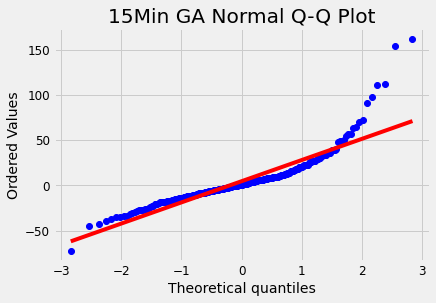

In [773]:
residuals = [y_val_uni_origin[i]-optimized[i] for i in range(len(optimized))]
residuals = y_val_uni_origin - optimized.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("15Min GA Normal Q-Q Plot")

Text(0.5, 1.0, '15Min GA Normal Q-Q Plot')

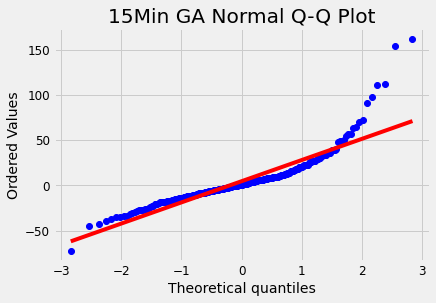

In [774]:
probplot(residuals,dist="norm",plot=plt)
plt.title("15Min GA Normal Q-Q Plot")

In [775]:
residuals=DataFrame(residuals)

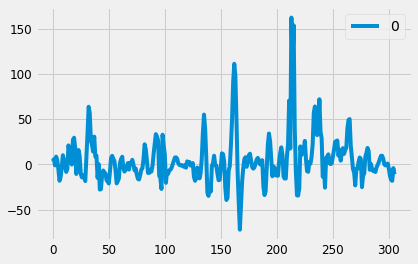

In [776]:
residuals.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f91a5749850>]],
      dtype=object)

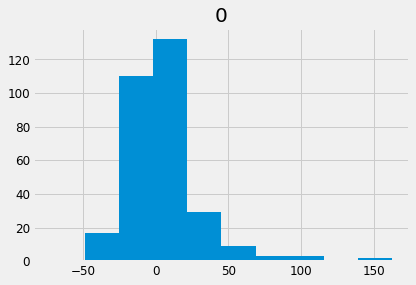

In [777]:

residuals.hist()

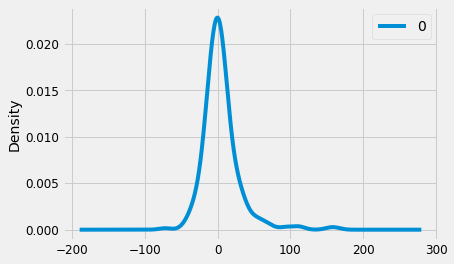

In [778]:
residuals.plot(kind='kde')

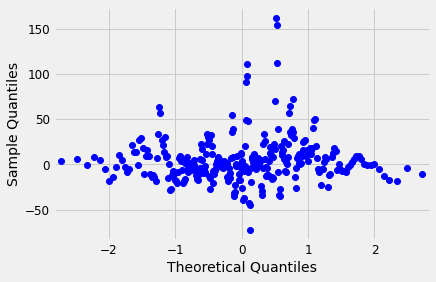

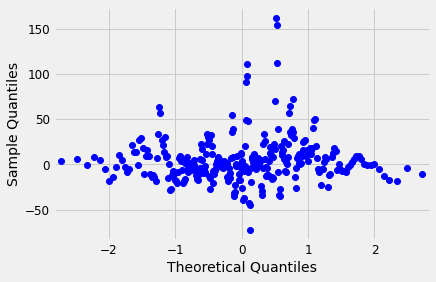

In [779]:
from statsmodels.graphics.gofplots import qqplot
residuals=np.array(residuals)
qqplot(residuals)

## 30분

In [780]:
# SG필터 테스트 
#import scipy.signal 

#yhat = scipy.signal.savgol_filter(raw_seq,15,5)
#plt.plot(raw_seq)
#plt.plot(yhat,color='red')
#plt.show()

In [781]:
#TRAIN_SPLIT=int(len(raw_seq)*0.7)
#uni_past_history=6
#uni_future_target=5
#x_train_uni,y_train_uni = uni_data(yhat,0,TRAIN_SPLIT,
#                                  uni_past_history,
#                                  uni_future_target)
#x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
#                            uni_past_history,
#                            uni_future_target)



In [782]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=5
x_train_uni,y_train_uni = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [783]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=5
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)



In [784]:
y_val_uni.shape


(303,)

In [785]:

x_val_uni.shape

(303, 6, 1)

In [786]:
x_train_uni[0]

array([[120],
       [120],
       [115],
       [126],
       [135],
       [139]])

In [787]:
df['Glucose'].head(15)

0     120.0
1     120.0
2     115.0
3     126.0
4     135.0
5     139.0
6     143.0
7     150.0
8     156.0
9     150.0
10    144.0
11    144.0
12    134.0
13    120.0
14    113.0
Name: Glucose, dtype: float64

In [788]:
y_train_uni[0]

144

### RNN - 30분

In [789]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [790]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_uni.shape[-2:],return_sequences=False))
model.add(Dense(1))

In [791]:
model.compile(optimizer='adam',loss='mse')

In [792]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [793]:
val_rnn_30_predict_result = model.predict(x_val_uni,verbose=0)

In [794]:
K.clear_session()

In [795]:
predict_result = model.predict(x_val_uni,verbose=0)

In [796]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    if predict_result[i] <= 60: 
        predict_result[i]=60
# GA에 사용 
val_rnn_30_predict_result = predict_result

In [797]:
get_x_train_origin_30 = np.array(y_train_uni_origin)

In [798]:
get_x_train_origin_30 = get_x_train_origin_30.reshape(1,len(y_train_uni_origin))

In [799]:
get_x_train_origin_30.shape

(1, 725)

In [800]:
get_y_val_origin_30 = np.array(y_val_uni_origin)

In [801]:
get_y_val_origin_30 = get_y_val_origin_30.reshape(1,len(get_y_val_origin_30))

In [802]:
get_y_val_origin_30.shape

(1, 303)

In [803]:
#get_y_val_origin

In [804]:
get_val_rnn_30_predict_result = np.array(val_rnn_30_predict_result)

In [805]:
get_val_rnn_30_predict_result = get_val_rnn_30_predict_result.T

In [806]:
get_val_rnn_30_predict_result.shape

(1, 303)

In [807]:
#ar_15=np.concatenate((get_y_val_origin, get_val_rnn_15_predict_result), axis = 0)


In [808]:
#y=pd.DataFrame(ar,index=['15_val_origin','15_rnn'])
#y
#y.append(get_val_rnn_15_predict_result,ignore_index=True)

In [809]:
#get_val_rnn_15_pedict_result =get_val_rnn_15_pedict_result.reshape(1,len(get_val_rnn_15_pedict_result))

In [810]:
get_val_rnn_30_predict_result.shape

(1, 303)

In [811]:
val_rnn_30_predict_result

array([[ 95.03304 ],
       [ 95.20598 ],
       [105.23405 ],
       [102.521965],
       [106.11995 ],
       [109.199554],
       [117.02706 ],
       [115.92726 ],
       [105.72418 ],
       [ 98.88887 ],
       [100.93543 ],
       [105.685715],
       [113.8425  ],
       [110.31928 ],
       [101.46433 ],
       [106.266205],
       [106.98899 ],
       [127.41311 ],
       [128.21298 ],
       [128.07262 ],
       [134.57603 ],
       [158.58484 ],
       [168.86949 ],
       [170.343   ],
       [169.35048 ],
       [180.34169 ],
       [185.23232 ],
       [181.96582 ],
       [171.08192 ],
       [164.78664 ],
       [155.5171  ],
       [145.85178 ],
       [135.85889 ],
       [159.60863 ],
       [183.05612 ],
       [212.63567 ],
       [237.49501 ],
       [232.18793 ],
       [240.247   ],
       [247.99979 ],
       [268.13812 ],
       [256.40155 ],
       [254.54185 ],
       [241.86874 ],
       [225.4954  ],
       [209.23514 ],
       [189.8324  ],
       [201.9

In [812]:
y_val_uni_origin

array([112, 112, 105, 101, 102, 105, 111, 108, 102, 106, 106, 125, 122,
       121, 131, 154, 156, 159, 163, 174, 181, 179, 174, 170, 163, 155,
       146, 165, 183, 204, 218, 216, 231, 242, 260, 254, 256, 250, 238,
       226, 209, 216, 211, 196, 198, 185, 172, 171, 173, 172, 174, 173,
       170, 163, 147, 146, 142, 145, 146, 145, 136, 135, 136, 131, 133,
       127, 130, 132, 130, 128, 124, 124, 114, 105, 104, 100,  93,  95,
       101, 111, 111, 108, 109, 107, 106, 105, 107, 117, 127, 142, 154,
       166, 148, 163, 169, 190, 187, 182, 178, 174, 170, 166, 162, 160,
       160, 160, 162, 163, 162, 160, 159, 157, 155, 153, 150, 150, 145,
       149, 148, 144, 146, 144, 142, 130, 123, 123, 124, 105, 101, 110,
       112, 133, 161, 151, 148, 144, 139, 136, 121, 133, 132, 128, 128,
       129, 116, 108, 110, 113, 114, 117, 113,  87,  79,  78,  85,  80,
        98, 132, 173, 207, 224, 224, 206, 209, 202, 191, 185, 191, 190,
       186, 184, 186, 189, 189, 185, 181, 178, 175, 175, 177, 17

In [813]:
# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_rnn_30 = RMSE(y_val_uni_origin,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  40.08035609257259


#### 잔차

Text(0.5, 1.0, 'Simple RNN Q-Q Plot')

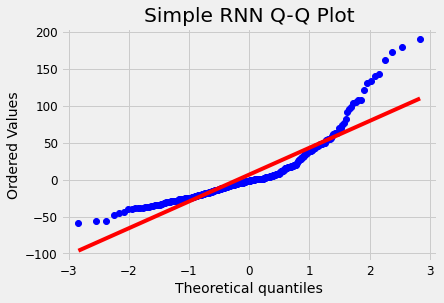

In [814]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Q-Q Plot")

#### Validation

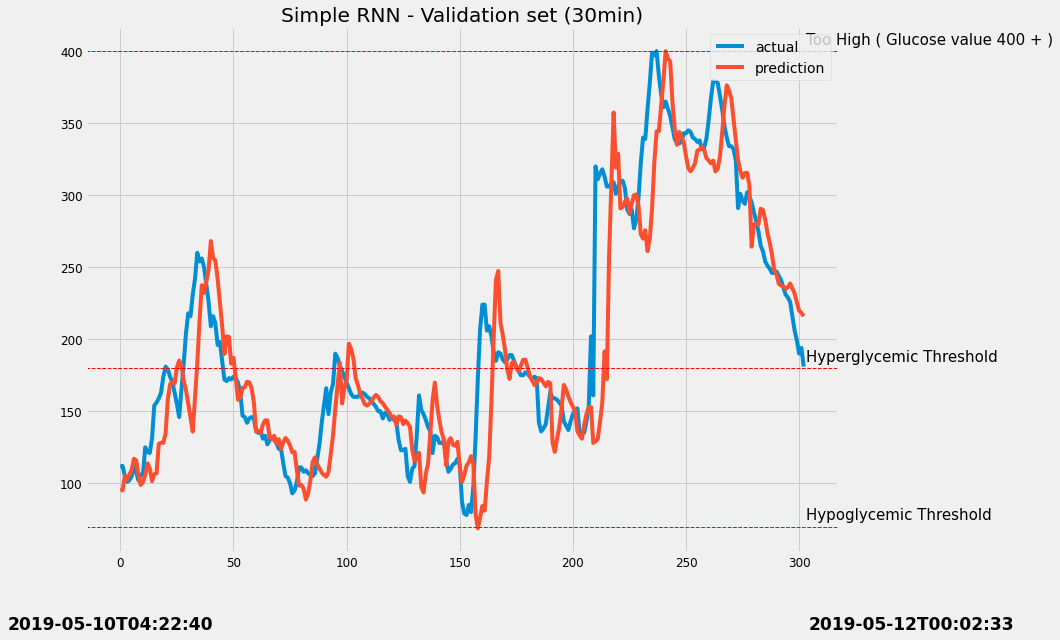

In [815]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'Simple RNN 30min Normal Q-Q Plot')

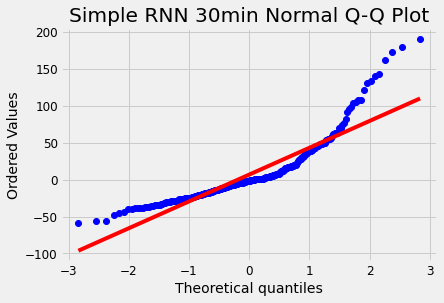

In [816]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)

#residuals

probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN 30min Normal Q-Q Plot")

In [817]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400     
    elif predict_result[i] <= 60: 
        predict_result[i]=60           
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,predict_result))
train_rnn_30_predict_result=predict_result
train_rnn_30=RMSE(y_train_uni_origin,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  16.584992794635504


In [818]:
get_train_rnn_30_predict_result = np.array(train_rnn_30_predict_result)

In [819]:
get_train_rnn_30_predict_result = get_train_rnn_30_predict_result.T

In [820]:
get_train_rnn_30_predict_result.shape

(1, 725)

#### Train

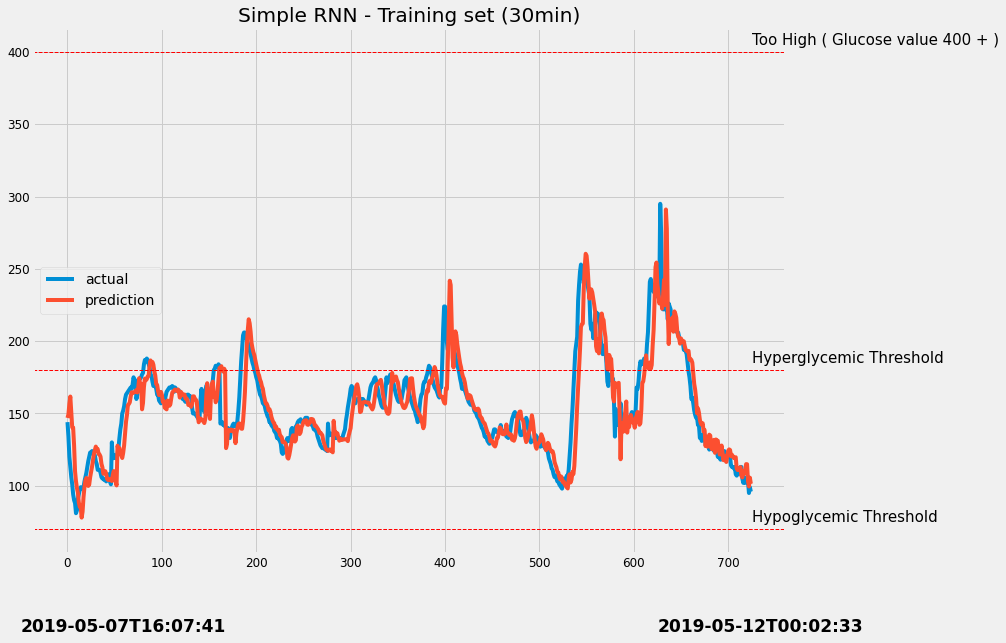

In [821]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Training set (30min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### LSTM - 30분

In [822]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [823]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))


In [824]:
model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)
val_lstm_30_predict_result = model.predict(x_val_uni,verbose=0)
K.clear_session()

In [825]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    if predict_result[i] <= 60: 
        predict_result[i]=60

#predict_result
val_lstm_30_predict_result=predict_result
print(' LSTM - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_lstm_30=RMSE(y_val_uni_origin,predict_result)

 LSTM - RMSE (15min) :  39.53597997362612


In [826]:
get_val_lstm_30_predict_result = np.array(val_lstm_30_predict_result)

In [827]:
get_val_lstm_30_predict_result = get_val_lstm_30_predict_result.T

In [828]:
get_val_lstm_30_predict_result.shape

(1, 303)

In [829]:
predict_result

array([[109.93172 ],
       [113.33452 ],
       [122.41781 ],
       [120.79595 ],
       [123.088585],
       [127.06862 ],
       [134.32011 ],
       [134.0551  ],
       [123.7024  ],
       [111.2687  ],
       [110.698845],
       [112.29385 ],
       [125.79223 ],
       [127.58119 ],
       [119.094925],
       [124.21458 ],
       [121.21007 ],
       [151.95375 ],
       [145.89491 ],
       [143.37273 ],
       [155.80489 ],
       [193.55312 ],
       [180.0607  ],
       [173.36546 ],
       [170.51181 ],
       [189.80319 ],
       [189.71474 ],
       [183.50781 ],
       [177.77824 ],
       [171.63123 ],
       [161.43396 ],
       [151.44669 ],
       [140.6809  ],
       [165.25241 ],
       [189.57468 ],
       [209.5391  ],
       [230.1463  ],
       [224.03029 ],
       [232.07654 ],
       [239.24974 ],
       [254.99588 ],
       [236.8257  ],
       [237.35757 ],
       [234.84924 ],
       [228.54622 ],
       [221.26735 ],
       [208.06172 ],
       [206.9

#### 잔차

Text(0.5, 1.0, 'LSTM Q-Q Plot')

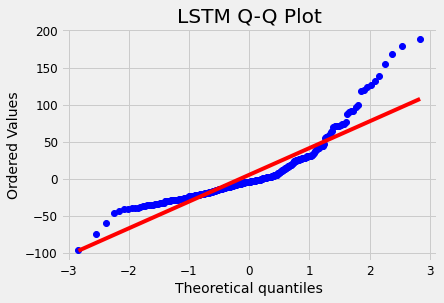

In [830]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Q-Q Plot")

#### Validation

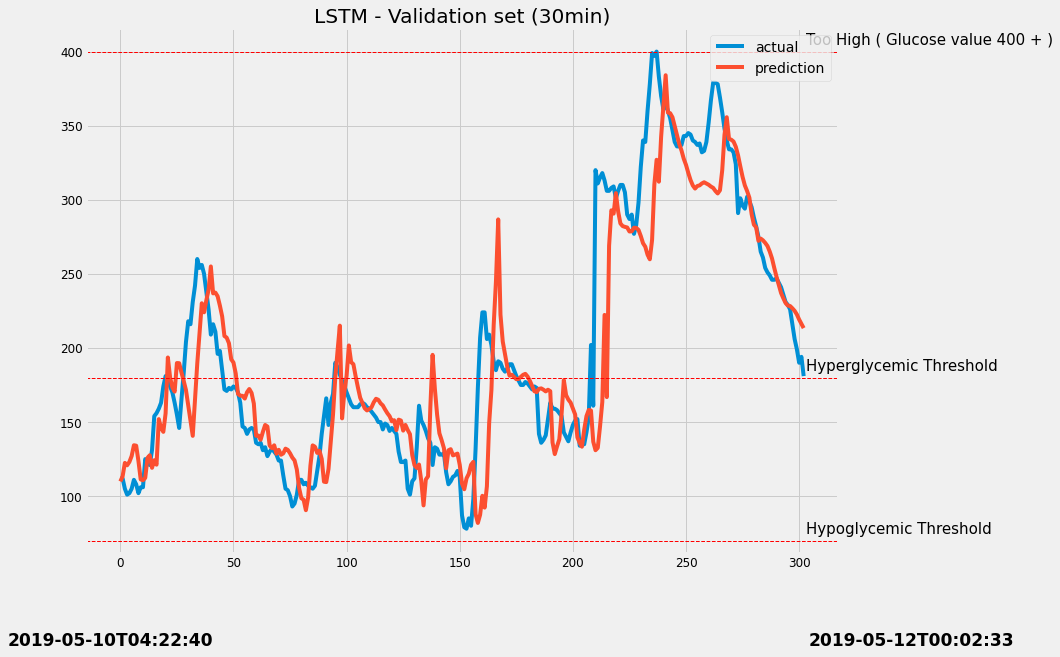

In [831]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [832]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    elif predict_result[i] <= 60: 
        predict_result[i]=60

train_lstm_30_predict_result = predict_result
print(' LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_lstm_30 =RMSE(y_train_uni_origin,predict_result)

 LSTM - RMSE (15min) Training set :  15.21593841047898


In [833]:
get_train_lstm_30_predict_result = np.array(train_lstm_30_predict_result)

In [834]:
get_train_lstm_30_predict_result = get_train_lstm_30_predict_result.T

In [835]:
get_train_lstm_30_predict_result.shape

(1, 725)

#### Train

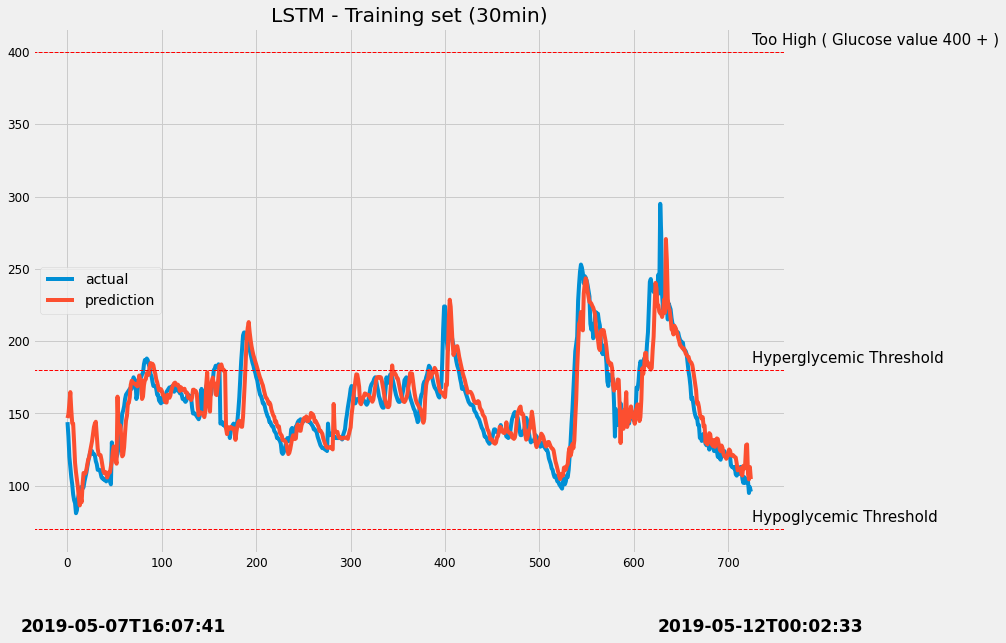

In [836]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Training set (30min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 30분

In [837]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [838]:
model = Sequential()
#model.Flatten()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_uni.shape[-2:]))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [839]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [840]:
K.clear_session()

In [841]:
val_slstm_30_predict_result = model.predict(x_val_uni,verbose=0)

In [842]:
predict_result = model.predict(x_val_uni,verbose=0)


for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    elif predict_result[i] <= 60: 
        predict_result[i]=60

print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,predict_result))
val_stacklstm_30 =RMSE(y_val_uni_origin,predict_result)

val_slstm_30_predict_result=predict_result

 Stacked LSTM - RMSE(15min) :  40.773517864858796


In [843]:
get_val_slstm_30_predict_result = np.array(val_slstm_30_predict_result)

In [844]:
get_val_slstm_30_predict_result = get_val_slstm_30_predict_result.T

In [845]:
get_val_slstm_30_predict_result.shape

(1, 303)

In [846]:
predict_result

array([[111.14116 ],
       [114.65515 ],
       [126.419525],
       [121.67579 ],
       [126.540115],
       [129.41487 ],
       [139.67601 ],
       [140.20128 ],
       [128.59639 ],
       [116.17394 ],
       [114.54738 ],
       [110.21694 ],
       [122.613335],
       [129.45512 ],
       [123.28878 ],
       [129.2473  ],
       [122.28481 ],
       [139.69057 ],
       [151.33331 ],
       [147.6762  ],
       [161.56227 ],
       [200.66052 ],
       [185.05685 ],
       [182.10666 ],
       [178.95763 ],
       [196.59462 ],
       [190.87685 ],
       [183.47752 ],
       [176.14294 ],
       [173.57866 ],
       [163.98653 ],
       [155.40338 ],
       [152.60039 ],
       [156.68747 ],
       [192.73851 ],
       [221.52603 ],
       [246.08054 ],
       [227.5728  ],
       [246.80281 ],
       [245.54305 ],
       [264.2407  ],
       [237.46587 ],
       [246.22166 ],
       [236.18651 ],
       [228.82838 ],
       [222.51497 ],
       [215.01709 ],
       [212.1

#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Q-Q Plot')

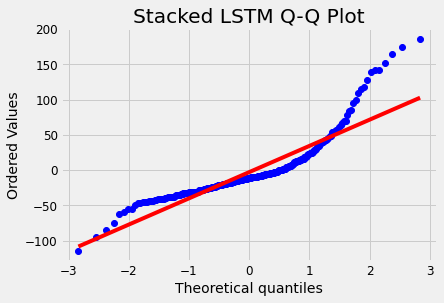

In [847]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Q-Q Plot")

#### Validation

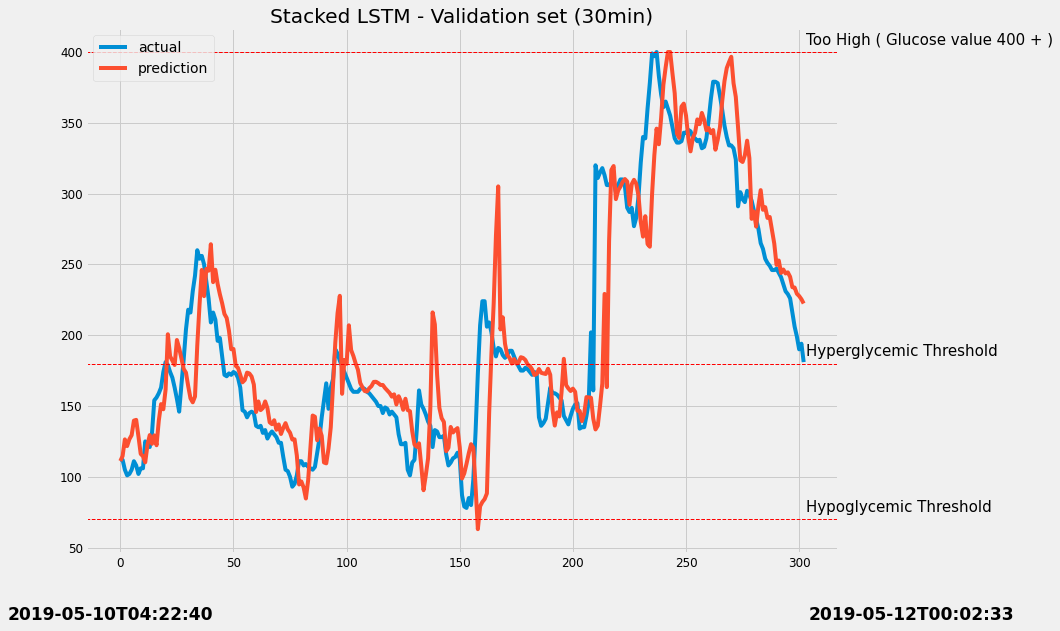

In [848]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [849]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    if predict_result[i] <= 60: 
        predict_result[i]=60
print(' Training set / STACKED LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_stacklstm_30 = RMSE(y_train_uni_origin,predict_result)
train_slstm_30_predict_result=predict_result

 Training set / STACKED LSTM - RMSE (15min) Training set :  15.167294610253112


In [850]:
get_train_slstm_30_predict_result = np.array(train_slstm_30_predict_result)

In [851]:
get_train_slstm_30_predict_result = get_train_slstm_30_predict_result.T

In [852]:
get_train_slstm_30_predict_result.shape

(1, 725)

#### Train

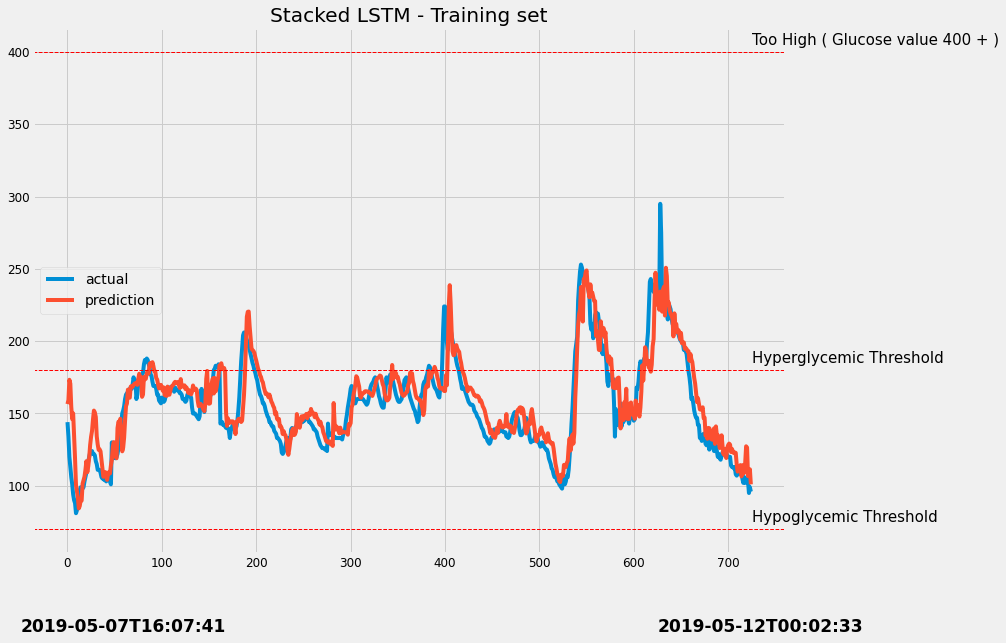

In [853]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 30분

In [854]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [855]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [856]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [857]:
val_bilstm_30_predict_result = model.predict(x_val_uni,verbose=0)

In [858]:
K.clear_session()

In [859]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    elif predict_result[i] <= 60: 
        predict_result[i]=60

print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,predict_result))
val_bilstm_30 = RMSE(y_val_uni_origin,predict_result)
val_bilstm_30_predict_result=predict_result

Bidirectional LSTM - RMSE :  42.252896039642565


In [860]:
get_val_bilstm_30_predict_result = np.array(val_bilstm_30_predict_result)

In [861]:
get_val_bilstm_30_predict_result = get_val_bilstm_30_predict_result.T

In [862]:
get_val_bilstm_30_predict_result.shape

(1, 303)

In [863]:
predict_result

array([[106.12998 ],
       [107.62484 ],
       [119.694695],
       [113.03452 ],
       [120.178055],
       [123.53362 ],
       [131.71693 ],
       [127.047325],
       [118.260155],
       [111.05452 ],
       [113.0102  ],
       [115.5397  ],
       [124.44748 ],
       [120.642265],
       [113.2082  ],
       [121.430145],
       [116.41373 ],
       [139.48573 ],
       [137.00691 ],
       [138.82925 ],
       [148.65631 ],
       [173.93568 ],
       [170.70187 ],
       [175.21098 ],
       [176.56097 ],
       [185.99959 ],
       [187.585   ],
       [179.10959 ],
       [171.47395 ],
       [164.92683 ],
       [155.87398 ],
       [147.41383 ],
       [139.88637 ],
       [157.5422  ],
       [190.87265 ],
       [210.73497 ],
       [230.38823 ],
       [244.07349 ],
       [246.72786 ],
       [252.48328 ],
       [272.3581  ],
       [248.17825 ],
       [247.3932  ],
       [240.13965 ],
       [228.47382 ],
       [210.96297 ],
       [196.86745 ],
       [204.9

#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Q-Q Plot')

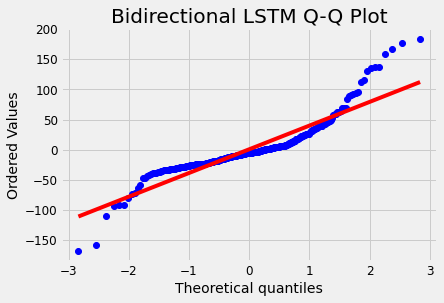

In [864]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Q-Q Plot")

#### Validation

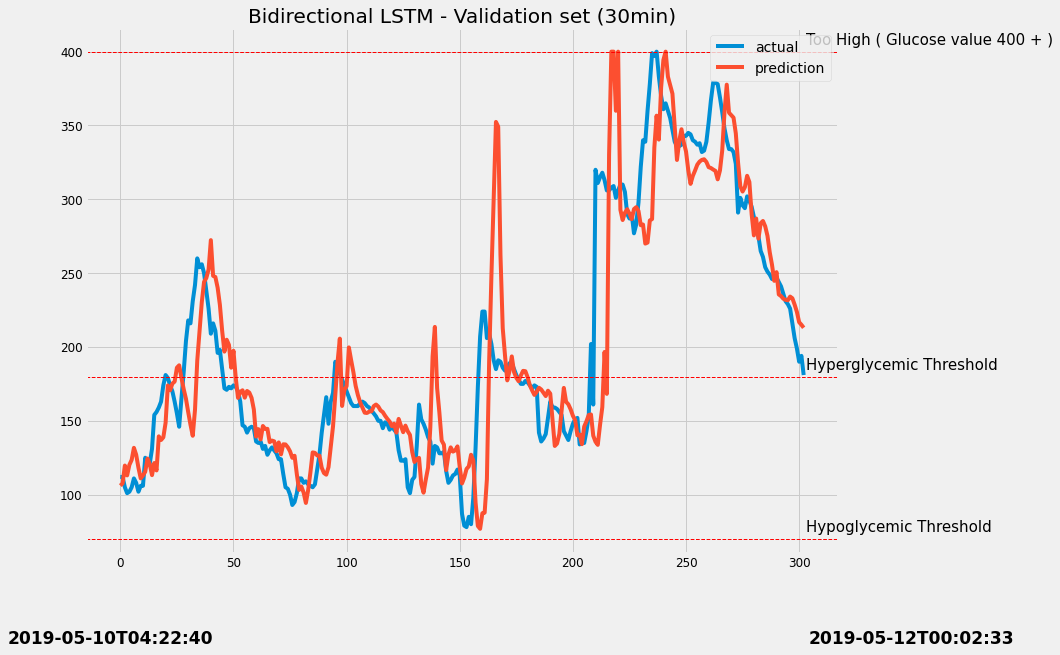

In [865]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [866]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    if predict_result[i] <= 60: 
        predict_result[i]=60
print(' Training set / Bidirectional LSTM - RMSE (30min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_bilstm_30 = RMSE(y_train_uni_origin,predict_result)
train_bilstm_30_predict_result=predict_result

 Training set / Bidirectional LSTM - RMSE (30min) Training set :  15.828013372291775


In [867]:
get_train_bilstm_30_predict_result = np.array(train_bilstm_30_predict_result)

In [868]:
get_train_bilstm_30_predict_result = get_train_bilstm_30_predict_result.T

In [869]:
get_train_bilstm_30_predict_result.shape

(1, 725)

#### Train

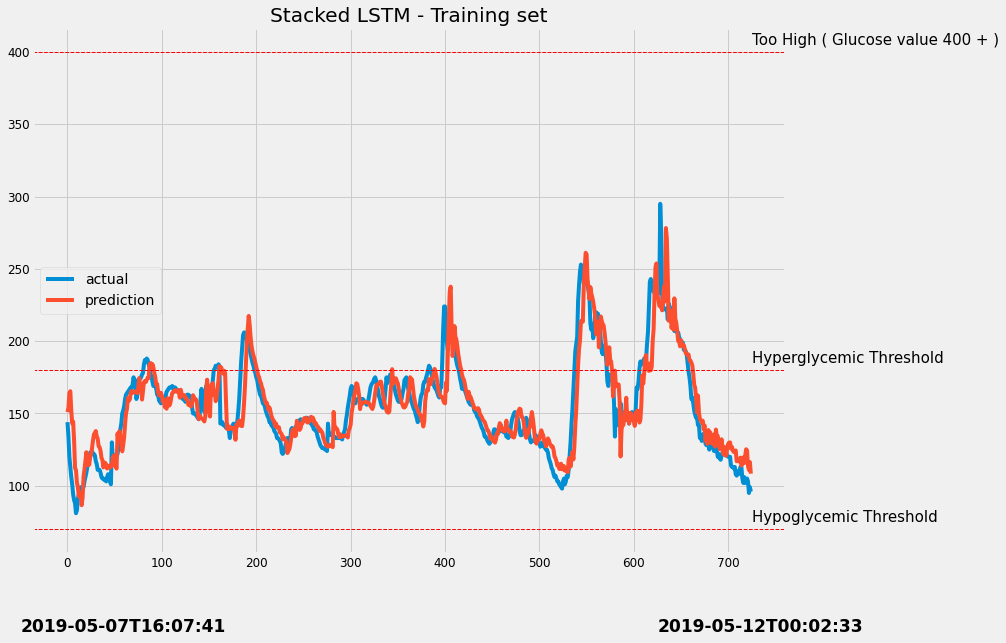

In [870]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 30분

In [871]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [872]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
#model.add(GRU(50,activation=leaky_relu,input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [873]:
model.summary()

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()
val_gru_30_predict_result = model.predict(x_val_uni,verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [874]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    if predict_result[i] <= 60: 
        predict_result[i]=60

#predict_result

#predict_result


print('GRU - RMSE 15min : ',RMSE(y_val_uni,predict_result))
val_gru_30 = RMSE(y_val_uni,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63
val_gru_30_predict_result=predict_result

GRU - RMSE 15min :  39.37307377647422


In [875]:
get_val_gru_30_predict_result = np.array(val_gru_30_predict_result)

In [876]:
get_val_gru_30_predict_result = get_val_gru_30_predict_result.T

In [877]:
get_val_gru_30_predict_result.shape

(1, 303)

In [878]:
predict_result

array([[103.28851 ],
       [105.13964 ],
       [119.67624 ],
       [117.10134 ],
       [120.84352 ],
       [124.86967 ],
       [131.72147 ],
       [126.633064],
       [120.894806],
       [110.30112 ],
       [108.17853 ],
       [111.053085],
       [118.59202 ],
       [119.3703  ],
       [115.58955 ],
       [116.31526 ],
       [115.37525 ],
       [132.32356 ],
       [135.82303 ],
       [135.55994 ],
       [139.92184 ],
       [166.14998 ],
       [169.45848 ],
       [168.24571 ],
       [169.46896 ],
       [179.2153  ],
       [185.61488 ],
       [182.95525 ],
       [173.56337 ],
       [166.47467 ],
       [156.7537  ],
       [146.39539 ],
       [137.03247 ],
       [156.91556 ],
       [184.53165 ],
       [211.21617 ],
       [227.34462 ],
       [225.60709 ],
       [230.61986 ],
       [239.89886 ],
       [255.70541 ],
       [249.9795  ],
       [245.04607 ],
       [236.05162 ],
       [222.48622 ],
       [208.01846 ],
       [191.75162 ],
       [198.9

#### 잔차

Text(0.5, 1.0, 'GRU Q-Q Plot')

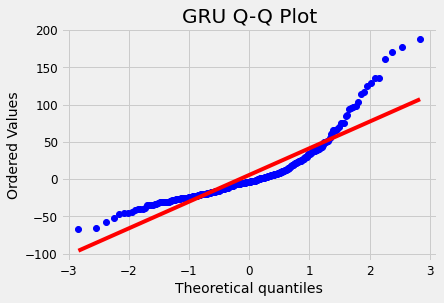

In [879]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Q-Q Plot")

#### Validation

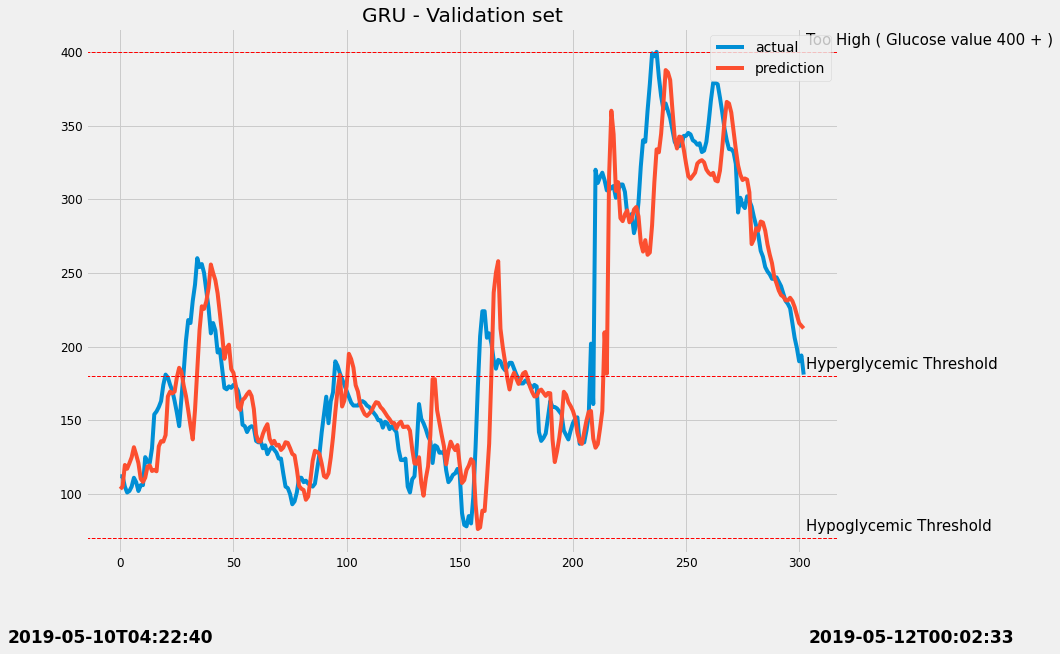

In [880]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [881]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    elif predict_result[i] <= 60: 
        predict_result[i]=60
print(' Training set / GRU - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_gru_30 =RMSE(y_train_uni_origin,predict_result)
train_gru_30_predict_result=predict_result

 Training set / GRU - RMSE (15min) Training set :  16.223794881185103


In [882]:
get_train_gru_30_predict_result = np.array(train_gru_30_predict_result)

In [883]:
get_train_gru_30_predict_result = get_train_gru_30_predict_result.T

In [884]:
get_train_gru_30_predict_result.shape

(1, 725)

#### Train

### GA

In [885]:
#ex = val_rnn_30_predict_result * 0.2 + val_lstm_30_predict_result * 0.2 + val_slstm_30_predict_result * 0.2 + val_bilstm_30_predict_result * 0.2 + val_gru_30_predict_result * 0.2

In [886]:
#ex2 = val_rnn_30_predict_result * 0.43578443     + val_lstm_30_predict_result *  0.07653674+ val_slstm_30_predict_result *  0.07391771 + val_bilstm_30_predict_result * 0.05667096+ val_gru_30_predict_result *0.34709233

In [887]:
#test_result =  RMSE(y_val_uni_origin,ex2)
#test_result

In [888]:
#test_result =  mean_squared_error(y_val_uni_origin,ex)
#test_result

In [889]:
#test_result * 2 - (1000 + test_result)

In [890]:
#result = (test_result*2) - (1000 + mean_squared_error(y_val_uni_origin,abc))

In [891]:
#mean_squared_error

In [892]:
val_rnn_30_predict_result = np.asarray(val_rnn_30_predict_result)
val_lstm_30_predict_result = np.asarray(val_lstm_30_predict_result)
val_slstm_30_predict_result = np.asarray(val_slstm_30_predict_result)
val_bilstm_30_predict_result = np.asarray(val_bilstm_30_predict_result)
val_gru_30_predict_result = np.asarray(val_gru_30_predict_result)

In [893]:
train_rnn_30_predict_result = np.asarray(train_rnn_30_predict_result)
train_lstm_30_predict_result = np.asarray(train_lstm_30_predict_result)
train_slstm_30_predict_result = np.asarray(train_slstm_30_predict_result)
train_bilstm_30_predict_result = np.asarray(train_bilstm_30_predict_result)
train_gru_30_predict_result = np.asarray(train_gru_30_predict_result)

In [894]:
val_rnn_30_predict_result = np.asarray(val_rnn_30_predict_result)
val_lstm_30_predict_result = np.asarray(val_lstm_30_predict_result)
val_slstm_30_predict_result = np.asarray(val_slstm_30_predict_result)
val_bilstm_30_predict_result = np.asarray(val_bilstm_30_predict_result)
val_gru_30_predict_result = np.asarray(val_gru_30_predict_result)

In [895]:
#def evaluate2(X):
#  pen = 0 
  #coef = [0,0,0,0,0]
#  result =0
  #result2 = 0
  #print(X)
#  if sum(X) > 0.99 and sum(X) < 1:
#    print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    #result = mean_squared_error((y_val_uni_origin,(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +
    #             val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] +
    #             val_gru_30_predict_result * X[4]))**0.5)
 #   abc = val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4]
  #  result = (test_result*2) - ((test_result/2) + mean_squared_error(y_val_uni_origin,abc))
    #result = 10 - mean_squared_error(y_val_uni_origin,abc) / test_result 
    #result2=(test_result*5) - np.sqrt(result)
    #test_result =  mean_squared_error(y_val_uni_origin,ex)
    #test_result

    #pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
   # print("\n ** B ** \n")
    #print(X)
    #print()
    #print("\n ** C ** \n")
    #print(result)
  #return np.sum(X) + pen
    #count += 1 
  #return -result
    
    

In [896]:
def evaluate2(X):
  pen = 0 
  #coef = [0,0,0,0,0]
  ab=0
  result =0
  #result2 = 0
  #print(X)
  if sum(X) > 0.99 and sum(X) < 1:
    #print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    #result = mean_squared_error((y_val_uni_origin,(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +
    #             val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] +
    #             val_gru_30_predict_result * X[4]))**0.5)
   # ab = val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4]
   # print("\n ** A ** \n")
   # print(ab.shape)
    result = 50 - np.sqrt(mean_squared_error(train_rnn_30_predict_result * X[0] + train_lstm_30_predict_result * X[1] +train_slstm_30_predict_result * X[2] + 
                                train_bilstm_30_predict_result * X[3] + train_gru_30_predict_result * X[4],y_train_uni_origin))
   
    #result = 10 - mean_squared_error(y_val_uni_origin,abc) / test_result 
    #result2=(test_result*5) - np.sqrt(result)
    #test_result =  mean_squared_error(y_val_uni_origin,ex)
    #test_result

    #pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
    print("\n ** B ** \n")
    print(X)
    #print()
    print("\n ** C ** \n")
    print(result)
  #return np.sum(X) + pen
    #count += 1 
  return -result
    
    

In [897]:
#abc.shape

In [898]:
#y_val_uni_origin.shape

In [899]:
#val_rnn_30_predict_result.shape

In [900]:
#abc = val_rnn_30_predict_result * 0.2 + val_lstm_30_predict_result * 0.2 + val_slstm_30_predict_result * 0.2 + val_bilstm_30_predict_result * 0.2 +val_gru_30_predict_result * 0.2
              

In [901]:
#get = mean_squared_error(y_val_uni_origin,abc)

In [902]:
#test_result*2 - mean_squared_error(y_val_uni_origin,abc)

In [903]:
#varbound = np.array([[500,5000]]*5)

In [904]:
varbound2 = np.array([[0.05, 0.5]]*5)

In [905]:
algorithm_param = {'max_num_iteration': 10000,
                   'population_size':100,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'selection_type': 'roulette',
                   'max_iteration_without_improv':None}

In [906]:
#model = ga(function = evaluate, dimension = 5, variable_type='int',variable_boundaries=varbound,algorithm_parameters = algorithm_param)

In [907]:
model2 = ga(function = evaluate2, dimension = 5, variable_type='real',variable_boundaries=varbound2,algorithm_parameters = algorithm_param)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 ** B ** 

[0.05050354 0.34644712 0.47319554 0.05161805 0.06824378]

 ** C ** 

35.11831614397819

 ** B ** 

[0.05050354 0.34644712 0.47319554 0.05161805 0.06824378]

 ** C ** 

35.11831614397819

 ** B ** 

[0.05050354 0.34644712 0.47319554 0.05161805 0.06824378]

 ** C ** 

35.11831614397819

 ** B ** 

[0.05050354 0.34644712 0.47319554 0.05161805 0.06824378]

 ** C ** 

35.11831614397819

 ** B ** 

[0.05050354 0.34644712 0.47319554 0.05161805 0.06824378]

 ** C ** 

35.11831614397819

 ** B ** 

[0.05050354 0.34644712 0.47319554 0.05161805 0.06824378]

 ** C ** 

35.11831614397819

 ** B ** 

[0.05050354 0.34644712 0.47319554 0.05161805 0.06824378]

 ** C ** 

35.11831614397819

 ** B ** 

[0.05050354 0.34644712 0.47319554 0.0578959  0.06824378]

 ** C ** 

35.033675065509684

 ** B ** 

[0.05050354 0.34644712 0.47319554 0.05161805 0.06824378]

 ** C ** 

35.11831614397819

 ** B ** 

[0.05050354 0.34644712 0.47319554 0.05161805 0.06824378]

 **

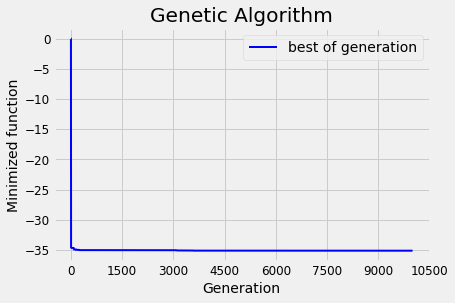

In [908]:
model2.run()

In [909]:
# RMSE 
optimized = val_rnn_30_predict_result * model2.output_dict['variable'][0] + val_lstm_30_predict_result *model2.output_dict['variable'][1] + val_slstm_30_predict_result * model2.output_dict['variable'][2] + val_bilstm_30_predict_result * model2.output_dict['variable'][3] + val_gru_30_predict_result * model2.output_dict['variable'][4]
for i in range(len(optimized)):
    if optimized[i] >= 400: 
        optimized[i]=400
    if optimized[i] <= 60: 
        optimized[i]=60
optimized_rmse_30 =  RMSE(y_val_uni_origin,optimized)
optimized_rmse_30

39.468169963086275

In [910]:
optimized

array([[108.003555],
       [111.05747 ],
       [121.892715],
       [118.42964 ],
       [122.331505],
       [125.6742  ],
       [134.32732 ],
       [133.84021 ],
       [123.40171 ],
       [111.775734],
       [110.86809 ],
       [109.93817 ],
       [121.86679 ],
       [125.40283 ],
       [118.45596 ],
       [123.76563 ],
       [119.143524],
       [141.40994 ],
       [144.97145 ],
       [142.43613 ],
       [154.44742 ],
       [190.3336  ],
       [178.85387 ],
       [175.36272 ],
       [172.98701 ],
       [189.72363 ],
       [187.7529  ],
       [181.31726 ],
       [174.27682 ],
       [169.79416 ],
       [160.12357 ],
       [150.97028 ],
       [144.38193 ],
       [158.29637 ],
       [188.5712  ],
       [213.45012 ],
       [235.57913 ],
       [225.0223  ],
       [237.79555 ],
       [241.00644 ],
       [258.43094 ],
       [237.23459 ],
       [241.09093 ],
       [233.84506 ],
       [225.82474 ],
       [217.6031  ],
       [206.6625  ],
       [206.4

In [911]:
get_optimized = np.array(optimized)

In [912]:
get_optimized = get_optimized.T

In [913]:
get_optimized.shape

(1, 303)

In [916]:
ar_val_30=np.concatenate((get_y_val_origin_30, get_val_rnn_30_predict_result,get_val_lstm_30_predict_result,get_val_slstm_30_predict_result,get_val_bilstm_30_predict_result,get_val_gru_30_predict_result,get_optimized), axis = 0)


In [917]:
ar_train_30 = np.concatenate((get_x_train_origin_30, get_train_rnn_30_predict_result ,get_train_lstm_30_predict_result ,get_train_slstm_30_predict_result,get_train_bilstm_30_predict_result,get_train_gru_30_predict_result),axis=0)

In [ ]:
#ar_val_15=np.concatenate((get_y_val_origin, get_val_rnn_15_predict_result,get_val_lstm_15_predict_result,get_val_slstm_15_predict_result,get_val_bilstm_15_predict_result,get_val_gru_15_predict_result), axis = 0)


In [ ]:
#ar_train_15 = np.concatenate((get_x_train_origin_15, get_train_rnn_15_predict_result ,get_train_lstm_15_predict_result ,get_train_slstm_15_predict_result,get_train_bilstm_15_predict_result,get_train_gru_15_predict_result),axis=0)

In [918]:
y1=pd.DataFrame(ar_val_30,index=['30_val_origin','30_val_rnn','30_val_lstm','30_val_slstm','30_val_bilstm','30_val_gru','30_optimized'])
y1

0           1           2           3           4    \
30_val_origin  112.000000  112.000000  105.000000  101.000000  102.000000   
30_val_rnn      95.033043   95.205978  105.234047  102.521965  106.119949   
30_val_lstm    109.931717  113.334518  122.417809  120.795952  123.088585   
30_val_slstm   111.141159  114.655151  126.419525  121.675789  126.540115   
30_val_bilstm  106.129982  107.624840  119.694695  113.034523  120.178055   
30_val_gru     103.288513  105.139641  119.676239  117.101341  120.843521   
30_optimized   108.003555  111.057472  121.892715  118.429642  122.331505   

                      5           6           7           8           9    \
30_val_origin  105.000000  111.000000  108.000000  102.000000  106.000000   
30_val_rnn     109.199554  117.027061  115.927261  105.724182   98.888870   
30_val_lstm    127.068619  134.320114  134.055099  123.702400  111.268700   
30_val_slstm   129.414871  139.676010  140.201279  128.596390  116.173943   
30_val_bilstm  123.533623  131.716934  127.047325  118.260155  111.054520   
30_val_gru     124.869667  131.721466  126.633064  120.894806  110.301117   
30_optimized   125.674202  134.327316  133.840210  123.401711  111.775734   

                      10          11          12          13          14   \
30_val_origin  106.000000  125.000000  122.000000  121.000000  131.000000   
30_val_rnn     100.935432  105.685715  113.842499  110.319283  101.464333   
30_val_lstm    110.698845  112.293854  125.792229  127.581192  119.094925   
30_val_slstm   114.547379  110.216942  122.613335  129.455124  123.288780   
30_val_bilstm  113.010201  115.539703  124.447479  120.642265  113.208199   
30_val_gru     108.178528  111.053085  118.592018  119.370300  115.589546   
30_optimized   110.868088  109.938171  121.866791  125.402832  118.455963   

                      15          16          17          18          19   \
30_val_origin  154.000000  156.000000  159.000000  163.000000  174.000000   
30_val_rnn     106.266205  106.988991  127.413109  128.212982  128.072617   
30_val_lstm    124.214577  121.210068  151.953751  145.894913  143.372726   
30_val_slstm   129.247299  122.284813  139.690567  151.333313  147.676193   
30_val_bilstm  121.430145  116.413727  139.485733  137.006912  138.829254   
30_val_gru     116.315262  115.375252  132.323563  135.823029  135.559937   
30_optimized   123.765633  119.143524  141.409943  144.971451  142.436127   

                      20          21          22          23          24   \
30_val_origin  181.000000  179.000000  174.000000  170.000000  163.000000   
30_val_rnn     134.576035  158.584839  168.869492  170.343002  169.350479   
30_val_lstm    155.804886  193.553116  180.060699  173.365463  170.511810   
30_val_slstm   161.562271  200.660522  185.056854  182.106659  178.957626   
30_val_bilstm  148.656311  173.935684  170.701874  175.210983  176.560974   
30_val_gru     139.921844  166.149979  169.458481  168.245712  169.468964   
30_optimized   154.447418  190.333603  178.853867  175.362717  172.987015   

                      25          26          27          28          29   \
30_val_origin  155.000000  146.000000  165.000000  183.000000  204.000000   
30_val_rnn     180.341690  185.232315  181.965820  171.081924  164.786636   
30_val_lstm    189.803192  189.714737  183.507812  177.778244  171.631226   
30_val_slstm   196.594620  190.876846  183.477524  176.142944  173.578659   
30_val_bilstm  185.999588  187.585007  179.109589  171.473953  164.926834   
30_val_gru     179.215302  185.614883  182.955246  173.563370  166.474670   
30_optimized   189.723633  187.752899  181.317261  174.276825  169.794159   

                      30          31          32          33          34   \
30_val_origin  218.000000  216.000000  231.000000  242.000000  260.000000   
30_val_rnn     155.517105  145.851776  135.858887  159.608627  183.056122   
30_val_lstm    161.433960  151.446686  140.680893  165.252411  189.574677   
30_val_slstm

In [919]:
y2=pd.DataFrame(ar_train_30,index=['30_train_origin','30_train_rnn','30_train_lstm','30_train_slstm','30_train_bilstm','30_train_gru'])
y2
#y.append(get_val_rnn_15_predict_result,ignore_index=True)

0           1           2           3           4    \
30_train_origin  144.000000  134.000000  120.000000  113.000000  106.000000   
30_train_rnn     146.903046  149.362198  156.803268  161.705231  151.337570   
30_train_lstm    146.802414  149.472687  157.352905  164.765167  152.659805   
30_train_slstm   156.493164  159.289978  173.280792  170.594177  154.554993   
30_train_bilstm  150.977310  154.005386  163.965363  165.388367  152.111404   
30_train_gru     148.693909  151.032196  157.896118  163.153992  156.126007   

                        5           6           7           8           9    \
30_train_origin  101.000000   94.000000   90.000000   88.000000   81.000000   
30_train_rnn     140.393372  140.208984  127.798439  110.063026  103.160271   
30_train_lstm    143.256577  142.971222  130.212433  115.918129  109.337868   
30_train_slstm   146.080109  150.083923  134.714691  118.689972  100.672791   
30_train_bilstm  143.100571  144.377182  131.289825  112.442177  110.681999   
30_train_gru     145.587479  143.154419  134.125107  116.803116  107.947823   

                        10         11         12         13         14   \
30_train_origin   83.000000  91.000000  94.000000  97.000000  99.000000   
30_train_rnn      98.367569  95.284645  88.414665  85.506363  85.143829   
30_train_lstm    104.402977  99.049393  91.729424  86.417847  91.737305   
30_train_slstm    96.213753  91.723648  84.331993  86.044731  90.237289   
30_train_bilstm  102.228706  99.018875  92.463165  93.557785  95.131721   
30_train_gru     103.486221  99.699837  94.581078  92.008797  91.811752   

                       15          16          17          18          19   \
30_train_origin  98.000000   98.000000   99.000000  103.000000  106.000000   
30_train_rnn     77.970688   82.099884   92.241959   99.241249  103.739342   
30_train_lstm    88.629349  101.066757  108.834694  108.655998  108.525246   
30_train_slstm   89.744980  101.400627  103.953278  106.262398  110.912468   
30_train_bilstm  86.542267   91.695557  106.162849  111.306183  117.395584   
30_train_gru     87.836807   92.550018  107.907204  111.310364  113.672783   

                        20          21          22          23          24   \
30_train_origin  109.000000  113.000000  117.000000  120.000000  123.000000   
30_train_rnn     105.366531  102.442696   99.866066  100.785706  105.852219   
30_train_lstm    111.149750  114.694824  118.341362  119.756584  123.945564   
30_train_slstm   116.987656  109.364960  113.469566  119.556152  128.221588   
30_train_bilstm  123.167992  117.532898  114.190277  114.569138  119.515633   
30_train_gru     111.858803  114.810883  116.728081  117.293564  120.149437   

                        25          26          27          28          29   \
30_train_origin  123.000000  124.000000  122.000000  122.000000  121.000000   
30_train_rnn     109.477669  113.164902  117.550476  122.069595  124.748138   
30_train_lstm    127.513016  130.854614  135.714630  140.532654  143.008987   
30_train_slstm   133.953079  137.947662  145.770813  151.991043  150.706009   
30_train_bilstm  121.779961  125.969086  131.325516  135.468369  136.525269   
30_train_gru     122.622810  126.884964  131.084961  134.782745  133.261963   

                        30          31          32          33          34   \
30_train_origin  117.000000  115.000000  111.000000  111.000000  111.000000   
30_train_rnn     127.098930  125.408684  125.346512  121.904350  121.594826   
30_train_lstm    144.271652  135.435226  125.772232  121.689125  121.277679   
30_train_slstm   147.503082  134.155823  128.582855  124.815254  125.207359   
30_train_bilstm  137.854828  134.094223  132.554337  127.337898  126.637733   
30_train_gru     133.266388  131.795441  130.749832  127.870171  126.573204   

                        35          36          37          38          39   \
30_train_origin  109.000000  106.000000  105.000000  105.000000  104.000000   
30_train_rnn     120.16

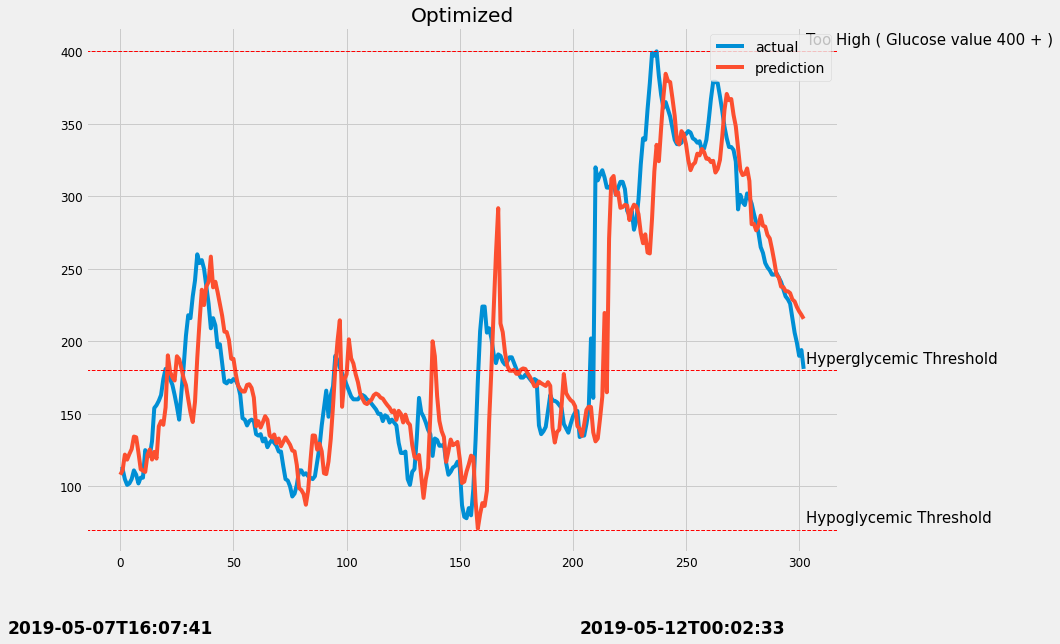

In [920]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(optimized,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(y_val_uni_origin),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(y_val_uni_origin)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

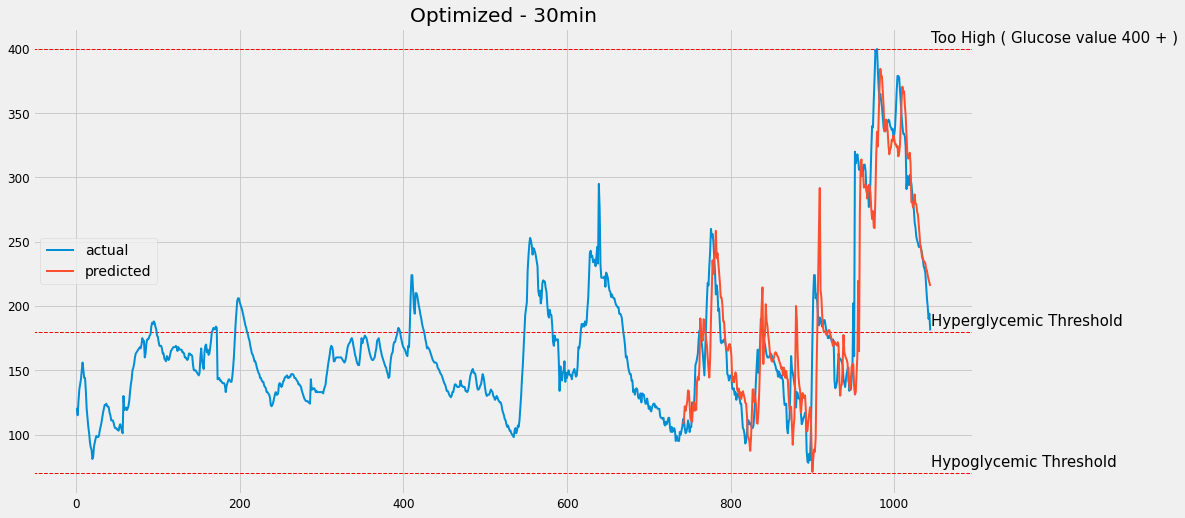

In [921]:
# Make a new dataframe of your prediction values
df_new = pd.DataFrame(df['Glucose'])
df_new.columns = ['rawseq']

# Retrieve index values
new_index = df_new['rawseq'].tail(len(optimized)).index

# Make a dataframe with your prediction values and your index
new_series = pd.DataFrame(index = new_index, data = optimized)

# Merge the dataframes
df_new = pd.merge(df_new, new_series, how = 'left', left_index=True, right_index=True)
df_new.columns = ['rawseq', 'optimized']

# And plot it
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))

plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)

plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(raw_seq),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(raw_seq),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(raw_seq),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized - 30min',family='Times New Roman')
plt.plot(df_new['rawseq'],label='actual',linewidth=2)
plt.plot(df_new['optimized'], label='predicted',linewidth=2)
plt.legend(loc='best')
plt.show()

#### GA_Residual

Text(0.5, 1.0, '30Min GA Normal Q-Q Plot')

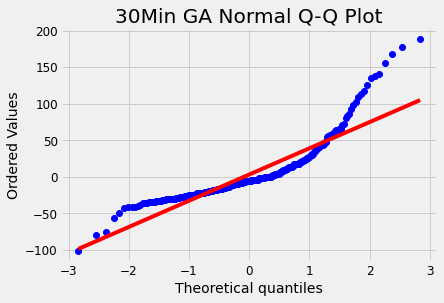

In [922]:
residuals = [y_val_uni_origin[i]-optimized[i] for i in range(len(optimized))]
residuals = y_val_uni_origin - optimized.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("30Min GA Normal Q-Q Plot")

Text(0.5, 1.0, '30Min GA Normal Q-Q Plot')

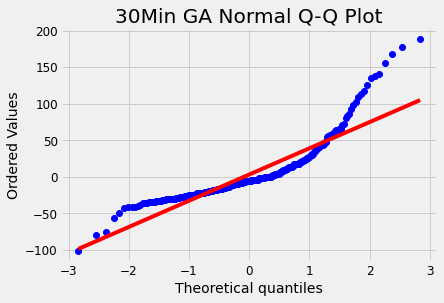

In [923]:
probplot(residuals,dist="norm",plot=plt)
plt.title("30Min GA Normal Q-Q Plot")

In [924]:
residuals=DataFrame(residuals)

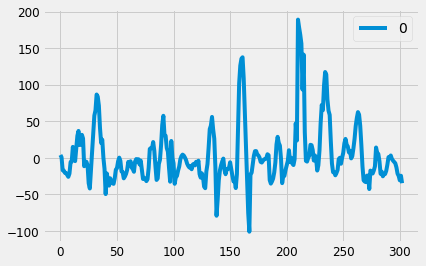

In [925]:
residuals.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f91a46c7d90>]],
      dtype=object)

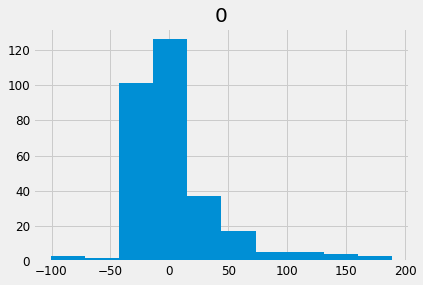

In [926]:

residuals.hist()

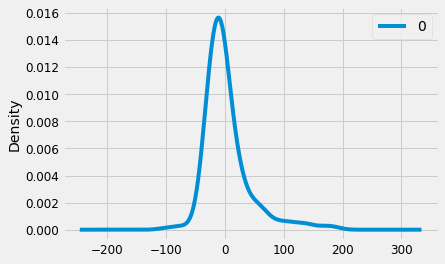

In [927]:
residuals.plot(kind='kde')

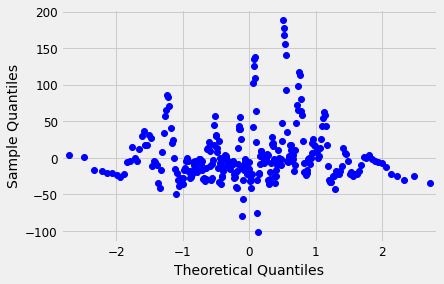

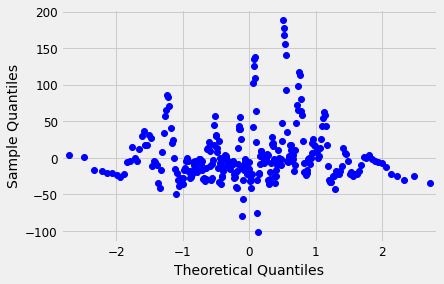

In [928]:
from statsmodels.graphics.gofplots import qqplot
residuals=np.array(residuals)
qqplot(residuals)

In [929]:
model2.output_dict

{'function': -35.11831614397819,
 'last_generation': {'scores': array([-35.11831614, -35.11831614, -35.11831614, -35.11831614,
         -35.11831614, -35.11831614, -35.11831614, -35.11831614,
         -35.11831614, -35.11831614, -35.11831614, -35.11831614,
         -35.11831614, -35.11831614, -35.11831614, -35.11831614,
         -35.11831614, -35.11831614, -35.11831614, -35.11831614,
         -35.11831614, -35.11831614, -35.11831614, -35.11831614,
         -35.11831614, -35.11831614, -35.11831614, -35.11831614,
         -35.11831614, -35.11831614, -35.11831614, -35.11831614,
         -35.11831614, -35.11831614, -35.11831614, -35.11831614,
         -35.11831614, -35.11831614, -35.11831614, -35.11831614,
         -35.11831614, -35.11831614, -35.11831614, -35.11831614,
         -35.11831614, -35.11831614, -35.11831614, -35.11831614,
         -35.11831614, -35.11831614, -35.11831614, -35.11831614,
         -35.11831614, -35.11831614, -35.11831614, -35.11831614,
         -35.11831614, -35.1

In [930]:
#model2.output_dict['variable'][0]


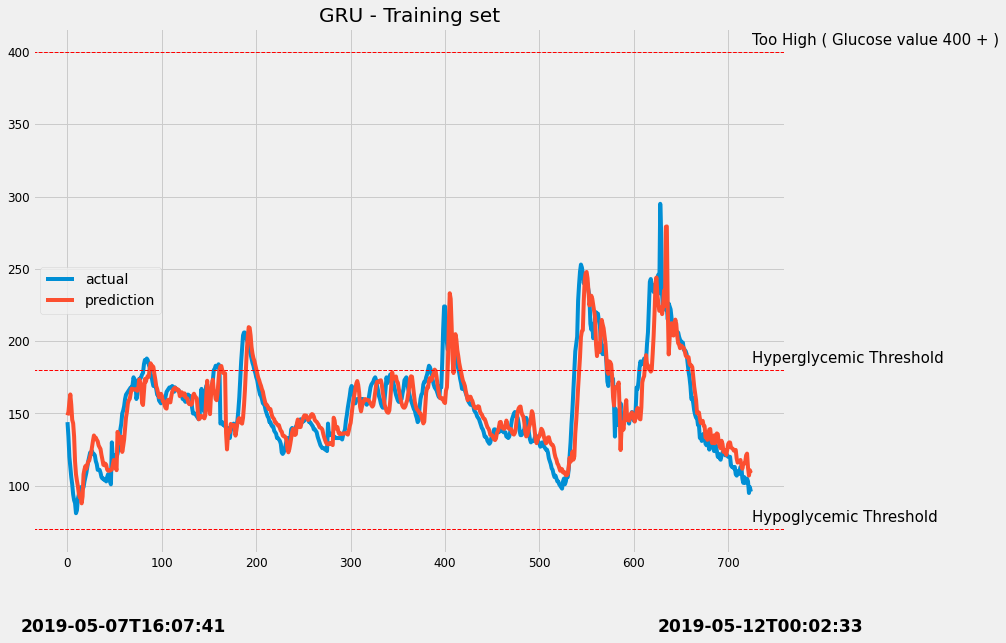

In [931]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

## 60분

In [932]:
# SG필터 테스트 
#import scipy.signal 

#yhat = scipy.signal.savgol_filter(raw_seq,15,5)
#plt.plot(raw_seq)
#plt.plot(yhat,color='red')
#plt.show()

In [933]:
#TRAIN_SPLIT=int(len(raw_seq)*0.7)
#uni_past_history=6
#uni_future_target=11
#x_train_uni,y_train_uni = uni_data(yhat,0,TRAIN_SPLIT,
#                                  uni_past_history,
#                                  uni_future_target)
#x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
#                            uni_past_history,
#                            uni_future_target)



In [934]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=11
x_train_uni,y_train_uni = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [935]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=11
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)



In [936]:
x_train_uni[0]

array([[120],
       [120],
       [115],
       [126],
       [135],
       [139]])

In [937]:
y_train_uni[0]

94

In [938]:
df['Glucose'].head(20)

0     120.0
1     120.0
2     115.0
3     126.0
4     135.0
5     139.0
6     143.0
7     150.0
8     156.0
9     150.0
10    144.0
11    144.0
12    134.0
13    120.0
14    113.0
15    106.0
16    101.0
17     94.0
18     90.0
19     88.0
Name: Glucose, dtype: float64

### RNN - 60분

In [939]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [940]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_uni.shape[-2:])) # recurrent_dropout=0.2
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)
K.clear_session()

In [941]:
val_rnn_60_predict_result = model.predict(x_val_uni,verbose=0)

In [942]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    if predict_result[i] <= 60: 
        predict_result[i]=60

# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_rnn_60 = RMSE(y_val_uni_origin,predict_result)
val_rnn_60_predict_result=predict_result

 Vanila RNN (Simple RNN) - RMSE (15min) :  52.87831377936206


In [943]:
get_x_train_origin_60 = np.array(y_train_uni_origin)

In [944]:
get_x_train_origin_60 = get_x_train_origin_60.reshape(1,len(y_train_uni_origin))

In [945]:
get_x_train_origin_60.shape

(1, 725)

In [946]:
get_y_val_origin_60 = np.array(y_val_uni_origin)

In [947]:
get_y_val_origin_60 = get_y_val_origin_60.reshape(1,len(get_y_val_origin_60))

In [948]:
get_y_val_origin_60.shape

(1, 297)

In [949]:
#get_y_val_origin

In [950]:
get_val_rnn_60_predict_result = np.array(val_rnn_60_predict_result)

In [951]:
get_val_rnn_60_predict_result = get_val_rnn_60_predict_result.T

In [952]:
get_val_rnn_60_predict_result.shape

(1, 297)

In [953]:
predict_result

array([[115.368866],
       [112.46309 ],
       [122.87003 ],
       [123.57333 ],
       [125.81327 ],
       [126.17391 ],
       [135.272   ],
       [135.08665 ],
       [125.00701 ],
       [114.10705 ],
       [113.99294 ],
       [122.21692 ],
       [132.28603 ],
       [130.96626 ],
       [120.87558 ],
       [119.46079 ],
       [122.92394 ],
       [143.9684  ],
       [146.4215  ],
       [144.05583 ],
       [144.17017 ],
       [169.71333 ],
       [182.96475 ],
       [180.31923 ],
       [172.27034 ],
       [183.97055 ],
       [192.48645 ],
       [189.73201 ],
       [175.02826 ],
       [165.93228 ],
       [158.40207 ],
       [150.77234 ],
       [140.7316  ],
       [167.11876 ],
       [191.81128 ],
       [228.7833  ],
       [238.83545 ],
       [229.95703 ],
       [232.09904 ],
       [239.68182 ],
       [262.71497 ],
       [249.8739  ],
       [245.48564 ],
       [232.0385  ],
       [219.4694  ],
       [203.18349 ],
       [183.02045 ],
       [196.5

In [954]:
y_val_uni_origin

array([111, 108, 102, 106, 106, 125, 122, 121, 131, 154, 156, 159, 163,
       174, 181, 179, 174, 170, 163, 155, 146, 165, 183, 204, 218, 216,
       231, 242, 260, 254, 256, 250, 238, 226, 209, 216, 211, 196, 198,
       185, 172, 171, 173, 172, 174, 173, 170, 163, 147, 146, 142, 145,
       146, 145, 136, 135, 136, 131, 133, 127, 130, 132, 130, 128, 124,
       124, 114, 105, 104, 100,  93,  95, 101, 111, 111, 108, 109, 107,
       106, 105, 107, 117, 127, 142, 154, 166, 148, 163, 169, 190, 187,
       182, 178, 174, 170, 166, 162, 160, 160, 160, 162, 163, 162, 160,
       159, 157, 155, 153, 150, 150, 145, 149, 148, 144, 146, 144, 142,
       130, 123, 123, 124, 105, 101, 110, 112, 133, 161, 151, 148, 144,
       139, 136, 121, 133, 132, 128, 128, 129, 116, 108, 110, 113, 114,
       117, 113,  87,  79,  78,  85,  80,  98, 132, 173, 207, 224, 224,
       206, 209, 202, 191, 185, 191, 190, 186, 184, 186, 189, 189, 185,
       181, 178, 175, 175, 177, 176, 174, 172, 174, 173, 142, 13

#### 잔차

In [955]:
y_val_uni_origin

array([111, 108, 102, 106, 106, 125, 122, 121, 131, 154, 156, 159, 163,
       174, 181, 179, 174, 170, 163, 155, 146, 165, 183, 204, 218, 216,
       231, 242, 260, 254, 256, 250, 238, 226, 209, 216, 211, 196, 198,
       185, 172, 171, 173, 172, 174, 173, 170, 163, 147, 146, 142, 145,
       146, 145, 136, 135, 136, 131, 133, 127, 130, 132, 130, 128, 124,
       124, 114, 105, 104, 100,  93,  95, 101, 111, 111, 108, 109, 107,
       106, 105, 107, 117, 127, 142, 154, 166, 148, 163, 169, 190, 187,
       182, 178, 174, 170, 166, 162, 160, 160, 160, 162, 163, 162, 160,
       159, 157, 155, 153, 150, 150, 145, 149, 148, 144, 146, 144, 142,
       130, 123, 123, 124, 105, 101, 110, 112, 133, 161, 151, 148, 144,
       139, 136, 121, 133, 132, 128, 128, 129, 116, 108, 110, 113, 114,
       117, 113,  87,  79,  78,  85,  80,  98, 132, 173, 207, 224, 224,
       206, 209, 202, 191, 185, 191, 190, 186, 184, 186, 189, 189, 185,
       181, 178, 175, 175, 177, 176, 174, 172, 174, 173, 142, 13

In [956]:
val_rnn_60_predict_result

array([[115.368866],
       [112.46309 ],
       [122.87003 ],
       [123.57333 ],
       [125.81327 ],
       [126.17391 ],
       [135.272   ],
       [135.08665 ],
       [125.00701 ],
       [114.10705 ],
       [113.99294 ],
       [122.21692 ],
       [132.28603 ],
       [130.96626 ],
       [120.87558 ],
       [119.46079 ],
       [122.92394 ],
       [143.9684  ],
       [146.4215  ],
       [144.05583 ],
       [144.17017 ],
       [169.71333 ],
       [182.96475 ],
       [180.31923 ],
       [172.27034 ],
       [183.97055 ],
       [192.48645 ],
       [189.73201 ],
       [175.02826 ],
       [165.93228 ],
       [158.40207 ],
       [150.77234 ],
       [140.7316  ],
       [167.11876 ],
       [191.81128 ],
       [228.7833  ],
       [238.83545 ],
       [229.95703 ],
       [232.09904 ],
       [239.68182 ],
       [262.71497 ],
       [249.8739  ],
       [245.48564 ],
       [232.0385  ],
       [219.4694  ],
       [203.18349 ],
       [183.02045 ],
       [196.5

In [957]:
#zone_accuracy(y_val_uni_origin,val_rnn_60_predict_result,mode='clarke',detailed=False,diabetes_type=2)

Text(0.5, 1.0, 'Simple RNN Q-Q Plot')

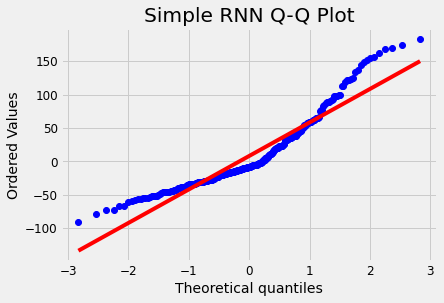

In [958]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(val_rnn_60_predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Q-Q Plot")

#### Validation

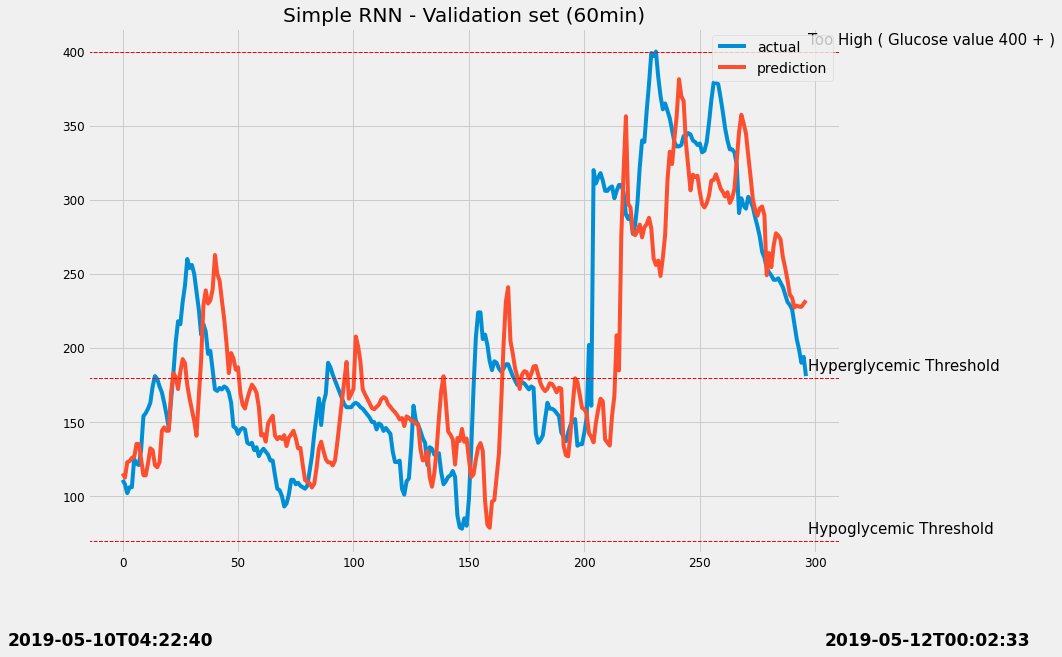

In [959]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'Simple RNN 60min Normal Q-Q Plot')

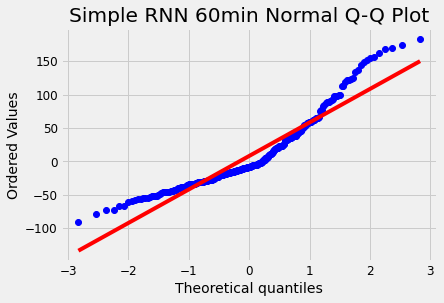

In [960]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)

#residuals

probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN 60min Normal Q-Q Plot")

In [961]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400    
    if predict_result[i] <= 60: 
        predict_result[i]=60          
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,predict_result))
train_rnn_60=RMSE(y_train_uni_origin,predict_result)
train_rnn_60_predict_result=predict_result

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  25.36070105019322


In [962]:
y_train_uni_origin

array([ 94,  90,  88,  81,  83,  91,  94,  97,  99,  98,  98,  99, 103,
       106, 109, 113, 117, 120, 123, 123, 124, 122, 122, 121, 117, 115,
       111, 111, 111, 109, 106, 105, 105, 104, 104, 103, 106, 108, 106,
       103, 101, 130, 119, 120, 121, 119, 120, 122, 126, 133, 139, 143,
       150, 152, 155, 160, 163, 164, 165, 166, 167, 168, 167, 170, 175,
       172, 173, 160, 163, 171, 174, 174, 175, 177, 178, 184, 187, 186,
       188, 187, 184, 182, 177, 176, 172, 169, 169, 169, 167, 163, 163,
       159, 158, 157, 161, 160, 158, 159, 162, 165, 166, 167, 168, 168,
       168, 169, 168, 165, 168, 167, 166, 166, 166, 164, 164, 163, 160,
       160, 159, 158, 159, 163, 163, 162, 162, 161, 154, 150, 150, 150,
       149, 148, 147, 146, 148, 160, 167, 158, 154, 151, 164, 169, 170,
       164, 166, 162, 163, 168, 173, 180, 181, 183, 182, 182, 184, 183,
       143, 144, 144, 142, 142, 141, 140, 140, 140, 138, 133, 138, 140,
       142, 143, 142, 141, 141, 145, 152, 161, 173, 186, 195, 20

In [963]:
predict_result

array([[163.90686 ],
       [161.79475 ],
       [165.18004 ],
       [171.11957 ],
       [163.3859  ],
       [148.9416  ],
       [145.13148 ],
       [134.99475 ],
       [119.97045 ],
       [111.85569 ],
       [104.99528 ],
       [104.94593 ],
       [100.50539 ],
       [100.18082 ],
       [100.75555 ],
       [ 96.96956 ],
       [ 99.6573  ],
       [110.151054],
       [115.41952 ],
       [120.20683 ],
       [121.96149 ],
       [120.96107 ],
       [119.04079 ],
       [118.72352 ],
       [124.11131 ],
       [128.81297 ],
       [132.53033 ],
       [135.11852 ],
       [138.8342  ],
       [141.28708 ],
       [142.65378 ],
       [140.7756  ],
       [139.82233 ],
       [135.906   ],
       [135.18645 ],
       [133.30063 ],
       [129.37239 ],
       [125.872215],
       [121.17982 ],
       [123.082954],
       [124.70936 ],
       [125.30935 ],
       [121.252846],
       [119.329796],
       [120.39643 ],
       [121.390526],
       [121.72022 ],
       [120.7

In [964]:
get_train_rnn_60_predict_result = np.array(train_rnn_60_predict_result)

In [965]:
get_train_rnn_60_predict_result = get_train_rnn_60_predict_result.T

In [966]:
get_train_rnn_60_predict_result.shape

(1, 725)

#### Train

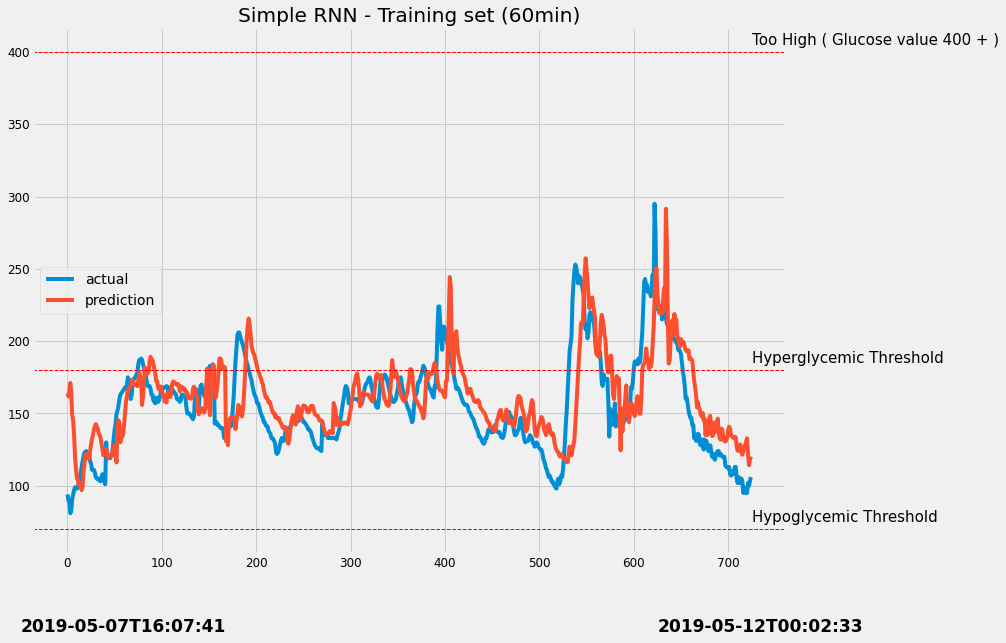

In [967]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### LSTM - 60분

In [968]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [969]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_uni.shape[-2:]))  #recurrent_dropout=0.2, unit_forget_bias=False
model.add(Dense(1))


model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()
val_lstm_60_predict_result = model.predict(x_val_uni,verbose=0)

In [970]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

    elif predict_result[i] <= 60: 
        predict_result[i]=60

#predict_result

print(' LSTM - RMSE (60min) : ',RMSE(y_val_uni_origin,predict_result))
val_lstm_60=RMSE(y_val_uni_origin,predict_result)
val_lstm_60_predict_result=predict_result

 LSTM - RMSE (60min) :  54.778030662225625


In [971]:
get_val_lstm_60_predict_result = np.array(val_lstm_60_predict_result)

In [972]:
get_val_lstm_60_predict_result = get_val_lstm_60_predict_result.T

In [973]:
get_val_lstm_60_predict_result.shape

(1, 297)

In [974]:
predict_result

array([[127.561386],
       [129.70445 ],
       [150.87895 ],
       [135.68578 ],
       [146.1504  ],
       [151.02937 ],
       [162.9707  ],
       [150.62823 ],
       [134.53522 ],
       [119.004845],
       [113.587616],
       [115.974556],
       [133.70067 ],
       [138.60606 ],
       [131.34236 ],
       [129.21202 ],
       [125.73847 ],
       [158.45387 ],
       [154.59854 ],
       [154.56412 ],
       [146.6757  ],
       [176.01456 ],
       [175.54854 ],
       [177.42126 ],
       [177.73901 ],
       [189.90277 ],
       [190.83871 ],
       [180.209   ],
       [170.06151 ],
       [165.06448 ],
       [154.54845 ],
       [148.02011 ],
       [144.83934 ],
       [159.29106 ],
       [188.82344 ],
       [192.96217 ],
       [223.30605 ],
       [216.89084 ],
       [220.53348 ],
       [226.63562 ],
       [239.14114 ],
       [226.20512 ],
       [222.23    ],
       [216.15135 ],
       [210.46965 ],
       [206.92752 ],
       [196.73228 ],
       [194.0

#### 잔차

Text(0.5, 1.0, 'LSTM Q-Q Plot')

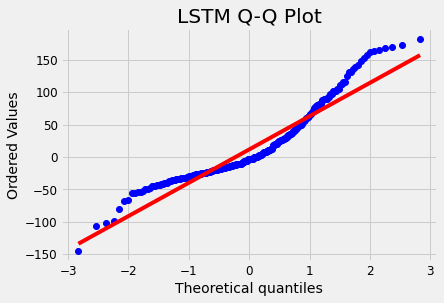

In [975]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Q-Q Plot")

#### Validation

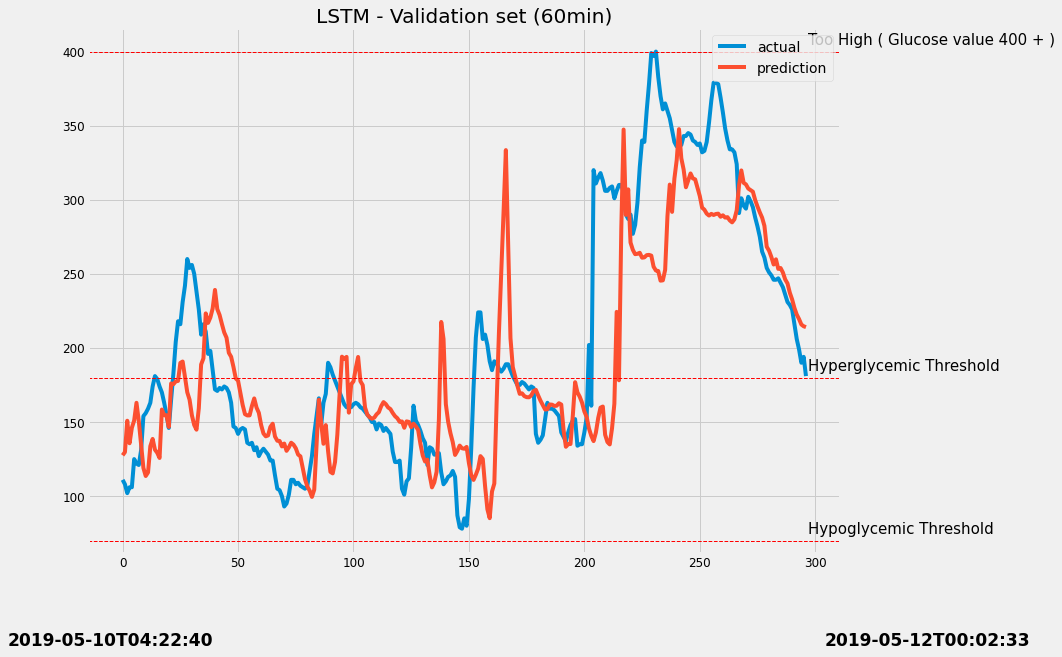

In [976]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [977]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    if predict_result[i] <= 60: 
        predict_result[i]=60
print(' LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_lstm_60 =RMSE(y_train_uni_origin,predict_result)
train_lstm_60_predict_result=predict_result

 LSTM - RMSE (60min) Training set :  22.772640730551156


In [978]:
get_train_lstm_60_predict_result = np.array(train_lstm_60_predict_result)

In [979]:
get_train_lstm_60_predict_result = get_train_lstm_60_predict_result.T

In [980]:
get_train_lstm_60_predict_result.shape

(1, 725)

#### Train

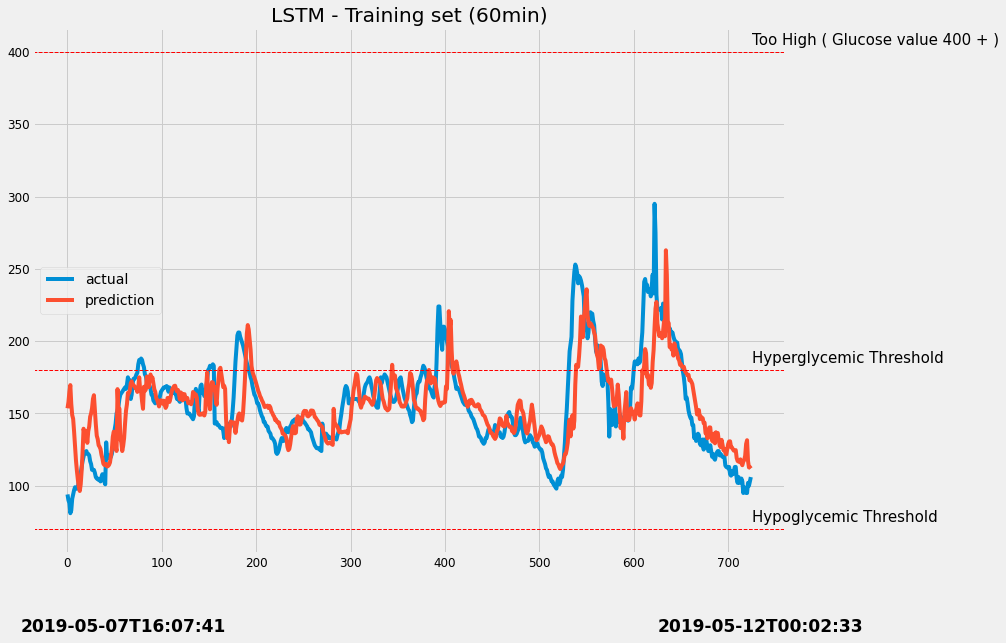

In [981]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 60분

In [982]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [983]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_uni.shape[-2:])) # recurrent_dropout=0.2
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [984]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()

In [985]:
val_slstm_60_predict_result = model.predict(x_val_uni,verbose=0)

In [986]:
predict_result = model.predict(x_val_uni,verbose=0)


for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    if predict_result[i] <= 60: 
        predict_result[i]=60

print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,predict_result))
val_stacklstm_60 =RMSE(y_val_uni_origin,predict_result)
val_slstm_60_predict_result=predict_result

 Stacked LSTM - RMSE(15min) :  54.70345761659378


In [987]:
predict_result

array([[123.58698 ],
       [132.5202  ],
       [176.64864 ],
       [134.68832 ],
       [153.59929 ],
       [153.285   ],
       [165.87949 ],
       [138.06578 ],
       [146.75356 ],
       [129.86217 ],
       [117.52802 ],
       [125.38838 ],
       [146.27492 ],
       [134.78157 ],
       [138.22017 ],
       [139.25452 ],
       [131.46077 ],
       [181.038   ],
       [132.30959 ],
       [147.66095 ],
       [157.61781 ],
       [223.85982 ],
       [206.00545 ],
       [197.63258 ],
       [180.77861 ],
       [189.14714 ],
       [183.068   ],
       [176.0831  ],
       [168.91881 ],
       [165.84883 ],
       [158.61938 ],
       [145.81099 ],
       [138.22958 ],
       [152.09807 ],
       [190.56744 ],
       [219.97981 ],
       [230.04922 ],
       [207.7002  ],
       [220.62561 ],
       [222.529   ],
       [238.75609 ],
       [217.94449 ],
       [221.31839 ],
       [215.28587 ],
       [215.98029 ],
       [207.13557 ],
       [193.92516 ],
       [186.9

In [988]:
get_val_slstm_60_predict_result = np.array(val_slstm_60_predict_result)

In [989]:
get_val_slstm_60_predict_result = get_val_slstm_60_predict_result.T

In [990]:
get_val_slstm_60_predict_result.shape

(1, 297)

#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Q-Q Plot')

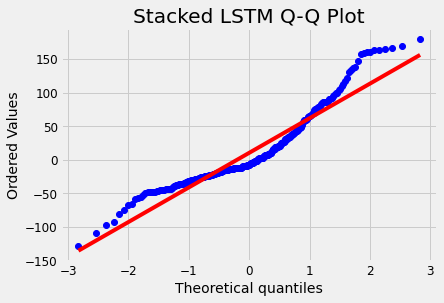

In [991]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Q-Q Plot")

#### Validation

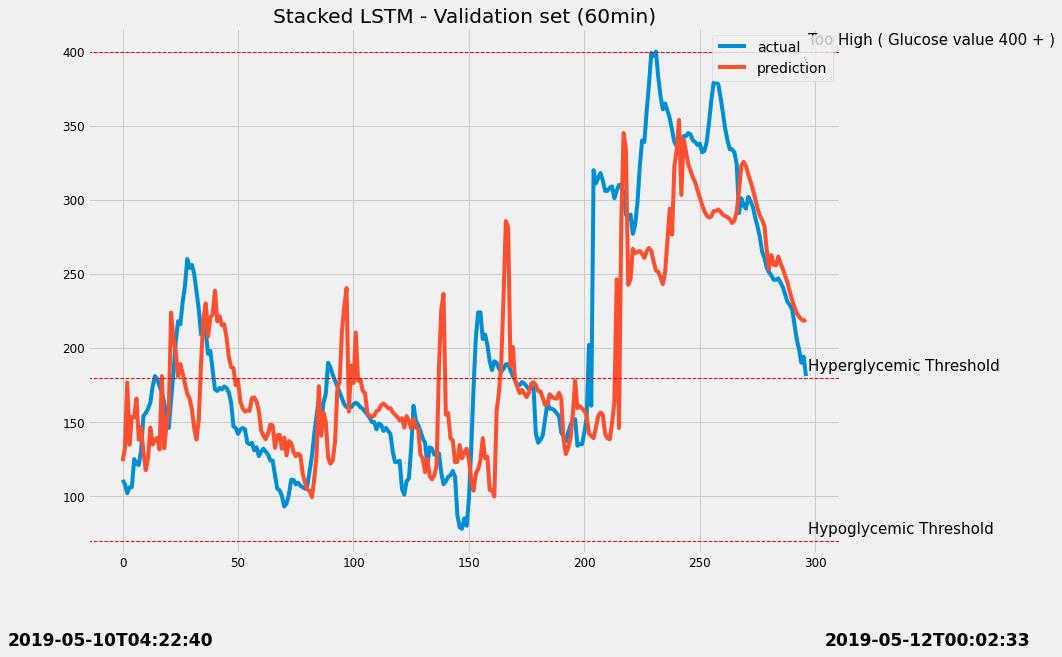

In [992]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [993]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

    if predict_result[i] <= 60: 
        predict_result[i]=60
print(' Training set / STACKED LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_stacklstm_60 = RMSE(y_train_uni_origin,predict_result)
train_slstm_60_predict_result=predict_result

 Training set / STACKED LSTM - RMSE (60min) Training set :  22.258370447217814


In [994]:
get_train_slstm_60_predict_result = np.array(train_slstm_60_predict_result)

In [995]:
get_train_slstm_60_predict_result = get_train_slstm_60_predict_result.T

In [996]:
get_train_slstm_60_predict_result.shape

(1, 725)

#### Train

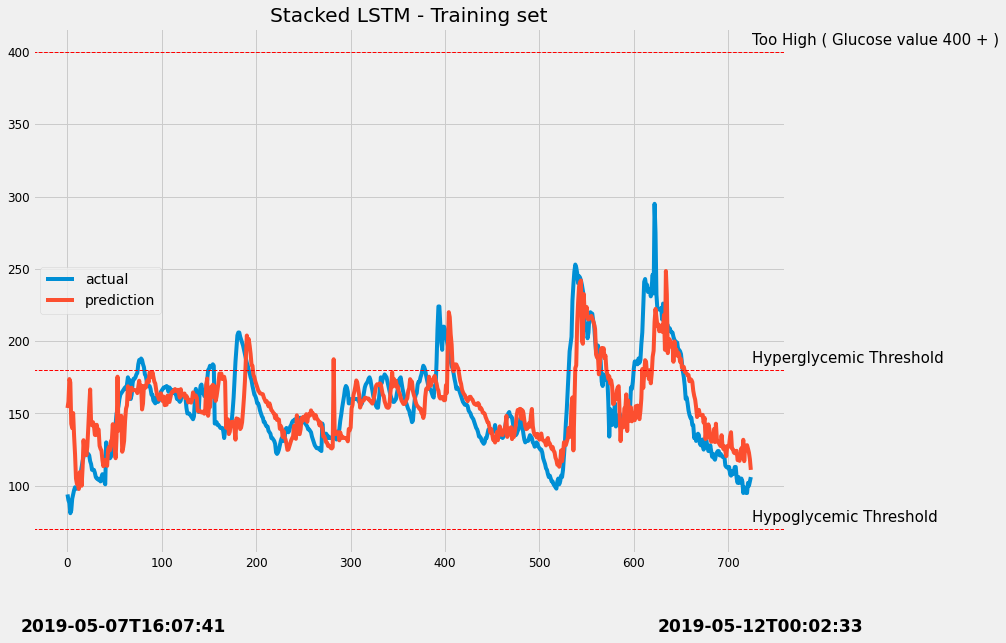

In [997]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 60분

In [998]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [999]:
from keras.layers import Bidirectional
from tensorflow.keras import layers
model = Sequential()

model.add(Bidirectional(LSTM(50,activation='relu',return_sequences=True),input_shape=x_train_uni.shape[-2:]))
model.add(Bidirectional(layers.LSTM(50,activation='relu')))
#model.add(Bidirectional(forward_layer,backward_layer=backward_layer,input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [1000]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()
val_bilstm_60_predict_result = model.predict(x_val_uni,verbose=0)

In [1001]:
predict_result.shape

(725, 1)

In [1002]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

    if predict_result[i] <= 60: 
        predict_result[i]=60

print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,predict_result))
val_bilstm_60 = RMSE(y_val_uni_origin,predict_result)
val_bilstm_60_predict_result = predict_result

Bidirectional LSTM - RMSE :  58.69332444448786


In [1003]:
get_val_bilstm_60_predict_result = np.array(val_bilstm_60_predict_result)

In [1004]:
get_val_bilstm_60_predict_result = get_val_bilstm_60_predict_result.T

In [1005]:
get_val_bilstm_60_predict_result.shape

(1, 297)

In [1006]:
predict_result

array([[139.90634 ],
       [134.3116  ],
       [171.10356 ],
       [157.02365 ],
       [149.3856  ],
       [151.7617  ],
       [190.42476 ],
       [170.972   ],
       [169.41377 ],
       [121.97929 ],
       [117.170876],
       [137.66396 ],
       [188.11363 ],
       [171.55437 ],
       [159.32657 ],
       [140.89027 ],
       [129.41238 ],
       [217.97853 ],
       [178.74728 ],
       [173.51236 ],
       [236.58644 ],
       [188.43999 ],
       [166.39606 ],
       [181.02882 ],
       [171.55318 ],
       [216.45502 ],
       [181.81259 ],
       [183.23532 ],
       [180.93365 ],
       [170.44066 ],
       [161.29439 ],
       [148.67924 ],
       [140.61852 ],
       [156.94447 ],
       [213.37842 ],
       [248.41147 ],
       [201.0706  ],
       [212.81702 ],
       [281.4614  ],
       [235.58049 ],
       [297.24457 ],
       [254.431   ],
       [222.59082 ],
       [223.14803 ],
       [214.60402 ],
       [203.08514 ],
       [196.319   ],
       [194.7

#### Validation

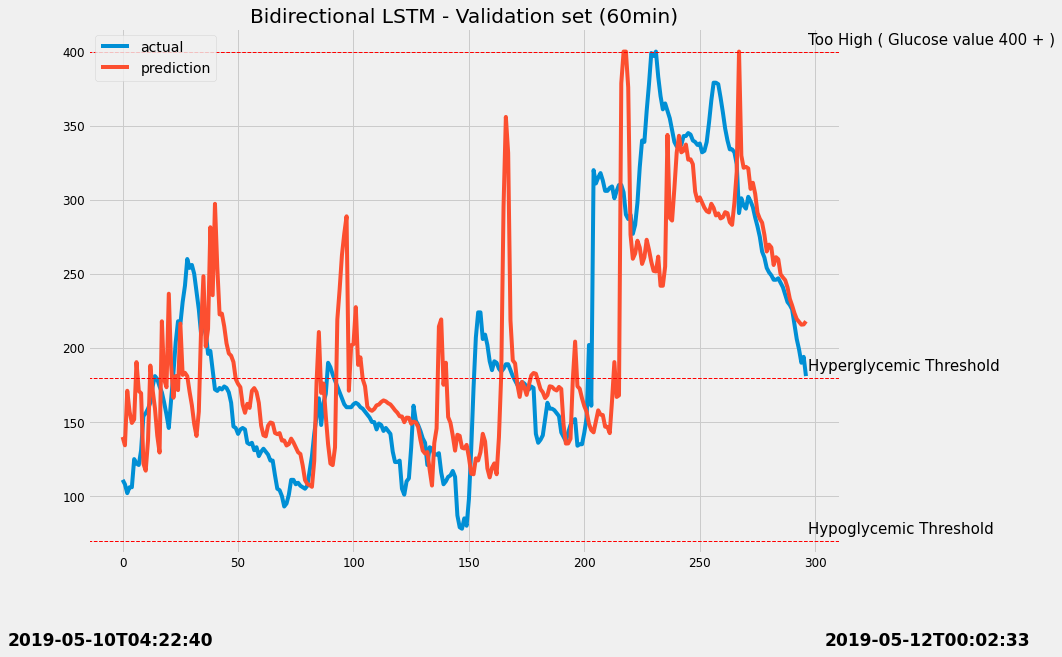

In [1007]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Q-Q Plot')

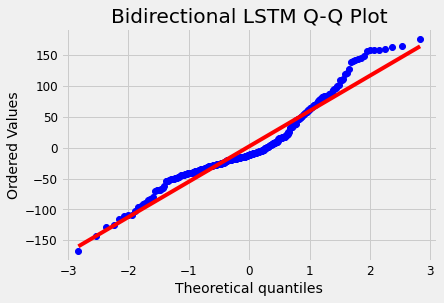

In [1008]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Q-Q Plot")

In [1009]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    if predict_result[i] <= 60: 
        predict_result[i]=60
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_bilstm_60 = RMSE(y_train_uni_origin,predict_result)
train_bilstm_60_predict_result=predict_result

 Training set / Bidirectional LSTM - RMSE (60min) Training set :  21.900962892867163


In [1010]:
get_train_bilstm_60_predict_result = np.array(train_bilstm_60_predict_result)

In [1011]:
get_train_bilstm_60_predict_result = get_train_bilstm_60_predict_result.T

In [1012]:
get_train_bilstm_60_predict_result.shape

(1, 725)

#### Train

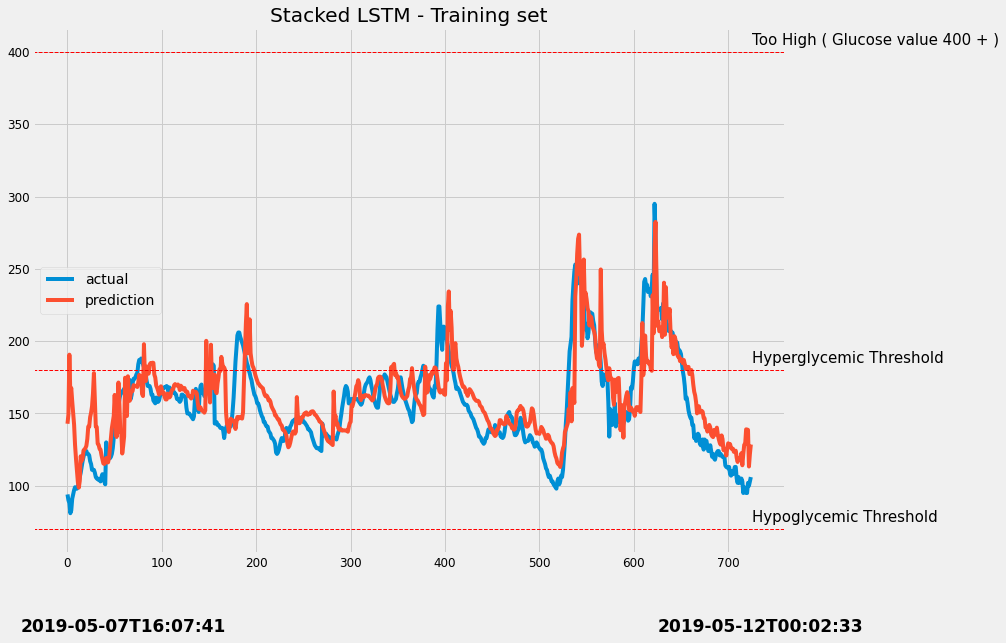

In [1013]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 60분

In [1014]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [1015]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [1016]:
model.summary()

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [1017]:
val_gru_60_predict_result = model.predict(x_val_uni,verbose=0)
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    if predict_result[i] <= 60: 
        predict_result[i]=60

#predict_result

#predict_result


print('GRU - RMSE 60min : ',RMSE(y_val_uni_origin,predict_result))
val_gru_60 = RMSE(y_val_uni_origin,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63
val_gru_60_predict_result=predict_result

GRU - RMSE 60min :  54.23238431363365


In [1018]:
get_val_gru_60_predict_result = np.array(val_gru_60_predict_result)

In [1019]:
get_val_gru_60_predict_result = get_val_gru_60_predict_result.T

In [1020]:
get_val_gru_60_predict_result.shape

(1, 297)

In [1021]:
predict_result

array([[123.841484],
       [128.40366 ],
       [149.93073 ],
       [136.38417 ],
       [143.8155  ],
       [144.05536 ],
       [156.1238  ],
       [143.42596 ],
       [137.17644 ],
       [132.23967 ],
       [133.03496 ],
       [128.25818 ],
       [135.39513 ],
       [136.00299 ],
       [132.13177 ],
       [146.15025 ],
       [133.08391 ],
       [152.68614 ],
       [146.495   ],
       [162.50258 ],
       [167.26051 ],
       [189.03111 ],
       [165.4831  ],
       [184.03307 ],
       [182.50839 ],
       [187.71707 ],
       [183.37767 ],
       [176.60945 ],
       [175.4633  ],
       [169.09761 ],
       [156.63167 ],
       [147.80843 ],
       [138.07628 ],
       [159.34242 ],
       [188.74246 ],
       [212.53111 ],
       [235.54282 ],
       [229.25044 ],
       [233.71408 ],
       [240.28416 ],
       [255.56458 ],
       [223.72643 ],
       [231.5984  ],
       [218.64606 ],
       [209.27542 ],
       [187.96277 ],
       [172.03004 ],
       [195.6

#### 잔차

Text(0.5, 1.0, 'GRU Q-Q Plot')

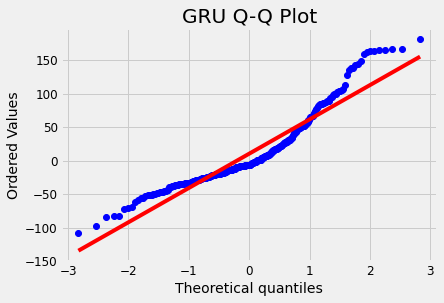

In [1022]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Q-Q Plot")

#### Validation

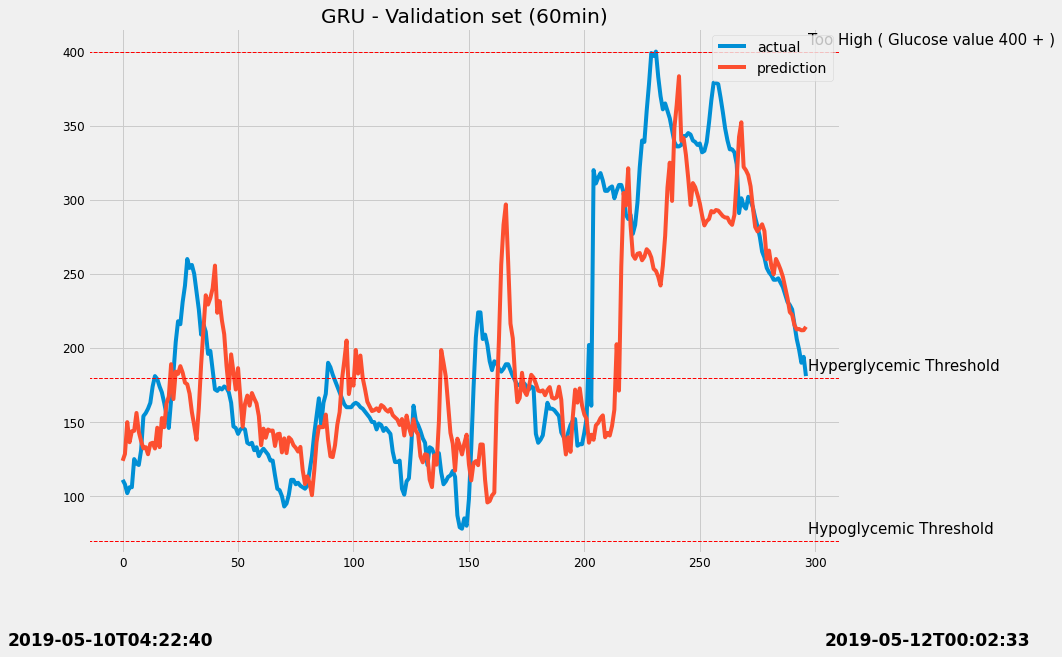

In [1023]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [1024]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

    if predict_result[i] <= 60: 
        predict_result[i]=60
print(' Training set / GRU - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_gru_60 =RMSE(y_train_uni_origin,predict_result)
train_gru_60_predict_result=predict_result

 Training set / GRU - RMSE (60min) Training set :  23.228811344804893


In [1025]:
get_train_gru_60_predict_result = np.array(train_gru_60_predict_result)

In [1026]:
get_train_gru_60_predict_result = get_train_gru_60_predict_result.T

In [1027]:
get_train_gru_60_predict_result.shape

(1, 725)

#### Train

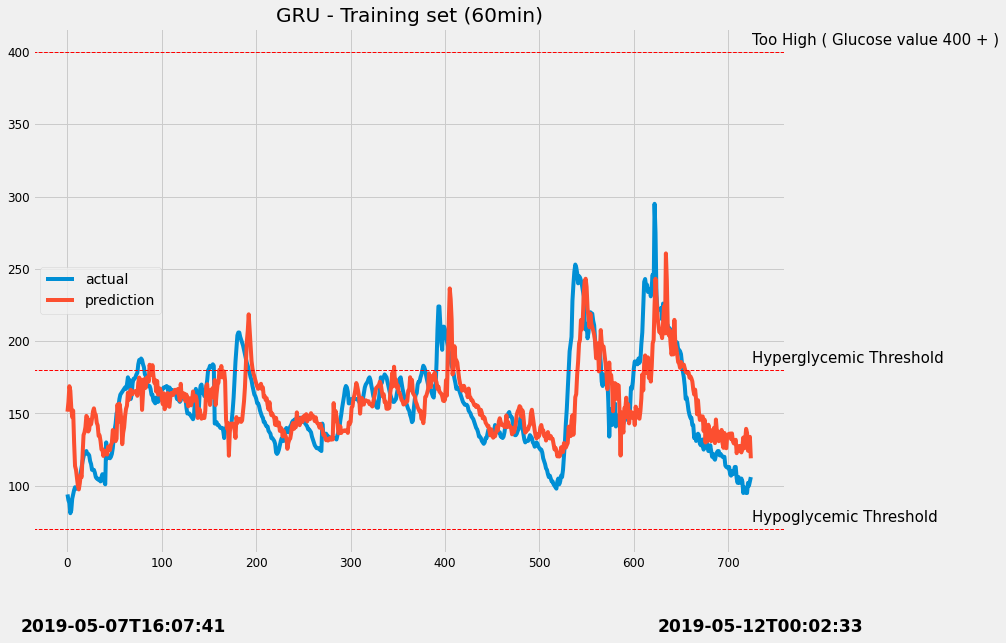

In [1028]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GA

In [1029]:
val_rnn_60_predict_result = np.asarray(val_rnn_60_predict_result)
val_lstm_60_predict_result = np.asarray(val_lstm_60_predict_result)
val_slstm_60_predict_result = np.asarray(val_slstm_60_predict_result)
val_bilstm_60_predict_result = np.asarray(val_bilstm_60_predict_result)
val_gru_60_predict_result = np.asarray(val_gru_60_predict_result)

In [1030]:
train_rnn_60_predict_result = np.asarray(train_rnn_60_predict_result)
train_lstm_60_predict_result = np.asarray(train_lstm_60_predict_result)
train_slstm_60_predict_result = np.asarray(train_slstm_60_predict_result)
train_bilstm_60_predict_result = np.asarray(train_bilstm_60_predict_result)
train_gru_60_predict_result = np.asarray(train_gru_60_predict_result)

In [1036]:
def evaluate2(X):
  pen = 0 
  #coef = [0,0,0,0,0]
  ab=0
  result =0
  #result2 = 0
  #print(X)
  if sum(X) > 0.99 and sum(X) < 1:
    #print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    #result = mean_squared_error((y_val_uni_origin,(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +
    #             val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] +
    #             val_gru_30_predict_result * X[4]))**0.5)
   # ab = val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4]
   # print("\n ** A ** \n")
   # print(ab.shape)
    result = 100 - np.sqrt(mean_squared_error(train_rnn_60_predict_result * X[0] + train_lstm_60_predict_result * X[1] +train_slstm_60_predict_result * X[2] + 
                                train_bilstm_60_predict_result * X[3] + train_gru_60_predict_result * X[4],y_train_uni_origin))
    
    #result = 10 - mean_squared_error(y_val_uni_origin,abc) / test_result 
    #result2=(test_result*5) - np.sqrt(result)
    #test_result =  mean_squared_error(y_val_uni_origin,ex)
    #test_result

    #pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
    print("\n ** B ** \n")
    print(X)
    #print()
    print("\n ** C ** \n")
    print(result)
  #return np.sum(X) + pen
    #count += 1 
  return -result
    
    

In [1032]:
varbound2 = np.array([[0.05, 0.5]]*5)

In [1033]:
algorithm_param = {'max_num_iteration': 10000,
                   'population_size':100,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'selection_type': 'roulette',
                   'max_iteration_without_improv':None}

In [1037]:
model3 = ga(function = evaluate2, dimension = 5, variable_type='real',variable_boundaries=varbound2,algorithm_parameters = algorithm_param)

In [ ]:
model3.run()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

 ** B ** 

[0.05308817 0.11860521 0.28350681 0.47829723 0.06215614]

 ** C ** 

78.40479151805626

 ** B ** 

[0.05308817 0.11968315 0.27827296 0.47829723 0.06215614]

 ** C ** 

78.46618287581212

 ** B ** 

[0.05308817 0.11860521 0.28350681 0.47829723 0.06215614]

 ** C ** 

78.40479151805626

 ** B ** 

[0.05308817 0.11860521 0.28350681 0.47829723 0.05650697]

 ** C ** 

78.48718663262781

 ** B ** 

[0.05308817 0.11860521 0.28350681 0.47829723 0.06215614]

 ** C ** 

78.40479151805626

 ** B ** 

[0.05308817 0.11860521 0.28350681 0.47829723 0.06215614]

 ** C ** 

78.40479151805626
||||||||||________________________________________ 20.2% GA is running...2024 gen from 10000
 ** B ** 

[0.05308817 0.11968315 0.28350681 0.47829723 0.06215614]

 ** C ** 

78.38540287193753

 ** B ** 

[0.05308817 0.11860521 0.27827296 0.47829723 0.06215614]

 ** C ** 

78.4791556854486

 ** B ** 

[0.05308817 0.11860521 0.28350681 0.47829723 0.06215614]

 ** C ** 



In [ ]:
# RMSE 
optimized = val_rnn_60_predict_result * model3.output_dict['variable'][0] + val_lstm_60_predict_result *model3.output_dict['variable'][1] + val_slstm_60_predict_result * model3.output_dict['variable'][2] + val_bilstm_60_predict_result * model3.output_dict['variable'][3] + val_gru_60_predict_result * model3.output_dict['variable'][4]
for i in range(len(optimized)):
    if optimized[i] >= 400: 
        optimized[i]=400
    if optimized[i] <= 60: 
        optimized[i]=60
optimized_rmse_60 =  RMSE(y_val_uni_origin,optimized)
optimized_rmse_60

In [ ]:
optimized

In [ ]:
get_optimized = np.array(optimized)

In [ ]:
get_optimized = get_optimized.T

In [ ]:
get_optimized.shape

In [ ]:
ar_val_60=np.concatenate((get_y_val_origin_60, get_val_rnn_60_predict_result,get_val_lstm_60_predict_result,get_val_slstm_60_predict_result,get_val_bilstm_60_predict_result,get_val_gru_60_predict_result,get_optimized), axis = 0)


In [ ]:
ar_train_60 = np.concatenate((get_x_train_origin_60, get_train_rnn_60_predict_result ,get_train_lstm_60_predict_result ,get_train_slstm_60_predict_result,get_train_bilstm_60_predict_result,get_train_gru_60_predict_result),axis=0)

In [ ]:
#ar_val_15=np.concatenate((get_y_val_origin, get_val_rnn_15_predict_result,get_val_lstm_15_predict_result,get_val_slstm_15_predict_result,get_val_bilstm_15_predict_result,get_val_gru_15_predict_result), axis = 0)


In [ ]:
#ar_train_15 = np.concatenate((get_x_train_origin_15, get_train_rnn_15_predict_result ,get_train_lstm_15_predict_result ,get_train_slstm_15_predict_result,get_train_bilstm_15_predict_result,get_train_gru_15_predict_result),axis=0)

In [ ]:
y1=pd.DataFrame(ar_val_60,index=['60_val_origin','60_val_rnn','60_val_lstm','60_val_slstm','60_val_bilstm','60_val_gru','60_optimized'])
y1

In [ ]:
y2=pd.DataFrame(ar_train_30,index=['60_train_origin','60_train_rnn','60_train_lstm','60_train_slstm','60_train_bilstm','60_train_gru'])
y2
#y.append(get_val_rnn_15_predict_result,ignore_index=True)

In [ ]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(optimized,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(y_val_uni_origin),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(y_val_uni_origin)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

#### GA_Residual

In [ ]:
# Make a new dataframe of your prediction values
df_new = pd.DataFrame(df['Glucose'])
df_new.columns = ['rawseq']

# Retrieve index values
new_index = df_new['rawseq'].tail(len(optimized)).index

# Make a dataframe with your prediction values and your index
new_series = pd.DataFrame(index = new_index, data = optimized)

# Merge the dataframes
df_new = pd.merge(df_new, new_series, how = 'left', left_index=True, right_index=True)
df_new.columns = ['rawseq', 'optimized']

# And plot it
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))

plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)

plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(raw_seq),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(raw_seq),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(raw_seq),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized - 60min',family='Times New Roman')
plt.plot(df_new['rawseq'],label='actual',linewidth=2)
plt.plot(df_new['optimized'], label='predicted',linewidth=2)
plt.legend(loc='best')
plt.show()

In [ ]:
residuals = [y_val_uni_origin[i]-optimized[i] for i in range(len(optimized))]
residuals = y_val_uni_origin - optimized.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("60Min GA Normal Q-Q Plot")

In [ ]:
probplot(residuals,dist="norm",plot=plt)
plt.title("60Min GA Normal Q-Q Plot")

In [ ]:
residuals=DataFrame(residuals)

In [ ]:
residuals.plot()

In [ ]:

residuals.hist()

In [ ]:
residuals.plot(kind='kde')

In [ ]:
from statsmodels.graphics.gofplots import qqplot
residuals=np.array(residuals)
qqplot(residuals)

## 결과

In [ ]:
train_15_result = [train_rnn_15,train_lstm_15,train_stacklstm_15,train_bilstm_15,train_gru_15]
val_15_result =[val_rnn_15,val_lstm_15,val_stacklstm_15,val_bilstm_15,val_gru_15,optimized_rmse_15]
train_30_result = [train_rnn_30,train_lstm_30,train_stacklstm_30,train_bilstm_30,train_gru_30]
val_30_result =[val_rnn_30,val_lstm_30,val_stacklstm_30,val_bilstm_30,val_gru_30,optimized_rmse_30]
train_60_result = [train_rnn_60,train_lstm_60,train_stacklstm_60,train_bilstm_60,train_gru_60]
val_60_result =[val_rnn_60,val_lstm_60,val_stacklstm_60,val_bilstm_60,val_gru_60,optimized_rmse_60]


In [ ]:
val_rnn_result = [val_rnn_15,val_rnn_30,val_rnn_60]
val_lstm_result = [val_lstm_15,val_lstm_30,val_lstm_60]
val_stacklstm_result = [val_stacklstm_15,val_stacklstm_30,val_stacklstm_60]
val_bilstm_result = [val_bilstm_15,val_bilstm_30,val_bilstm_60]
val_gru_result = [val_gru_15,val_gru_30,val_gru_60]
val_optimized_result = [optimized_rmse_15,optimized_rmse_30,optimized_rmse_60]

In [ ]:
train_rnn_result = [train_rnn_15,train_rnn_30,train_rnn_60]
train_lstm_result = [train_lstm_15,train_lstm_30,train_lstm_60]
train_stacklstm_result = [train_stacklstm_15,train_stacklstm_30,train_stacklstm_60]
train_bilstm_result = [train_bilstm_15,train_bilstm_30,train_bilstm_60]
train_gru_result = [train_gru_15,train_gru_30,train_gru_60]

In [ ]:
train_result_list =[train_rnn_result,train_lstm_result,train_stacklstm_result,train_bilstm_result,train_gru_result,]

In [ ]:
val_result_list =[val_rnn_result,val_lstm_result,val_stacklstm_result,val_bilstm_result,val_gru_result,val_optimized_result]

In [ ]:
val_result_list

In [ ]:
val_df = pd.DataFrame(index=['RNN','LSTM','Stacked LSTM','Bidirectional LSTM','GRU','Optimized'], 
                      columns =['15 MIN','30 MIN','60 MIN'],data=val_result_list)
val_df

In [ ]:
train_df = pd.DataFrame(index=['RNN','LSTM','Stacked LSTM','Bidirectional LSTM','GRU'], 
                      columns =['15 MIN','30 MIN','60 MIN'],data=train_result_list)
train_df

## CNN LSTM